In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [2]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
graph = tf.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class SGAN:
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(100,))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(noise, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())

        model.summary()

        img = Input(shape=self.img_shape)

        features = model(img)
        valid = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [valid, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Class weights:
        # To balance the difference in occurences of digit class labels.
        # 50% of labels that the discriminator trains on are 'fake'.
        # Weight = 1 / frequency
        half_batch = batch_size // 2
        cw1 = {0: 1, 1: 1}
        cw2 = {i: self.num_classes / half_batch for i in range(self.num_classes)}
        cw2[self.num_classes] = 1 / half_batch

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # One-hot encoding of labels
            labels = to_categorical(y_train[idx], num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid, class_weight=[cw1, cw2])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

            # If at save interval => save generated image samples
            if epoch>=19000:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(r"C:\Users\KIIT\AppData\Local\Programs\Python\Python36\Scripts\Untitled Folder 2\SGAN Images\mnist_%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "mnist_sgan_generator")
        save(self.discriminator, "mnist_sgan_discriminator")
        save(self.combined, "mnist_sgan_adversarial")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_______________________________________

c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.902503, acc: 40.62%, op_acc: 6.25%] [G loss: 0.683995]


c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.754012, acc: 62.50%, op_acc: 6.25%] [G loss: 0.766633]
2 [D loss: 0.679574, acc: 85.94%, op_acc: 12.50%] [G loss: 0.874214]
3 [D loss: 0.565264, acc: 92.19%, op_acc: 12.50%] [G loss: 0.906552]
4 [D loss: 0.504022, acc: 98.44%, op_acc: 18.75%] [G loss: 0.757204]
5 [D loss: 0.524515, acc: 100.00%, op_acc: 28.12%] [G loss: 0.703495]
6 [D loss: 0.551429, acc: 95.31%, op_acc: 28.12%] [G loss: 0.984432]
7 [D loss: 0.563622, acc: 81.25%, op_acc: 31.25%] [G loss: 0.903218]
8 [D loss: 0.585998, acc: 79.69%, op_acc: 17.19%] [G loss: 1.257435]
9 [D loss: 0.617970, acc: 76.56%, op_acc: 17.19%] [G loss: 1.198305]
10 [D loss: 0.588886, acc: 85.94%, op_acc: 14.06%] [G loss: 1.470627]
11 [D loss: 0.560215, acc: 84.38%, op_acc: 25.00%] [G loss: 1.210054]
12 [D loss: 0.572507, acc: 82.81%, op_acc: 23.44%] [G loss: 0.858703]
13 [D loss: 0.537548, acc: 92.19%, op_acc: 29.69%] [G loss: 0.711311]
14 [D loss: 0.509501, acc: 92.19%, op_acc: 32.81%] [G loss: 0.399693]
15 [D loss: 0.455751, acc: 93

118 [D loss: 0.701403, acc: 35.94%, op_acc: 40.62%] [G loss: 1.513717]
119 [D loss: 0.556019, acc: 56.25%, op_acc: 46.88%] [G loss: 1.782995]
120 [D loss: 0.562065, acc: 54.69%, op_acc: 50.00%] [G loss: 1.775524]
121 [D loss: 0.592577, acc: 48.44%, op_acc: 50.00%] [G loss: 1.529720]
122 [D loss: 0.552475, acc: 56.25%, op_acc: 50.00%] [G loss: 1.558777]
123 [D loss: 0.592222, acc: 51.56%, op_acc: 42.19%] [G loss: 1.858958]
124 [D loss: 0.677432, acc: 40.62%, op_acc: 46.88%] [G loss: 1.656941]
125 [D loss: 0.530722, acc: 48.44%, op_acc: 46.88%] [G loss: 1.463293]
126 [D loss: 0.616456, acc: 43.75%, op_acc: 50.00%] [G loss: 1.760255]
127 [D loss: 0.617611, acc: 54.69%, op_acc: 43.75%] [G loss: 1.347008]
128 [D loss: 0.492940, acc: 56.25%, op_acc: 40.62%] [G loss: 1.710087]
129 [D loss: 0.606607, acc: 46.88%, op_acc: 45.31%] [G loss: 1.515828]
130 [D loss: 0.526506, acc: 54.69%, op_acc: 45.31%] [G loss: 1.435724]
131 [D loss: 0.514862, acc: 51.56%, op_acc: 51.56%] [G loss: 1.532473]
132 [D

234 [D loss: 0.514364, acc: 59.38%, op_acc: 51.56%] [G loss: 1.171433]
235 [D loss: 0.583537, acc: 50.00%, op_acc: 53.12%] [G loss: 1.302052]
236 [D loss: 0.444502, acc: 68.75%, op_acc: 48.44%] [G loss: 1.421878]
237 [D loss: 0.554730, acc: 46.88%, op_acc: 40.62%] [G loss: 1.190207]
238 [D loss: 0.479825, acc: 57.81%, op_acc: 46.88%] [G loss: 1.276311]
239 [D loss: 0.531892, acc: 53.12%, op_acc: 45.31%] [G loss: 1.484162]
240 [D loss: 0.504866, acc: 60.94%, op_acc: 50.00%] [G loss: 1.328961]
241 [D loss: 0.550256, acc: 59.38%, op_acc: 48.44%] [G loss: 1.198192]
242 [D loss: 0.462220, acc: 53.12%, op_acc: 46.88%] [G loss: 1.314970]
243 [D loss: 0.541643, acc: 64.06%, op_acc: 43.75%] [G loss: 1.513762]
244 [D loss: 0.501066, acc: 54.69%, op_acc: 45.31%] [G loss: 1.646189]
245 [D loss: 0.552227, acc: 64.06%, op_acc: 45.31%] [G loss: 1.161685]
246 [D loss: 0.526879, acc: 45.31%, op_acc: 43.75%] [G loss: 1.362530]
247 [D loss: 0.489670, acc: 56.25%, op_acc: 53.12%] [G loss: 1.050052]
248 [D

350 [D loss: 0.407349, acc: 56.25%, op_acc: 54.69%] [G loss: 1.321881]
351 [D loss: 0.387592, acc: 65.62%, op_acc: 60.94%] [G loss: 1.101411]
352 [D loss: 0.409756, acc: 73.44%, op_acc: 48.44%] [G loss: 1.399282]
353 [D loss: 0.491848, acc: 53.12%, op_acc: 56.25%] [G loss: 1.418834]
354 [D loss: 0.476169, acc: 57.81%, op_acc: 59.38%] [G loss: 1.039925]
355 [D loss: 0.471195, acc: 53.12%, op_acc: 59.38%] [G loss: 1.199281]
356 [D loss: 0.475073, acc: 48.44%, op_acc: 56.25%] [G loss: 1.305770]
357 [D loss: 0.452843, acc: 70.31%, op_acc: 50.00%] [G loss: 1.342691]
358 [D loss: 0.461057, acc: 51.56%, op_acc: 50.00%] [G loss: 1.558601]
359 [D loss: 0.526426, acc: 46.88%, op_acc: 53.12%] [G loss: 1.193873]
360 [D loss: 0.451867, acc: 57.81%, op_acc: 57.81%] [G loss: 1.195028]
361 [D loss: 0.424191, acc: 57.81%, op_acc: 62.50%] [G loss: 1.448897]
362 [D loss: 0.456850, acc: 60.94%, op_acc: 59.38%] [G loss: 1.152417]
363 [D loss: 0.468495, acc: 60.94%, op_acc: 57.81%] [G loss: 1.212028]
364 [D

466 [D loss: 0.454483, acc: 60.94%, op_acc: 53.12%] [G loss: 1.254391]
467 [D loss: 0.456756, acc: 64.06%, op_acc: 50.00%] [G loss: 1.132203]
468 [D loss: 0.486150, acc: 57.81%, op_acc: 57.81%] [G loss: 1.088567]
469 [D loss: 0.377310, acc: 76.56%, op_acc: 64.06%] [G loss: 1.602618]
470 [D loss: 0.430992, acc: 62.50%, op_acc: 57.81%] [G loss: 1.329450]
471 [D loss: 0.441486, acc: 54.69%, op_acc: 54.69%] [G loss: 1.211796]
472 [D loss: 0.437156, acc: 57.81%, op_acc: 51.56%] [G loss: 1.369128]
473 [D loss: 0.409972, acc: 64.06%, op_acc: 56.25%] [G loss: 1.309906]
474 [D loss: 0.376328, acc: 60.94%, op_acc: 64.06%] [G loss: 1.129912]
475 [D loss: 0.368891, acc: 71.88%, op_acc: 56.25%] [G loss: 1.401462]
476 [D loss: 0.432186, acc: 65.62%, op_acc: 54.69%] [G loss: 1.256770]
477 [D loss: 0.446778, acc: 59.38%, op_acc: 57.81%] [G loss: 1.368781]
478 [D loss: 0.349683, acc: 71.88%, op_acc: 59.38%] [G loss: 1.323079]
479 [D loss: 0.480189, acc: 54.69%, op_acc: 60.94%] [G loss: 1.508279]
480 [D

582 [D loss: 0.362187, acc: 70.31%, op_acc: 57.81%] [G loss: 1.575296]
583 [D loss: 0.489563, acc: 60.94%, op_acc: 45.31%] [G loss: 1.690305]
584 [D loss: 0.272397, acc: 82.81%, op_acc: 67.19%] [G loss: 1.434039]
585 [D loss: 0.399646, acc: 53.12%, op_acc: 65.62%] [G loss: 1.349172]
586 [D loss: 0.358442, acc: 71.88%, op_acc: 67.19%] [G loss: 1.495182]
587 [D loss: 0.472216, acc: 59.38%, op_acc: 56.25%] [G loss: 1.341295]
588 [D loss: 0.379812, acc: 73.44%, op_acc: 48.44%] [G loss: 1.129839]
589 [D loss: 0.435270, acc: 65.62%, op_acc: 54.69%] [G loss: 1.246443]
590 [D loss: 0.475466, acc: 54.69%, op_acc: 53.12%] [G loss: 1.059863]
591 [D loss: 0.382337, acc: 75.00%, op_acc: 48.44%] [G loss: 1.318425]
592 [D loss: 0.428972, acc: 60.94%, op_acc: 57.81%] [G loss: 1.332264]
593 [D loss: 0.373708, acc: 76.56%, op_acc: 48.44%] [G loss: 1.452132]
594 [D loss: 0.433792, acc: 62.50%, op_acc: 56.25%] [G loss: 1.271124]
595 [D loss: 0.474183, acc: 56.25%, op_acc: 51.56%] [G loss: 1.059201]
596 [D

698 [D loss: 0.400138, acc: 67.19%, op_acc: 60.94%] [G loss: 1.645931]
699 [D loss: 0.296465, acc: 75.00%, op_acc: 68.75%] [G loss: 1.556554]
700 [D loss: 0.375336, acc: 71.88%, op_acc: 60.94%] [G loss: 1.424020]
701 [D loss: 0.290052, acc: 81.25%, op_acc: 60.94%] [G loss: 1.844005]
702 [D loss: 0.404636, acc: 65.62%, op_acc: 57.81%] [G loss: 1.486495]
703 [D loss: 0.327785, acc: 75.00%, op_acc: 64.06%] [G loss: 1.259566]
704 [D loss: 0.414803, acc: 68.75%, op_acc: 56.25%] [G loss: 1.445477]
705 [D loss: 0.396135, acc: 68.75%, op_acc: 64.06%] [G loss: 1.320036]
706 [D loss: 0.281288, acc: 82.81%, op_acc: 67.19%] [G loss: 1.183603]
707 [D loss: 0.358964, acc: 81.25%, op_acc: 53.12%] [G loss: 1.480325]
708 [D loss: 0.400961, acc: 65.62%, op_acc: 51.56%] [G loss: 1.138227]
709 [D loss: 0.335077, acc: 75.00%, op_acc: 60.94%] [G loss: 1.368521]
710 [D loss: 0.421733, acc: 65.62%, op_acc: 59.38%] [G loss: 1.217559]
711 [D loss: 0.374480, acc: 71.88%, op_acc: 57.81%] [G loss: 1.739882]
712 [D

814 [D loss: 0.546304, acc: 42.19%, op_acc: 50.00%] [G loss: 1.203812]
815 [D loss: 0.330156, acc: 76.56%, op_acc: 64.06%] [G loss: 1.645141]
816 [D loss: 0.354137, acc: 70.31%, op_acc: 56.25%] [G loss: 1.208635]
817 [D loss: 0.403838, acc: 59.38%, op_acc: 60.94%] [G loss: 1.359034]
818 [D loss: 0.395545, acc: 57.81%, op_acc: 56.25%] [G loss: 1.375582]
819 [D loss: 0.334831, acc: 70.31%, op_acc: 67.19%] [G loss: 1.476272]
820 [D loss: 0.479073, acc: 56.25%, op_acc: 60.94%] [G loss: 1.285568]
821 [D loss: 0.235404, acc: 85.94%, op_acc: 65.62%] [G loss: 1.639778]
822 [D loss: 0.358029, acc: 64.06%, op_acc: 62.50%] [G loss: 1.511474]
823 [D loss: 0.523388, acc: 53.12%, op_acc: 53.12%] [G loss: 1.565603]
824 [D loss: 0.395698, acc: 64.06%, op_acc: 60.94%] [G loss: 1.612751]
825 [D loss: 0.257974, acc: 79.69%, op_acc: 73.44%] [G loss: 1.347683]
826 [D loss: 0.339003, acc: 76.56%, op_acc: 68.75%] [G loss: 1.135012]
827 [D loss: 0.340754, acc: 78.12%, op_acc: 68.75%] [G loss: 1.369979]
828 [D

930 [D loss: 0.533056, acc: 48.44%, op_acc: 53.12%] [G loss: 1.191995]
931 [D loss: 0.444335, acc: 60.94%, op_acc: 46.88%] [G loss: 1.112503]
932 [D loss: 0.377704, acc: 67.19%, op_acc: 56.25%] [G loss: 1.299420]
933 [D loss: 0.377341, acc: 67.19%, op_acc: 62.50%] [G loss: 1.273988]
934 [D loss: 0.339941, acc: 73.44%, op_acc: 53.12%] [G loss: 1.475196]
935 [D loss: 0.376260, acc: 60.94%, op_acc: 60.94%] [G loss: 1.383678]
936 [D loss: 0.379831, acc: 57.81%, op_acc: 60.94%] [G loss: 1.262825]
937 [D loss: 0.413958, acc: 68.75%, op_acc: 57.81%] [G loss: 1.291937]
938 [D loss: 0.419374, acc: 65.62%, op_acc: 57.81%] [G loss: 1.248536]
939 [D loss: 0.374446, acc: 62.50%, op_acc: 64.06%] [G loss: 1.668037]
940 [D loss: 0.462488, acc: 59.38%, op_acc: 54.69%] [G loss: 1.359887]
941 [D loss: 0.375035, acc: 68.75%, op_acc: 56.25%] [G loss: 1.126205]
942 [D loss: 0.382830, acc: 59.38%, op_acc: 59.38%] [G loss: 1.306243]
943 [D loss: 0.428277, acc: 59.38%, op_acc: 57.81%] [G loss: 1.480368]
944 [D

1045 [D loss: 0.364011, acc: 62.50%, op_acc: 57.81%] [G loss: 1.042027]
1046 [D loss: 0.359368, acc: 75.00%, op_acc: 56.25%] [G loss: 1.012463]
1047 [D loss: 0.400034, acc: 64.06%, op_acc: 51.56%] [G loss: 1.299418]
1048 [D loss: 0.396517, acc: 67.19%, op_acc: 56.25%] [G loss: 1.113652]
1049 [D loss: 0.420631, acc: 59.38%, op_acc: 54.69%] [G loss: 0.882665]
1050 [D loss: 0.475251, acc: 48.44%, op_acc: 59.38%] [G loss: 1.269839]
1051 [D loss: 0.383941, acc: 67.19%, op_acc: 57.81%] [G loss: 1.188417]
1052 [D loss: 0.467465, acc: 56.25%, op_acc: 57.81%] [G loss: 1.103547]
1053 [D loss: 0.392463, acc: 57.81%, op_acc: 57.81%] [G loss: 1.155778]
1054 [D loss: 0.367160, acc: 65.62%, op_acc: 65.62%] [G loss: 1.295590]
1055 [D loss: 0.453427, acc: 62.50%, op_acc: 50.00%] [G loss: 1.433504]
1056 [D loss: 0.335088, acc: 70.31%, op_acc: 64.06%] [G loss: 1.223154]
1057 [D loss: 0.405375, acc: 60.94%, op_acc: 56.25%] [G loss: 1.366576]
1058 [D loss: 0.358692, acc: 60.94%, op_acc: 56.25%] [G loss: 1.

1159 [D loss: 0.398558, acc: 64.06%, op_acc: 60.94%] [G loss: 1.194046]
1160 [D loss: 0.436744, acc: 57.81%, op_acc: 56.25%] [G loss: 1.246041]
1161 [D loss: 0.385904, acc: 65.62%, op_acc: 46.88%] [G loss: 1.125766]
1162 [D loss: 0.451792, acc: 48.44%, op_acc: 54.69%] [G loss: 1.178378]
1163 [D loss: 0.343444, acc: 67.19%, op_acc: 65.62%] [G loss: 1.370224]
1164 [D loss: 0.421534, acc: 60.94%, op_acc: 54.69%] [G loss: 1.067169]
1165 [D loss: 0.430696, acc: 53.12%, op_acc: 56.25%] [G loss: 1.272339]
1166 [D loss: 0.390519, acc: 75.00%, op_acc: 57.81%] [G loss: 1.197756]
1167 [D loss: 0.368591, acc: 70.31%, op_acc: 56.25%] [G loss: 1.438252]
1168 [D loss: 0.365322, acc: 65.62%, op_acc: 54.69%] [G loss: 1.131834]
1169 [D loss: 0.399544, acc: 64.06%, op_acc: 62.50%] [G loss: 1.327178]
1170 [D loss: 0.404866, acc: 67.19%, op_acc: 64.06%] [G loss: 1.387692]
1171 [D loss: 0.430182, acc: 59.38%, op_acc: 54.69%] [G loss: 1.159638]
1172 [D loss: 0.393022, acc: 59.38%, op_acc: 53.12%] [G loss: 1.

1273 [D loss: 0.371558, acc: 67.19%, op_acc: 57.81%] [G loss: 1.258930]
1274 [D loss: 0.347801, acc: 67.19%, op_acc: 60.94%] [G loss: 1.289653]
1275 [D loss: 0.338976, acc: 62.50%, op_acc: 68.75%] [G loss: 1.495936]
1276 [D loss: 0.362413, acc: 68.75%, op_acc: 57.81%] [G loss: 1.213175]
1277 [D loss: 0.394590, acc: 56.25%, op_acc: 59.38%] [G loss: 1.374466]
1278 [D loss: 0.365650, acc: 62.50%, op_acc: 62.50%] [G loss: 1.403625]
1279 [D loss: 0.425049, acc: 65.62%, op_acc: 53.12%] [G loss: 1.125129]
1280 [D loss: 0.432117, acc: 53.12%, op_acc: 65.62%] [G loss: 1.456780]
1281 [D loss: 0.384509, acc: 56.25%, op_acc: 56.25%] [G loss: 1.138578]
1282 [D loss: 0.376672, acc: 59.38%, op_acc: 59.38%] [G loss: 1.058809]
1283 [D loss: 0.416536, acc: 59.38%, op_acc: 64.06%] [G loss: 1.248106]
1284 [D loss: 0.365608, acc: 79.69%, op_acc: 51.56%] [G loss: 1.341140]
1285 [D loss: 0.350006, acc: 76.56%, op_acc: 73.44%] [G loss: 1.363694]
1286 [D loss: 0.413747, acc: 57.81%, op_acc: 57.81%] [G loss: 1.

1387 [D loss: 0.453035, acc: 43.75%, op_acc: 51.56%] [G loss: 1.125832]
1388 [D loss: 0.419095, acc: 56.25%, op_acc: 65.62%] [G loss: 1.147815]
1389 [D loss: 0.487322, acc: 62.50%, op_acc: 50.00%] [G loss: 1.286869]
1390 [D loss: 0.371602, acc: 71.88%, op_acc: 64.06%] [G loss: 1.296408]
1391 [D loss: 0.383871, acc: 57.81%, op_acc: 57.81%] [G loss: 1.258409]
1392 [D loss: 0.425402, acc: 53.12%, op_acc: 56.25%] [G loss: 1.142703]
1393 [D loss: 0.448830, acc: 51.56%, op_acc: 53.12%] [G loss: 1.285847]
1394 [D loss: 0.392351, acc: 67.19%, op_acc: 59.38%] [G loss: 1.002896]
1395 [D loss: 0.357892, acc: 73.44%, op_acc: 59.38%] [G loss: 1.454891]
1396 [D loss: 0.444236, acc: 50.00%, op_acc: 56.25%] [G loss: 1.327343]
1397 [D loss: 0.445785, acc: 59.38%, op_acc: 60.94%] [G loss: 1.393777]
1398 [D loss: 0.465578, acc: 57.81%, op_acc: 65.62%] [G loss: 1.227720]
1399 [D loss: 0.351718, acc: 59.38%, op_acc: 60.94%] [G loss: 1.249378]
1400 [D loss: 0.345711, acc: 76.56%, op_acc: 59.38%] [G loss: 1.

1501 [D loss: 0.447696, acc: 57.81%, op_acc: 57.81%] [G loss: 1.117478]
1502 [D loss: 0.353882, acc: 75.00%, op_acc: 57.81%] [G loss: 1.164464]
1503 [D loss: 0.382155, acc: 67.19%, op_acc: 57.81%] [G loss: 1.320634]
1504 [D loss: 0.376671, acc: 62.50%, op_acc: 60.94%] [G loss: 1.311915]
1505 [D loss: 0.347696, acc: 64.06%, op_acc: 64.06%] [G loss: 1.491520]
1506 [D loss: 0.356666, acc: 65.62%, op_acc: 57.81%] [G loss: 1.407529]
1507 [D loss: 0.396062, acc: 73.44%, op_acc: 56.25%] [G loss: 1.148517]
1508 [D loss: 0.447081, acc: 54.69%, op_acc: 64.06%] [G loss: 1.299126]
1509 [D loss: 0.334473, acc: 64.06%, op_acc: 62.50%] [G loss: 1.121716]
1510 [D loss: 0.336255, acc: 73.44%, op_acc: 62.50%] [G loss: 1.218145]
1511 [D loss: 0.334753, acc: 65.62%, op_acc: 70.31%] [G loss: 1.399423]
1512 [D loss: 0.356060, acc: 65.62%, op_acc: 54.69%] [G loss: 1.146308]
1513 [D loss: 0.474758, acc: 53.12%, op_acc: 60.94%] [G loss: 1.310295]
1514 [D loss: 0.343332, acc: 62.50%, op_acc: 56.25%] [G loss: 1.

1615 [D loss: 0.387297, acc: 62.50%, op_acc: 59.38%] [G loss: 1.239146]
1616 [D loss: 0.388777, acc: 59.38%, op_acc: 67.19%] [G loss: 1.279550]
1617 [D loss: 0.375882, acc: 67.19%, op_acc: 56.25%] [G loss: 1.068813]
1618 [D loss: 0.343854, acc: 71.88%, op_acc: 62.50%] [G loss: 1.262121]
1619 [D loss: 0.329072, acc: 71.88%, op_acc: 67.19%] [G loss: 1.253754]
1620 [D loss: 0.405575, acc: 67.19%, op_acc: 64.06%] [G loss: 1.347730]
1621 [D loss: 0.375209, acc: 67.19%, op_acc: 59.38%] [G loss: 1.165965]
1622 [D loss: 0.464571, acc: 48.44%, op_acc: 53.12%] [G loss: 1.038421]
1623 [D loss: 0.378620, acc: 57.81%, op_acc: 67.19%] [G loss: 1.210736]
1624 [D loss: 0.413210, acc: 70.31%, op_acc: 50.00%] [G loss: 0.942940]
1625 [D loss: 0.470396, acc: 60.94%, op_acc: 54.69%] [G loss: 1.480657]
1626 [D loss: 0.424795, acc: 59.38%, op_acc: 54.69%] [G loss: 1.204074]
1627 [D loss: 0.420449, acc: 56.25%, op_acc: 57.81%] [G loss: 1.063065]
1628 [D loss: 0.438656, acc: 57.81%, op_acc: 56.25%] [G loss: 1.

1729 [D loss: 0.444193, acc: 60.94%, op_acc: 64.06%] [G loss: 1.087966]
1730 [D loss: 0.446535, acc: 48.44%, op_acc: 59.38%] [G loss: 1.068106]
1731 [D loss: 0.371100, acc: 60.94%, op_acc: 64.06%] [G loss: 0.957975]
1732 [D loss: 0.512586, acc: 57.81%, op_acc: 50.00%] [G loss: 1.099525]
1733 [D loss: 0.421198, acc: 57.81%, op_acc: 57.81%] [G loss: 1.113658]
1734 [D loss: 0.406692, acc: 62.50%, op_acc: 53.12%] [G loss: 1.138528]
1735 [D loss: 0.394996, acc: 71.88%, op_acc: 57.81%] [G loss: 1.103352]
1736 [D loss: 0.368194, acc: 65.62%, op_acc: 54.69%] [G loss: 1.291075]
1737 [D loss: 0.404095, acc: 56.25%, op_acc: 54.69%] [G loss: 1.371951]
1738 [D loss: 0.381552, acc: 67.19%, op_acc: 57.81%] [G loss: 1.246792]
1739 [D loss: 0.355564, acc: 68.75%, op_acc: 54.69%] [G loss: 1.300211]
1740 [D loss: 0.340633, acc: 76.56%, op_acc: 60.94%] [G loss: 1.173405]
1741 [D loss: 0.456509, acc: 62.50%, op_acc: 56.25%] [G loss: 1.103534]
1742 [D loss: 0.480855, acc: 56.25%, op_acc: 51.56%] [G loss: 1.

1843 [D loss: 0.342551, acc: 71.88%, op_acc: 57.81%] [G loss: 1.310219]
1844 [D loss: 0.377807, acc: 60.94%, op_acc: 59.38%] [G loss: 1.123080]
1845 [D loss: 0.335916, acc: 67.19%, op_acc: 56.25%] [G loss: 1.093291]
1846 [D loss: 0.362825, acc: 62.50%, op_acc: 62.50%] [G loss: 1.126232]
1847 [D loss: 0.427259, acc: 53.12%, op_acc: 59.38%] [G loss: 1.066129]
1848 [D loss: 0.390242, acc: 53.12%, op_acc: 64.06%] [G loss: 1.055238]
1849 [D loss: 0.403938, acc: 56.25%, op_acc: 65.62%] [G loss: 1.155917]
1850 [D loss: 0.361539, acc: 68.75%, op_acc: 57.81%] [G loss: 1.147293]
1851 [D loss: 0.416543, acc: 56.25%, op_acc: 57.81%] [G loss: 1.046402]
1852 [D loss: 0.365944, acc: 59.38%, op_acc: 53.12%] [G loss: 1.371224]
1853 [D loss: 0.362140, acc: 70.31%, op_acc: 56.25%] [G loss: 1.245420]
1854 [D loss: 0.425759, acc: 56.25%, op_acc: 60.94%] [G loss: 1.247672]
1855 [D loss: 0.431952, acc: 57.81%, op_acc: 54.69%] [G loss: 1.348587]
1856 [D loss: 0.434831, acc: 59.38%, op_acc: 50.00%] [G loss: 1.

1957 [D loss: 0.451059, acc: 62.50%, op_acc: 53.12%] [G loss: 1.196612]
1958 [D loss: 0.457788, acc: 57.81%, op_acc: 50.00%] [G loss: 0.991149]
1959 [D loss: 0.373947, acc: 65.62%, op_acc: 62.50%] [G loss: 1.279763]
1960 [D loss: 0.388931, acc: 59.38%, op_acc: 56.25%] [G loss: 1.115305]
1961 [D loss: 0.390398, acc: 57.81%, op_acc: 60.94%] [G loss: 0.988193]
1962 [D loss: 0.341173, acc: 70.31%, op_acc: 59.38%] [G loss: 1.221111]
1963 [D loss: 0.399192, acc: 67.19%, op_acc: 64.06%] [G loss: 1.130443]
1964 [D loss: 0.312674, acc: 75.00%, op_acc: 64.06%] [G loss: 1.113251]
1965 [D loss: 0.360901, acc: 65.62%, op_acc: 59.38%] [G loss: 1.104295]
1966 [D loss: 0.347352, acc: 67.19%, op_acc: 67.19%] [G loss: 1.399038]
1967 [D loss: 0.465517, acc: 54.69%, op_acc: 51.56%] [G loss: 1.140330]
1968 [D loss: 0.459159, acc: 53.12%, op_acc: 50.00%] [G loss: 1.111589]
1969 [D loss: 0.373580, acc: 62.50%, op_acc: 65.62%] [G loss: 1.257530]
1970 [D loss: 0.341534, acc: 68.75%, op_acc: 60.94%] [G loss: 1.

2071 [D loss: 0.389652, acc: 56.25%, op_acc: 60.94%] [G loss: 1.266497]
2072 [D loss: 0.448580, acc: 56.25%, op_acc: 51.56%] [G loss: 0.961848]
2073 [D loss: 0.353964, acc: 70.31%, op_acc: 56.25%] [G loss: 1.286097]
2074 [D loss: 0.350065, acc: 68.75%, op_acc: 56.25%] [G loss: 1.126274]
2075 [D loss: 0.424893, acc: 53.12%, op_acc: 59.38%] [G loss: 1.112078]
2076 [D loss: 0.378906, acc: 60.94%, op_acc: 50.00%] [G loss: 1.218813]
2077 [D loss: 0.426818, acc: 57.81%, op_acc: 57.81%] [G loss: 1.295678]
2078 [D loss: 0.462526, acc: 53.12%, op_acc: 60.94%] [G loss: 1.105362]
2079 [D loss: 0.475575, acc: 56.25%, op_acc: 48.44%] [G loss: 1.109548]
2080 [D loss: 0.372643, acc: 70.31%, op_acc: 62.50%] [G loss: 1.216653]
2081 [D loss: 0.391152, acc: 65.62%, op_acc: 59.38%] [G loss: 1.243549]
2082 [D loss: 0.423057, acc: 56.25%, op_acc: 56.25%] [G loss: 1.103294]
2083 [D loss: 0.395916, acc: 59.38%, op_acc: 57.81%] [G loss: 1.073173]
2084 [D loss: 0.377964, acc: 59.38%, op_acc: 57.81%] [G loss: 1.

2185 [D loss: 0.449524, acc: 43.75%, op_acc: 56.25%] [G loss: 1.187879]
2186 [D loss: 0.527137, acc: 45.31%, op_acc: 45.31%] [G loss: 1.023046]
2187 [D loss: 0.323768, acc: 68.75%, op_acc: 64.06%] [G loss: 1.358130]
2188 [D loss: 0.323712, acc: 65.62%, op_acc: 60.94%] [G loss: 1.134444]
2189 [D loss: 0.340702, acc: 68.75%, op_acc: 57.81%] [G loss: 1.061277]
2190 [D loss: 0.415760, acc: 60.94%, op_acc: 54.69%] [G loss: 1.146485]
2191 [D loss: 0.421459, acc: 53.12%, op_acc: 56.25%] [G loss: 1.439672]
2192 [D loss: 0.410394, acc: 62.50%, op_acc: 60.94%] [G loss: 1.244745]
2193 [D loss: 0.363644, acc: 65.62%, op_acc: 57.81%] [G loss: 1.217906]
2194 [D loss: 0.317145, acc: 71.88%, op_acc: 56.25%] [G loss: 1.324558]
2195 [D loss: 0.378097, acc: 67.19%, op_acc: 59.38%] [G loss: 1.328798]
2196 [D loss: 0.359266, acc: 64.06%, op_acc: 65.62%] [G loss: 1.278054]
2197 [D loss: 0.426708, acc: 64.06%, op_acc: 54.69%] [G loss: 0.978912]
2198 [D loss: 0.474060, acc: 54.69%, op_acc: 57.81%] [G loss: 0.

2299 [D loss: 0.443977, acc: 54.69%, op_acc: 62.50%] [G loss: 1.179866]
2300 [D loss: 0.443416, acc: 68.75%, op_acc: 53.12%] [G loss: 1.006155]
2301 [D loss: 0.434091, acc: 57.81%, op_acc: 51.56%] [G loss: 0.928800]
2302 [D loss: 0.426427, acc: 67.19%, op_acc: 57.81%] [G loss: 1.029953]
2303 [D loss: 0.384549, acc: 70.31%, op_acc: 54.69%] [G loss: 1.044219]
2304 [D loss: 0.362587, acc: 67.19%, op_acc: 56.25%] [G loss: 1.025795]
2305 [D loss: 0.335727, acc: 67.19%, op_acc: 59.38%] [G loss: 1.242711]
2306 [D loss: 0.433214, acc: 59.38%, op_acc: 57.81%] [G loss: 1.357235]
2307 [D loss: 0.407448, acc: 62.50%, op_acc: 53.12%] [G loss: 0.905423]
2308 [D loss: 0.440655, acc: 53.12%, op_acc: 56.25%] [G loss: 0.935366]
2309 [D loss: 0.401557, acc: 60.94%, op_acc: 57.81%] [G loss: 1.052134]
2310 [D loss: 0.379755, acc: 57.81%, op_acc: 67.19%] [G loss: 1.577896]
2311 [D loss: 0.342862, acc: 67.19%, op_acc: 59.38%] [G loss: 1.190016]
2312 [D loss: 0.423538, acc: 53.12%, op_acc: 62.50%] [G loss: 1.

2413 [D loss: 0.403552, acc: 62.50%, op_acc: 53.12%] [G loss: 1.111624]
2414 [D loss: 0.355390, acc: 68.75%, op_acc: 67.19%] [G loss: 1.166498]
2415 [D loss: 0.359005, acc: 68.75%, op_acc: 56.25%] [G loss: 1.199520]
2416 [D loss: 0.390690, acc: 60.94%, op_acc: 64.06%] [G loss: 1.123382]
2417 [D loss: 0.432529, acc: 57.81%, op_acc: 56.25%] [G loss: 1.218209]
2418 [D loss: 0.357773, acc: 68.75%, op_acc: 67.19%] [G loss: 1.011629]
2419 [D loss: 0.319040, acc: 75.00%, op_acc: 60.94%] [G loss: 1.168350]
2420 [D loss: 0.446766, acc: 64.06%, op_acc: 59.38%] [G loss: 1.023800]
2421 [D loss: 0.454692, acc: 54.69%, op_acc: 51.56%] [G loss: 1.114601]
2422 [D loss: 0.351112, acc: 59.38%, op_acc: 65.62%] [G loss: 1.303552]
2423 [D loss: 0.425705, acc: 53.12%, op_acc: 59.38%] [G loss: 1.201330]
2424 [D loss: 0.491650, acc: 45.31%, op_acc: 48.44%] [G loss: 0.901525]
2425 [D loss: 0.393469, acc: 56.25%, op_acc: 57.81%] [G loss: 1.121778]
2426 [D loss: 0.385979, acc: 65.62%, op_acc: 56.25%] [G loss: 0.

2527 [D loss: 0.402758, acc: 64.06%, op_acc: 57.81%] [G loss: 1.312668]
2528 [D loss: 0.344862, acc: 64.06%, op_acc: 64.06%] [G loss: 1.281622]
2529 [D loss: 0.383882, acc: 67.19%, op_acc: 62.50%] [G loss: 1.253760]
2530 [D loss: 0.365506, acc: 59.38%, op_acc: 64.06%] [G loss: 1.204171]
2531 [D loss: 0.402136, acc: 62.50%, op_acc: 54.69%] [G loss: 1.096584]
2532 [D loss: 0.347675, acc: 67.19%, op_acc: 64.06%] [G loss: 1.178383]
2533 [D loss: 0.361958, acc: 64.06%, op_acc: 62.50%] [G loss: 1.181056]
2534 [D loss: 0.537027, acc: 56.25%, op_acc: 57.81%] [G loss: 1.157621]
2535 [D loss: 0.377539, acc: 62.50%, op_acc: 57.81%] [G loss: 1.111069]
2536 [D loss: 0.334866, acc: 71.88%, op_acc: 64.06%] [G loss: 1.274575]
2537 [D loss: 0.402124, acc: 64.06%, op_acc: 60.94%] [G loss: 1.018993]
2538 [D loss: 0.379047, acc: 64.06%, op_acc: 62.50%] [G loss: 0.967394]
2539 [D loss: 0.446696, acc: 51.56%, op_acc: 64.06%] [G loss: 1.007360]
2540 [D loss: 0.447558, acc: 48.44%, op_acc: 57.81%] [G loss: 1.

2641 [D loss: 0.318066, acc: 75.00%, op_acc: 56.25%] [G loss: 1.040196]
2642 [D loss: 0.393844, acc: 54.69%, op_acc: 64.06%] [G loss: 1.141912]
2643 [D loss: 0.430891, acc: 62.50%, op_acc: 56.25%] [G loss: 1.036711]
2644 [D loss: 0.376694, acc: 67.19%, op_acc: 56.25%] [G loss: 1.450683]
2645 [D loss: 0.458775, acc: 60.94%, op_acc: 62.50%] [G loss: 1.211983]
2646 [D loss: 0.326277, acc: 73.44%, op_acc: 62.50%] [G loss: 1.126032]
2647 [D loss: 0.396220, acc: 75.00%, op_acc: 56.25%] [G loss: 1.170368]
2648 [D loss: 0.369716, acc: 64.06%, op_acc: 65.62%] [G loss: 1.004451]
2649 [D loss: 0.415245, acc: 60.94%, op_acc: 67.19%] [G loss: 0.999856]
2650 [D loss: 0.377034, acc: 68.75%, op_acc: 59.38%] [G loss: 1.287744]
2651 [D loss: 0.345540, acc: 65.62%, op_acc: 64.06%] [G loss: 1.297738]
2652 [D loss: 0.365706, acc: 62.50%, op_acc: 68.75%] [G loss: 1.124753]
2653 [D loss: 0.390814, acc: 71.88%, op_acc: 51.56%] [G loss: 1.208872]
2654 [D loss: 0.411122, acc: 60.94%, op_acc: 64.06%] [G loss: 1.

2755 [D loss: 0.413402, acc: 62.50%, op_acc: 59.38%] [G loss: 1.088416]
2756 [D loss: 0.389504, acc: 67.19%, op_acc: 53.12%] [G loss: 1.178062]
2757 [D loss: 0.358657, acc: 71.88%, op_acc: 57.81%] [G loss: 1.275813]
2758 [D loss: 0.396792, acc: 59.38%, op_acc: 53.12%] [G loss: 1.185285]
2759 [D loss: 0.375847, acc: 62.50%, op_acc: 56.25%] [G loss: 1.137639]
2760 [D loss: 0.271877, acc: 81.25%, op_acc: 67.19%] [G loss: 1.379973]
2761 [D loss: 0.390784, acc: 68.75%, op_acc: 59.38%] [G loss: 1.257718]
2762 [D loss: 0.408717, acc: 67.19%, op_acc: 60.94%] [G loss: 1.246346]
2763 [D loss: 0.353531, acc: 64.06%, op_acc: 56.25%] [G loss: 1.280345]
2764 [D loss: 0.353279, acc: 67.19%, op_acc: 56.25%] [G loss: 1.148651]
2765 [D loss: 0.348964, acc: 67.19%, op_acc: 65.62%] [G loss: 1.134415]
2766 [D loss: 0.341548, acc: 76.56%, op_acc: 65.62%] [G loss: 1.279743]
2767 [D loss: 0.325911, acc: 78.12%, op_acc: 54.69%] [G loss: 1.305305]
2768 [D loss: 0.366534, acc: 67.19%, op_acc: 62.50%] [G loss: 1.

2869 [D loss: 0.461933, acc: 57.81%, op_acc: 57.81%] [G loss: 1.140694]
2870 [D loss: 0.414836, acc: 54.69%, op_acc: 60.94%] [G loss: 1.078893]
2871 [D loss: 0.365015, acc: 62.50%, op_acc: 65.62%] [G loss: 1.251444]
2872 [D loss: 0.379972, acc: 65.62%, op_acc: 60.94%] [G loss: 0.958461]
2873 [D loss: 0.359619, acc: 67.19%, op_acc: 67.19%] [G loss: 1.267202]
2874 [D loss: 0.471180, acc: 53.12%, op_acc: 56.25%] [G loss: 1.051789]
2875 [D loss: 0.401390, acc: 68.75%, op_acc: 57.81%] [G loss: 1.132254]
2876 [D loss: 0.423386, acc: 53.12%, op_acc: 60.94%] [G loss: 0.977263]
2877 [D loss: 0.368144, acc: 67.19%, op_acc: 62.50%] [G loss: 1.218142]
2878 [D loss: 0.347180, acc: 68.75%, op_acc: 62.50%] [G loss: 1.171341]
2879 [D loss: 0.441210, acc: 57.81%, op_acc: 57.81%] [G loss: 1.205718]
2880 [D loss: 0.317209, acc: 75.00%, op_acc: 64.06%] [G loss: 1.110314]
2881 [D loss: 0.491894, acc: 40.62%, op_acc: 51.56%] [G loss: 1.021334]
2882 [D loss: 0.330277, acc: 70.31%, op_acc: 64.06%] [G loss: 1.

2983 [D loss: 0.384664, acc: 59.38%, op_acc: 59.38%] [G loss: 1.119354]
2984 [D loss: 0.353102, acc: 60.94%, op_acc: 65.62%] [G loss: 1.158162]
2985 [D loss: 0.360515, acc: 68.75%, op_acc: 53.12%] [G loss: 1.047490]
2986 [D loss: 0.391011, acc: 57.81%, op_acc: 62.50%] [G loss: 1.277565]
2987 [D loss: 0.383659, acc: 59.38%, op_acc: 54.69%] [G loss: 1.194080]
2988 [D loss: 0.402045, acc: 57.81%, op_acc: 60.94%] [G loss: 1.358111]
2989 [D loss: 0.418370, acc: 53.12%, op_acc: 62.50%] [G loss: 1.289886]
2990 [D loss: 0.381903, acc: 60.94%, op_acc: 64.06%] [G loss: 1.044237]
2991 [D loss: 0.385782, acc: 70.31%, op_acc: 59.38%] [G loss: 1.013211]
2992 [D loss: 0.352461, acc: 65.62%, op_acc: 57.81%] [G loss: 0.977062]
2993 [D loss: 0.365323, acc: 73.44%, op_acc: 51.56%] [G loss: 1.056864]
2994 [D loss: 0.407798, acc: 59.38%, op_acc: 56.25%] [G loss: 1.136001]
2995 [D loss: 0.372465, acc: 68.75%, op_acc: 54.69%] [G loss: 1.168984]
2996 [D loss: 0.426638, acc: 50.00%, op_acc: 57.81%] [G loss: 1.

3097 [D loss: 0.420846, acc: 59.38%, op_acc: 53.12%] [G loss: 0.965056]
3098 [D loss: 0.364510, acc: 62.50%, op_acc: 54.69%] [G loss: 1.210716]
3099 [D loss: 0.367183, acc: 65.62%, op_acc: 54.69%] [G loss: 0.993539]
3100 [D loss: 0.443286, acc: 50.00%, op_acc: 60.94%] [G loss: 1.038418]
3101 [D loss: 0.451386, acc: 51.56%, op_acc: 51.56%] [G loss: 0.994456]
3102 [D loss: 0.408403, acc: 60.94%, op_acc: 57.81%] [G loss: 1.084251]
3103 [D loss: 0.388568, acc: 68.75%, op_acc: 53.12%] [G loss: 1.275050]
3104 [D loss: 0.368764, acc: 56.25%, op_acc: 57.81%] [G loss: 1.120820]
3105 [D loss: 0.368865, acc: 67.19%, op_acc: 59.38%] [G loss: 1.103616]
3106 [D loss: 0.381638, acc: 59.38%, op_acc: 54.69%] [G loss: 1.272058]
3107 [D loss: 0.313507, acc: 71.88%, op_acc: 65.62%] [G loss: 1.181582]
3108 [D loss: 0.304715, acc: 75.00%, op_acc: 59.38%] [G loss: 1.095622]
3109 [D loss: 0.421356, acc: 59.38%, op_acc: 56.25%] [G loss: 1.230041]
3110 [D loss: 0.410799, acc: 56.25%, op_acc: 56.25%] [G loss: 1.

3211 [D loss: 0.355427, acc: 67.19%, op_acc: 59.38%] [G loss: 1.174069]
3212 [D loss: 0.432441, acc: 57.81%, op_acc: 53.12%] [G loss: 1.333205]
3213 [D loss: 0.316935, acc: 75.00%, op_acc: 64.06%] [G loss: 1.052818]
3214 [D loss: 0.336155, acc: 73.44%, op_acc: 59.38%] [G loss: 1.122799]
3215 [D loss: 0.329339, acc: 70.31%, op_acc: 57.81%] [G loss: 1.120390]
3216 [D loss: 0.383217, acc: 64.06%, op_acc: 59.38%] [G loss: 1.076656]
3217 [D loss: 0.365789, acc: 67.19%, op_acc: 57.81%] [G loss: 1.030477]
3218 [D loss: 0.405488, acc: 62.50%, op_acc: 62.50%] [G loss: 1.210315]
3219 [D loss: 0.378754, acc: 64.06%, op_acc: 59.38%] [G loss: 1.237869]
3220 [D loss: 0.382279, acc: 64.06%, op_acc: 64.06%] [G loss: 1.083426]
3221 [D loss: 0.325878, acc: 67.19%, op_acc: 59.38%] [G loss: 1.359014]
3222 [D loss: 0.383218, acc: 68.75%, op_acc: 56.25%] [G loss: 1.209460]
3223 [D loss: 0.388061, acc: 64.06%, op_acc: 65.62%] [G loss: 1.055604]
3224 [D loss: 0.372141, acc: 56.25%, op_acc: 62.50%] [G loss: 1.

3325 [D loss: 0.437365, acc: 60.94%, op_acc: 54.69%] [G loss: 1.023598]
3326 [D loss: 0.354607, acc: 64.06%, op_acc: 68.75%] [G loss: 0.964936]
3327 [D loss: 0.390731, acc: 62.50%, op_acc: 62.50%] [G loss: 1.321782]
3328 [D loss: 0.369104, acc: 68.75%, op_acc: 59.38%] [G loss: 1.286499]
3329 [D loss: 0.345107, acc: 62.50%, op_acc: 64.06%] [G loss: 1.458066]
3330 [D loss: 0.440159, acc: 56.25%, op_acc: 54.69%] [G loss: 0.908856]
3331 [D loss: 0.351134, acc: 70.31%, op_acc: 64.06%] [G loss: 1.102683]
3332 [D loss: 0.392139, acc: 64.06%, op_acc: 60.94%] [G loss: 1.273516]
3333 [D loss: 0.371861, acc: 59.38%, op_acc: 62.50%] [G loss: 1.287461]
3334 [D loss: 0.387834, acc: 60.94%, op_acc: 60.94%] [G loss: 1.330105]
3335 [D loss: 0.420773, acc: 60.94%, op_acc: 59.38%] [G loss: 1.170976]
3336 [D loss: 0.391720, acc: 64.06%, op_acc: 59.38%] [G loss: 1.192286]
3337 [D loss: 0.422087, acc: 60.94%, op_acc: 53.12%] [G loss: 1.244601]
3338 [D loss: 0.381071, acc: 60.94%, op_acc: 64.06%] [G loss: 1.

3439 [D loss: 0.354967, acc: 65.62%, op_acc: 62.50%] [G loss: 1.271774]
3440 [D loss: 0.379101, acc: 67.19%, op_acc: 65.62%] [G loss: 1.078773]
3441 [D loss: 0.434244, acc: 54.69%, op_acc: 51.56%] [G loss: 1.101893]
3442 [D loss: 0.406175, acc: 68.75%, op_acc: 50.00%] [G loss: 1.146869]
3443 [D loss: 0.357061, acc: 62.50%, op_acc: 68.75%] [G loss: 1.131592]
3444 [D loss: 0.405845, acc: 60.94%, op_acc: 60.94%] [G loss: 1.029934]
3445 [D loss: 0.436978, acc: 54.69%, op_acc: 51.56%] [G loss: 1.050196]
3446 [D loss: 0.317290, acc: 67.19%, op_acc: 64.06%] [G loss: 1.196661]
3447 [D loss: 0.413513, acc: 57.81%, op_acc: 56.25%] [G loss: 1.304101]
3448 [D loss: 0.406239, acc: 64.06%, op_acc: 54.69%] [G loss: 1.183992]
3449 [D loss: 0.441359, acc: 51.56%, op_acc: 57.81%] [G loss: 0.969138]
3450 [D loss: 0.374268, acc: 68.75%, op_acc: 57.81%] [G loss: 1.246596]
3451 [D loss: 0.389982, acc: 56.25%, op_acc: 65.62%] [G loss: 1.204053]
3452 [D loss: 0.348433, acc: 71.88%, op_acc: 54.69%] [G loss: 0.

3553 [D loss: 0.338422, acc: 68.75%, op_acc: 67.19%] [G loss: 1.195719]
3554 [D loss: 0.328401, acc: 73.44%, op_acc: 59.38%] [G loss: 1.278687]
3555 [D loss: 0.444945, acc: 48.44%, op_acc: 62.50%] [G loss: 1.347038]
3556 [D loss: 0.416280, acc: 50.00%, op_acc: 60.94%] [G loss: 1.061321]
3557 [D loss: 0.365901, acc: 60.94%, op_acc: 62.50%] [G loss: 1.201002]
3558 [D loss: 0.349404, acc: 64.06%, op_acc: 60.94%] [G loss: 1.303617]
3559 [D loss: 0.410430, acc: 64.06%, op_acc: 60.94%] [G loss: 1.183028]
3560 [D loss: 0.465191, acc: 54.69%, op_acc: 54.69%] [G loss: 1.192443]
3561 [D loss: 0.314984, acc: 73.44%, op_acc: 68.75%] [G loss: 1.333785]
3562 [D loss: 0.395001, acc: 60.94%, op_acc: 60.94%] [G loss: 1.161047]
3563 [D loss: 0.361059, acc: 67.19%, op_acc: 57.81%] [G loss: 1.079097]
3564 [D loss: 0.305667, acc: 75.00%, op_acc: 65.62%] [G loss: 1.157846]
3565 [D loss: 0.379483, acc: 62.50%, op_acc: 60.94%] [G loss: 1.124662]
3566 [D loss: 0.390558, acc: 62.50%, op_acc: 54.69%] [G loss: 0.

3667 [D loss: 0.388499, acc: 65.62%, op_acc: 56.25%] [G loss: 1.160816]
3668 [D loss: 0.374454, acc: 64.06%, op_acc: 54.69%] [G loss: 1.276618]
3669 [D loss: 0.438435, acc: 50.00%, op_acc: 56.25%] [G loss: 1.066239]
3670 [D loss: 0.349765, acc: 70.31%, op_acc: 68.75%] [G loss: 1.101636]
3671 [D loss: 0.360491, acc: 71.88%, op_acc: 54.69%] [G loss: 0.964534]
3672 [D loss: 0.428365, acc: 57.81%, op_acc: 62.50%] [G loss: 1.025041]
3673 [D loss: 0.369703, acc: 64.06%, op_acc: 60.94%] [G loss: 1.215721]
3674 [D loss: 0.316899, acc: 76.56%, op_acc: 60.94%] [G loss: 1.137685]
3675 [D loss: 0.321272, acc: 79.69%, op_acc: 64.06%] [G loss: 1.077839]
3676 [D loss: 0.398343, acc: 67.19%, op_acc: 57.81%] [G loss: 1.376998]
3677 [D loss: 0.388703, acc: 59.38%, op_acc: 57.81%] [G loss: 1.330642]
3678 [D loss: 0.394608, acc: 64.06%, op_acc: 50.00%] [G loss: 1.166660]
3679 [D loss: 0.394420, acc: 59.38%, op_acc: 59.38%] [G loss: 1.243675]
3680 [D loss: 0.377419, acc: 67.19%, op_acc: 64.06%] [G loss: 1.

3781 [D loss: 0.360297, acc: 70.31%, op_acc: 57.81%] [G loss: 0.999082]
3782 [D loss: 0.427212, acc: 65.62%, op_acc: 62.50%] [G loss: 1.181964]
3783 [D loss: 0.440713, acc: 65.62%, op_acc: 53.12%] [G loss: 1.106487]
3784 [D loss: 0.334640, acc: 71.88%, op_acc: 64.06%] [G loss: 1.282669]
3785 [D loss: 0.294859, acc: 78.12%, op_acc: 60.94%] [G loss: 1.229449]
3786 [D loss: 0.448248, acc: 59.38%, op_acc: 59.38%] [G loss: 0.989609]
3787 [D loss: 0.385665, acc: 62.50%, op_acc: 59.38%] [G loss: 0.931477]
3788 [D loss: 0.331284, acc: 73.44%, op_acc: 54.69%] [G loss: 1.229060]
3789 [D loss: 0.422348, acc: 54.69%, op_acc: 59.38%] [G loss: 1.152931]
3790 [D loss: 0.350900, acc: 62.50%, op_acc: 56.25%] [G loss: 1.234705]
3791 [D loss: 0.345120, acc: 67.19%, op_acc: 60.94%] [G loss: 1.080953]
3792 [D loss: 0.314282, acc: 71.88%, op_acc: 64.06%] [G loss: 1.202108]
3793 [D loss: 0.358150, acc: 70.31%, op_acc: 65.62%] [G loss: 1.369199]
3794 [D loss: 0.360605, acc: 67.19%, op_acc: 59.38%] [G loss: 1.

3895 [D loss: 0.289994, acc: 78.12%, op_acc: 64.06%] [G loss: 1.304855]
3896 [D loss: 0.462575, acc: 50.00%, op_acc: 57.81%] [G loss: 1.195527]
3897 [D loss: 0.294078, acc: 76.56%, op_acc: 67.19%] [G loss: 1.170491]
3898 [D loss: 0.469089, acc: 53.12%, op_acc: 56.25%] [G loss: 1.058356]
3899 [D loss: 0.348981, acc: 68.75%, op_acc: 60.94%] [G loss: 1.279145]
3900 [D loss: 0.389406, acc: 64.06%, op_acc: 50.00%] [G loss: 1.091446]
3901 [D loss: 0.337859, acc: 75.00%, op_acc: 64.06%] [G loss: 1.043447]
3902 [D loss: 0.405838, acc: 62.50%, op_acc: 56.25%] [G loss: 1.011485]
3903 [D loss: 0.343465, acc: 67.19%, op_acc: 60.94%] [G loss: 1.227064]
3904 [D loss: 0.315367, acc: 71.88%, op_acc: 62.50%] [G loss: 1.289393]
3905 [D loss: 0.425458, acc: 56.25%, op_acc: 64.06%] [G loss: 1.387616]
3906 [D loss: 0.424455, acc: 62.50%, op_acc: 53.12%] [G loss: 1.159758]
3907 [D loss: 0.448009, acc: 56.25%, op_acc: 51.56%] [G loss: 1.025991]
3908 [D loss: 0.403723, acc: 57.81%, op_acc: 54.69%] [G loss: 1.

4009 [D loss: 0.345440, acc: 70.31%, op_acc: 57.81%] [G loss: 1.140587]
4010 [D loss: 0.398759, acc: 62.50%, op_acc: 56.25%] [G loss: 1.084210]
4011 [D loss: 0.354032, acc: 67.19%, op_acc: 60.94%] [G loss: 1.005725]
4012 [D loss: 0.385900, acc: 65.62%, op_acc: 54.69%] [G loss: 0.994724]
4013 [D loss: 0.363512, acc: 68.75%, op_acc: 57.81%] [G loss: 1.345879]
4014 [D loss: 0.315709, acc: 68.75%, op_acc: 57.81%] [G loss: 1.358858]
4015 [D loss: 0.412451, acc: 59.38%, op_acc: 60.94%] [G loss: 1.134829]
4016 [D loss: 0.423844, acc: 56.25%, op_acc: 54.69%] [G loss: 1.041292]
4017 [D loss: 0.312571, acc: 73.44%, op_acc: 62.50%] [G loss: 1.202861]
4018 [D loss: 0.444216, acc: 54.69%, op_acc: 53.12%] [G loss: 1.238200]
4019 [D loss: 0.321104, acc: 73.44%, op_acc: 60.94%] [G loss: 1.058412]
4020 [D loss: 0.370524, acc: 64.06%, op_acc: 56.25%] [G loss: 1.130866]
4021 [D loss: 0.362391, acc: 60.94%, op_acc: 56.25%] [G loss: 1.214683]
4022 [D loss: 0.391236, acc: 60.94%, op_acc: 53.12%] [G loss: 1.

4123 [D loss: 0.414839, acc: 71.88%, op_acc: 51.56%] [G loss: 1.172503]
4124 [D loss: 0.376247, acc: 65.62%, op_acc: 54.69%] [G loss: 1.079051]
4125 [D loss: 0.365528, acc: 64.06%, op_acc: 59.38%] [G loss: 1.087860]
4126 [D loss: 0.372386, acc: 64.06%, op_acc: 62.50%] [G loss: 1.071038]
4127 [D loss: 0.417297, acc: 60.94%, op_acc: 64.06%] [G loss: 1.303393]
4128 [D loss: 0.367867, acc: 64.06%, op_acc: 60.94%] [G loss: 1.232157]
4129 [D loss: 0.361307, acc: 64.06%, op_acc: 54.69%] [G loss: 1.141186]
4130 [D loss: 0.353853, acc: 65.62%, op_acc: 62.50%] [G loss: 1.147370]
4131 [D loss: 0.388226, acc: 62.50%, op_acc: 54.69%] [G loss: 1.062770]
4132 [D loss: 0.404249, acc: 57.81%, op_acc: 54.69%] [G loss: 1.081752]
4133 [D loss: 0.407883, acc: 62.50%, op_acc: 68.75%] [G loss: 1.102710]
4134 [D loss: 0.325206, acc: 73.44%, op_acc: 60.94%] [G loss: 1.475492]
4135 [D loss: 0.406834, acc: 57.81%, op_acc: 59.38%] [G loss: 1.101690]
4136 [D loss: 0.376463, acc: 62.50%, op_acc: 57.81%] [G loss: 1.

4237 [D loss: 0.352347, acc: 67.19%, op_acc: 68.75%] [G loss: 1.138624]
4238 [D loss: 0.352887, acc: 68.75%, op_acc: 57.81%] [G loss: 1.034743]
4239 [D loss: 0.382401, acc: 64.06%, op_acc: 57.81%] [G loss: 1.224145]
4240 [D loss: 0.368021, acc: 62.50%, op_acc: 60.94%] [G loss: 1.348416]
4241 [D loss: 0.298273, acc: 75.00%, op_acc: 65.62%] [G loss: 1.435386]
4242 [D loss: 0.385055, acc: 65.62%, op_acc: 59.38%] [G loss: 1.423596]
4243 [D loss: 0.388579, acc: 60.94%, op_acc: 56.25%] [G loss: 1.036394]
4244 [D loss: 0.383231, acc: 62.50%, op_acc: 57.81%] [G loss: 1.311561]
4245 [D loss: 0.383728, acc: 65.62%, op_acc: 59.38%] [G loss: 1.221545]
4246 [D loss: 0.349116, acc: 57.81%, op_acc: 65.62%] [G loss: 1.173085]
4247 [D loss: 0.383180, acc: 68.75%, op_acc: 59.38%] [G loss: 1.156132]
4248 [D loss: 0.417472, acc: 65.62%, op_acc: 56.25%] [G loss: 1.048025]
4249 [D loss: 0.329959, acc: 76.56%, op_acc: 60.94%] [G loss: 1.131886]
4250 [D loss: 0.372029, acc: 68.75%, op_acc: 56.25%] [G loss: 1.

4351 [D loss: 0.340205, acc: 71.88%, op_acc: 62.50%] [G loss: 1.021510]
4352 [D loss: 0.336954, acc: 67.19%, op_acc: 57.81%] [G loss: 1.175056]
4353 [D loss: 0.409310, acc: 62.50%, op_acc: 53.12%] [G loss: 1.332822]
4354 [D loss: 0.310541, acc: 68.75%, op_acc: 59.38%] [G loss: 1.266255]
4355 [D loss: 0.374815, acc: 62.50%, op_acc: 60.94%] [G loss: 1.161910]
4356 [D loss: 0.339242, acc: 62.50%, op_acc: 60.94%] [G loss: 1.032895]
4357 [D loss: 0.362002, acc: 67.19%, op_acc: 59.38%] [G loss: 1.244083]
4358 [D loss: 0.303462, acc: 76.56%, op_acc: 62.50%] [G loss: 1.417477]
4359 [D loss: 0.387651, acc: 54.69%, op_acc: 59.38%] [G loss: 1.166925]
4360 [D loss: 0.321101, acc: 76.56%, op_acc: 60.94%] [G loss: 0.974550]
4361 [D loss: 0.333557, acc: 70.31%, op_acc: 71.88%] [G loss: 1.114988]
4362 [D loss: 0.378742, acc: 67.19%, op_acc: 71.88%] [G loss: 1.349159]
4363 [D loss: 0.373692, acc: 71.88%, op_acc: 57.81%] [G loss: 0.942125]
4364 [D loss: 0.386486, acc: 65.62%, op_acc: 62.50%] [G loss: 0.

4465 [D loss: 0.354157, acc: 70.31%, op_acc: 54.69%] [G loss: 1.129991]
4466 [D loss: 0.368744, acc: 70.31%, op_acc: 53.12%] [G loss: 1.262436]
4467 [D loss: 0.371045, acc: 60.94%, op_acc: 56.25%] [G loss: 1.057247]
4468 [D loss: 0.327217, acc: 64.06%, op_acc: 57.81%] [G loss: 1.161564]
4469 [D loss: 0.409255, acc: 59.38%, op_acc: 59.38%] [G loss: 1.067448]
4470 [D loss: 0.307219, acc: 79.69%, op_acc: 56.25%] [G loss: 1.232318]
4471 [D loss: 0.303560, acc: 70.31%, op_acc: 59.38%] [G loss: 1.186542]
4472 [D loss: 0.409374, acc: 64.06%, op_acc: 60.94%] [G loss: 1.196903]
4473 [D loss: 0.339055, acc: 67.19%, op_acc: 62.50%] [G loss: 1.108137]
4474 [D loss: 0.391113, acc: 57.81%, op_acc: 59.38%] [G loss: 1.170903]
4475 [D loss: 0.414529, acc: 56.25%, op_acc: 51.56%] [G loss: 1.246162]
4476 [D loss: 0.340052, acc: 71.88%, op_acc: 68.75%] [G loss: 1.436178]
4477 [D loss: 0.358160, acc: 67.19%, op_acc: 62.50%] [G loss: 1.028886]
4478 [D loss: 0.357200, acc: 76.56%, op_acc: 62.50%] [G loss: 1.

4579 [D loss: 0.419400, acc: 59.38%, op_acc: 56.25%] [G loss: 1.220139]
4580 [D loss: 0.424225, acc: 62.50%, op_acc: 64.06%] [G loss: 1.183995]
4581 [D loss: 0.335173, acc: 76.56%, op_acc: 62.50%] [G loss: 1.350775]
4582 [D loss: 0.375119, acc: 65.62%, op_acc: 60.94%] [G loss: 1.353280]
4583 [D loss: 0.331915, acc: 71.88%, op_acc: 60.94%] [G loss: 1.347596]
4584 [D loss: 0.408582, acc: 57.81%, op_acc: 62.50%] [G loss: 1.113671]
4585 [D loss: 0.337966, acc: 68.75%, op_acc: 65.62%] [G loss: 1.203953]
4586 [D loss: 0.420157, acc: 50.00%, op_acc: 60.94%] [G loss: 1.322159]
4587 [D loss: 0.421161, acc: 60.94%, op_acc: 48.44%] [G loss: 1.022988]
4588 [D loss: 0.363437, acc: 62.50%, op_acc: 62.50%] [G loss: 1.171114]
4589 [D loss: 0.355188, acc: 67.19%, op_acc: 65.62%] [G loss: 1.162402]
4590 [D loss: 0.292272, acc: 76.56%, op_acc: 65.62%] [G loss: 1.250168]
4591 [D loss: 0.347311, acc: 71.88%, op_acc: 54.69%] [G loss: 1.048672]
4592 [D loss: 0.430285, acc: 53.12%, op_acc: 57.81%] [G loss: 1.

4693 [D loss: 0.362314, acc: 68.75%, op_acc: 53.12%] [G loss: 1.161730]
4694 [D loss: 0.376784, acc: 65.62%, op_acc: 59.38%] [G loss: 1.261210]
4695 [D loss: 0.294835, acc: 79.69%, op_acc: 60.94%] [G loss: 1.115106]
4696 [D loss: 0.349121, acc: 75.00%, op_acc: 53.12%] [G loss: 1.195687]
4697 [D loss: 0.361682, acc: 71.88%, op_acc: 57.81%] [G loss: 1.160346]
4698 [D loss: 0.428682, acc: 67.19%, op_acc: 56.25%] [G loss: 1.319642]
4699 [D loss: 0.346757, acc: 71.88%, op_acc: 64.06%] [G loss: 1.081803]
4700 [D loss: 0.354630, acc: 67.19%, op_acc: 59.38%] [G loss: 1.092290]
4701 [D loss: 0.407004, acc: 59.38%, op_acc: 51.56%] [G loss: 1.040455]
4702 [D loss: 0.301160, acc: 76.56%, op_acc: 68.75%] [G loss: 1.324679]
4703 [D loss: 0.430781, acc: 50.00%, op_acc: 53.12%] [G loss: 1.131910]
4704 [D loss: 0.391522, acc: 50.00%, op_acc: 60.94%] [G loss: 1.161527]
4705 [D loss: 0.404918, acc: 59.38%, op_acc: 54.69%] [G loss: 1.049977]
4706 [D loss: 0.320223, acc: 75.00%, op_acc: 59.38%] [G loss: 1.

4807 [D loss: 0.344810, acc: 70.31%, op_acc: 64.06%] [G loss: 1.327348]
4808 [D loss: 0.386268, acc: 65.62%, op_acc: 60.94%] [G loss: 1.115097]
4809 [D loss: 0.366634, acc: 60.94%, op_acc: 59.38%] [G loss: 1.089913]
4810 [D loss: 0.424142, acc: 54.69%, op_acc: 60.94%] [G loss: 1.153748]
4811 [D loss: 0.408990, acc: 56.25%, op_acc: 57.81%] [G loss: 1.193571]
4812 [D loss: 0.410394, acc: 59.38%, op_acc: 51.56%] [G loss: 1.068988]
4813 [D loss: 0.290289, acc: 79.69%, op_acc: 57.81%] [G loss: 1.085259]
4814 [D loss: 0.401495, acc: 68.75%, op_acc: 56.25%] [G loss: 1.173815]
4815 [D loss: 0.415498, acc: 51.56%, op_acc: 62.50%] [G loss: 1.266433]
4816 [D loss: 0.341290, acc: 70.31%, op_acc: 64.06%] [G loss: 1.179466]
4817 [D loss: 0.422678, acc: 59.38%, op_acc: 53.12%] [G loss: 1.092511]
4818 [D loss: 0.329503, acc: 75.00%, op_acc: 60.94%] [G loss: 1.021903]
4819 [D loss: 0.370803, acc: 65.62%, op_acc: 59.38%] [G loss: 0.983959]
4820 [D loss: 0.355926, acc: 65.62%, op_acc: 57.81%] [G loss: 0.

4921 [D loss: 0.400889, acc: 60.94%, op_acc: 53.12%] [G loss: 0.912013]
4922 [D loss: 0.440429, acc: 48.44%, op_acc: 56.25%] [G loss: 1.441317]
4923 [D loss: 0.244504, acc: 87.50%, op_acc: 67.19%] [G loss: 1.351475]
4924 [D loss: 0.369508, acc: 62.50%, op_acc: 56.25%] [G loss: 1.102906]
4925 [D loss: 0.357425, acc: 65.62%, op_acc: 51.56%] [G loss: 1.321007]
4926 [D loss: 0.357662, acc: 65.62%, op_acc: 57.81%] [G loss: 1.035989]
4927 [D loss: 0.289043, acc: 78.12%, op_acc: 68.75%] [G loss: 1.053939]
4928 [D loss: 0.375620, acc: 62.50%, op_acc: 57.81%] [G loss: 1.028461]
4929 [D loss: 0.372939, acc: 65.62%, op_acc: 57.81%] [G loss: 1.030361]
4930 [D loss: 0.315527, acc: 73.44%, op_acc: 65.62%] [G loss: 1.124830]
4931 [D loss: 0.334592, acc: 70.31%, op_acc: 54.69%] [G loss: 1.134242]
4932 [D loss: 0.388618, acc: 65.62%, op_acc: 57.81%] [G loss: 1.054927]
4933 [D loss: 0.387717, acc: 59.38%, op_acc: 57.81%] [G loss: 0.995508]
4934 [D loss: 0.406915, acc: 73.44%, op_acc: 64.06%] [G loss: 1.

5035 [D loss: 0.369079, acc: 60.94%, op_acc: 64.06%] [G loss: 0.958578]
5036 [D loss: 0.405696, acc: 62.50%, op_acc: 57.81%] [G loss: 1.154636]
5037 [D loss: 0.436751, acc: 59.38%, op_acc: 62.50%] [G loss: 1.138509]
5038 [D loss: 0.403550, acc: 60.94%, op_acc: 56.25%] [G loss: 1.095266]
5039 [D loss: 0.386639, acc: 62.50%, op_acc: 56.25%] [G loss: 1.152467]
5040 [D loss: 0.406406, acc: 64.06%, op_acc: 59.38%] [G loss: 1.015924]
5041 [D loss: 0.382522, acc: 60.94%, op_acc: 57.81%] [G loss: 1.240546]
5042 [D loss: 0.340980, acc: 70.31%, op_acc: 64.06%] [G loss: 1.227444]
5043 [D loss: 0.401921, acc: 54.69%, op_acc: 60.94%] [G loss: 1.040314]
5044 [D loss: 0.325079, acc: 75.00%, op_acc: 56.25%] [G loss: 1.205904]
5045 [D loss: 0.354066, acc: 62.50%, op_acc: 54.69%] [G loss: 1.241235]
5046 [D loss: 0.441557, acc: 48.44%, op_acc: 64.06%] [G loss: 1.078870]
5047 [D loss: 0.311527, acc: 75.00%, op_acc: 67.19%] [G loss: 1.257282]
5048 [D loss: 0.359532, acc: 68.75%, op_acc: 54.69%] [G loss: 0.

5149 [D loss: 0.381214, acc: 60.94%, op_acc: 68.75%] [G loss: 1.281461]
5150 [D loss: 0.377904, acc: 65.62%, op_acc: 60.94%] [G loss: 1.156063]
5151 [D loss: 0.399117, acc: 59.38%, op_acc: 60.94%] [G loss: 1.111407]
5152 [D loss: 0.359706, acc: 64.06%, op_acc: 62.50%] [G loss: 1.451069]
5153 [D loss: 0.308118, acc: 79.69%, op_acc: 64.06%] [G loss: 1.543613]
5154 [D loss: 0.283645, acc: 73.44%, op_acc: 62.50%] [G loss: 1.336418]
5155 [D loss: 0.359239, acc: 67.19%, op_acc: 59.38%] [G loss: 1.126390]
5156 [D loss: 0.459664, acc: 48.44%, op_acc: 59.38%] [G loss: 1.157665]
5157 [D loss: 0.391450, acc: 64.06%, op_acc: 56.25%] [G loss: 1.042764]
5158 [D loss: 0.391204, acc: 56.25%, op_acc: 57.81%] [G loss: 0.876819]
5159 [D loss: 0.414324, acc: 51.56%, op_acc: 54.69%] [G loss: 0.906272]
5160 [D loss: 0.344949, acc: 70.31%, op_acc: 64.06%] [G loss: 1.407995]
5161 [D loss: 0.353280, acc: 64.06%, op_acc: 64.06%] [G loss: 1.175689]
5162 [D loss: 0.332409, acc: 71.88%, op_acc: 62.50%] [G loss: 1.

5263 [D loss: 0.320790, acc: 73.44%, op_acc: 59.38%] [G loss: 1.020979]
5264 [D loss: 0.337154, acc: 70.31%, op_acc: 67.19%] [G loss: 1.471078]
5265 [D loss: 0.370379, acc: 64.06%, op_acc: 60.94%] [G loss: 1.156186]
5266 [D loss: 0.397643, acc: 68.75%, op_acc: 56.25%] [G loss: 0.930314]
5267 [D loss: 0.319301, acc: 70.31%, op_acc: 65.62%] [G loss: 1.004259]
5268 [D loss: 0.339183, acc: 70.31%, op_acc: 57.81%] [G loss: 1.230781]
5269 [D loss: 0.354591, acc: 68.75%, op_acc: 57.81%] [G loss: 1.050732]
5270 [D loss: 0.450693, acc: 51.56%, op_acc: 51.56%] [G loss: 1.018542]
5271 [D loss: 0.423315, acc: 60.94%, op_acc: 59.38%] [G loss: 1.267243]
5272 [D loss: 0.442093, acc: 51.56%, op_acc: 64.06%] [G loss: 1.222898]
5273 [D loss: 0.364861, acc: 59.38%, op_acc: 60.94%] [G loss: 1.206594]
5274 [D loss: 0.374294, acc: 67.19%, op_acc: 60.94%] [G loss: 1.107563]
5275 [D loss: 0.368629, acc: 60.94%, op_acc: 59.38%] [G loss: 1.206182]
5276 [D loss: 0.362719, acc: 60.94%, op_acc: 60.94%] [G loss: 1.

5377 [D loss: 0.327612, acc: 73.44%, op_acc: 62.50%] [G loss: 1.096211]
5378 [D loss: 0.413902, acc: 56.25%, op_acc: 57.81%] [G loss: 1.085835]
5379 [D loss: 0.321677, acc: 78.12%, op_acc: 53.12%] [G loss: 1.151546]
5380 [D loss: 0.415395, acc: 56.25%, op_acc: 54.69%] [G loss: 0.974569]
5381 [D loss: 0.341019, acc: 76.56%, op_acc: 57.81%] [G loss: 1.071721]
5382 [D loss: 0.320406, acc: 76.56%, op_acc: 57.81%] [G loss: 1.040945]
5383 [D loss: 0.375311, acc: 60.94%, op_acc: 67.19%] [G loss: 1.296850]
5384 [D loss: 0.364914, acc: 70.31%, op_acc: 56.25%] [G loss: 0.860437]
5385 [D loss: 0.308926, acc: 79.69%, op_acc: 65.62%] [G loss: 1.142958]
5386 [D loss: 0.381429, acc: 60.94%, op_acc: 60.94%] [G loss: 1.041560]
5387 [D loss: 0.401471, acc: 56.25%, op_acc: 64.06%] [G loss: 1.071105]
5388 [D loss: 0.353939, acc: 59.38%, op_acc: 62.50%] [G loss: 1.165178]
5389 [D loss: 0.388041, acc: 59.38%, op_acc: 59.38%] [G loss: 1.139679]
5390 [D loss: 0.346600, acc: 73.44%, op_acc: 59.38%] [G loss: 1.

5491 [D loss: 0.334567, acc: 71.88%, op_acc: 56.25%] [G loss: 1.246643]
5492 [D loss: 0.334995, acc: 65.62%, op_acc: 60.94%] [G loss: 1.248493]
5493 [D loss: 0.351099, acc: 62.50%, op_acc: 57.81%] [G loss: 1.168205]
5494 [D loss: 0.363440, acc: 71.88%, op_acc: 62.50%] [G loss: 1.015554]
5495 [D loss: 0.370776, acc: 68.75%, op_acc: 64.06%] [G loss: 0.941119]
5496 [D loss: 0.432665, acc: 56.25%, op_acc: 51.56%] [G loss: 1.165624]
5497 [D loss: 0.342754, acc: 65.62%, op_acc: 57.81%] [G loss: 1.084612]
5498 [D loss: 0.367430, acc: 60.94%, op_acc: 62.50%] [G loss: 1.258957]
5499 [D loss: 0.371844, acc: 75.00%, op_acc: 51.56%] [G loss: 0.961829]
5500 [D loss: 0.298413, acc: 82.81%, op_acc: 60.94%] [G loss: 1.318118]
5501 [D loss: 0.265696, acc: 84.38%, op_acc: 60.94%] [G loss: 1.528391]
5502 [D loss: 0.406559, acc: 56.25%, op_acc: 56.25%] [G loss: 1.150073]
5503 [D loss: 0.467496, acc: 54.69%, op_acc: 57.81%] [G loss: 1.206658]
5504 [D loss: 0.415849, acc: 56.25%, op_acc: 68.75%] [G loss: 1.

5605 [D loss: 0.327843, acc: 78.12%, op_acc: 60.94%] [G loss: 1.126761]
5606 [D loss: 0.318864, acc: 76.56%, op_acc: 59.38%] [G loss: 1.136674]
5607 [D loss: 0.335966, acc: 62.50%, op_acc: 65.62%] [G loss: 1.180136]
5608 [D loss: 0.366825, acc: 65.62%, op_acc: 59.38%] [G loss: 1.109090]
5609 [D loss: 0.319018, acc: 73.44%, op_acc: 62.50%] [G loss: 1.180025]
5610 [D loss: 0.283753, acc: 82.81%, op_acc: 62.50%] [G loss: 1.460903]
5611 [D loss: 0.300264, acc: 73.44%, op_acc: 64.06%] [G loss: 1.171302]
5612 [D loss: 0.359781, acc: 57.81%, op_acc: 64.06%] [G loss: 1.253542]
5613 [D loss: 0.450587, acc: 57.81%, op_acc: 54.69%] [G loss: 1.059193]
5614 [D loss: 0.359624, acc: 68.75%, op_acc: 60.94%] [G loss: 1.300329]
5615 [D loss: 0.375356, acc: 70.31%, op_acc: 56.25%] [G loss: 1.474534]
5616 [D loss: 0.351955, acc: 70.31%, op_acc: 62.50%] [G loss: 1.465758]
5617 [D loss: 0.446891, acc: 54.69%, op_acc: 51.56%] [G loss: 1.027059]
5618 [D loss: 0.360966, acc: 67.19%, op_acc: 54.69%] [G loss: 1.

5719 [D loss: 0.345384, acc: 65.62%, op_acc: 60.94%] [G loss: 1.214070]
5720 [D loss: 0.327001, acc: 73.44%, op_acc: 57.81%] [G loss: 1.163477]
5721 [D loss: 0.358102, acc: 71.88%, op_acc: 62.50%] [G loss: 0.904712]
5722 [D loss: 0.330542, acc: 68.75%, op_acc: 67.19%] [G loss: 1.253757]
5723 [D loss: 0.384664, acc: 65.62%, op_acc: 60.94%] [G loss: 1.230335]
5724 [D loss: 0.419220, acc: 57.81%, op_acc: 64.06%] [G loss: 1.082530]
5725 [D loss: 0.330500, acc: 73.44%, op_acc: 59.38%] [G loss: 1.261085]
5726 [D loss: 0.401761, acc: 60.94%, op_acc: 54.69%] [G loss: 1.194027]
5727 [D loss: 0.346722, acc: 54.69%, op_acc: 67.19%] [G loss: 1.290122]
5728 [D loss: 0.362934, acc: 71.88%, op_acc: 53.12%] [G loss: 1.421228]
5729 [D loss: 0.381180, acc: 60.94%, op_acc: 60.94%] [G loss: 1.068042]
5730 [D loss: 0.344459, acc: 75.00%, op_acc: 60.94%] [G loss: 1.275880]
5731 [D loss: 0.393649, acc: 67.19%, op_acc: 59.38%] [G loss: 1.321265]
5732 [D loss: 0.418958, acc: 62.50%, op_acc: 59.38%] [G loss: 1.

5833 [D loss: 0.315968, acc: 78.12%, op_acc: 59.38%] [G loss: 1.097160]
5834 [D loss: 0.380016, acc: 59.38%, op_acc: 57.81%] [G loss: 0.964097]
5835 [D loss: 0.383477, acc: 56.25%, op_acc: 65.62%] [G loss: 1.167247]
5836 [D loss: 0.392534, acc: 60.94%, op_acc: 64.06%] [G loss: 1.080175]
5837 [D loss: 0.294164, acc: 84.38%, op_acc: 65.62%] [G loss: 1.348566]
5838 [D loss: 0.447538, acc: 56.25%, op_acc: 57.81%] [G loss: 0.985332]
5839 [D loss: 0.441993, acc: 57.81%, op_acc: 53.12%] [G loss: 1.202057]
5840 [D loss: 0.334051, acc: 71.88%, op_acc: 56.25%] [G loss: 1.127168]
5841 [D loss: 0.303906, acc: 79.69%, op_acc: 54.69%] [G loss: 1.439041]
5842 [D loss: 0.412274, acc: 60.94%, op_acc: 60.94%] [G loss: 1.358243]
5843 [D loss: 0.395898, acc: 68.75%, op_acc: 59.38%] [G loss: 1.280617]
5844 [D loss: 0.412584, acc: 67.19%, op_acc: 51.56%] [G loss: 0.936089]
5845 [D loss: 0.392185, acc: 57.81%, op_acc: 51.56%] [G loss: 1.340340]
5846 [D loss: 0.383461, acc: 64.06%, op_acc: 57.81%] [G loss: 1.

5947 [D loss: 0.403861, acc: 60.94%, op_acc: 54.69%] [G loss: 1.132835]
5948 [D loss: 0.343533, acc: 68.75%, op_acc: 56.25%] [G loss: 1.335026]
5949 [D loss: 0.419373, acc: 56.25%, op_acc: 60.94%] [G loss: 1.111584]
5950 [D loss: 0.399763, acc: 60.94%, op_acc: 60.94%] [G loss: 1.481381]
5951 [D loss: 0.364810, acc: 68.75%, op_acc: 64.06%] [G loss: 1.469632]
5952 [D loss: 0.297109, acc: 75.00%, op_acc: 60.94%] [G loss: 1.299595]
5953 [D loss: 0.323125, acc: 70.31%, op_acc: 64.06%] [G loss: 1.260406]
5954 [D loss: 0.405075, acc: 62.50%, op_acc: 51.56%] [G loss: 1.005856]
5955 [D loss: 0.368503, acc: 68.75%, op_acc: 62.50%] [G loss: 1.172183]
5956 [D loss: 0.330594, acc: 75.00%, op_acc: 64.06%] [G loss: 0.945310]
5957 [D loss: 0.340330, acc: 71.88%, op_acc: 62.50%] [G loss: 1.259638]
5958 [D loss: 0.450274, acc: 51.56%, op_acc: 56.25%] [G loss: 0.859102]
5959 [D loss: 0.385626, acc: 62.50%, op_acc: 57.81%] [G loss: 1.292013]
5960 [D loss: 0.389207, acc: 64.06%, op_acc: 54.69%] [G loss: 1.

6061 [D loss: 0.405323, acc: 64.06%, op_acc: 51.56%] [G loss: 1.215440]
6062 [D loss: 0.451160, acc: 48.44%, op_acc: 62.50%] [G loss: 1.146476]
6063 [D loss: 0.429225, acc: 56.25%, op_acc: 59.38%] [G loss: 0.949599]
6064 [D loss: 0.367473, acc: 70.31%, op_acc: 62.50%] [G loss: 1.435717]
6065 [D loss: 0.376019, acc: 62.50%, op_acc: 56.25%] [G loss: 0.905291]
6066 [D loss: 0.337705, acc: 68.75%, op_acc: 62.50%] [G loss: 0.844427]
6067 [D loss: 0.360640, acc: 67.19%, op_acc: 64.06%] [G loss: 1.298396]
6068 [D loss: 0.325915, acc: 71.88%, op_acc: 59.38%] [G loss: 1.033983]
6069 [D loss: 0.374804, acc: 59.38%, op_acc: 67.19%] [G loss: 1.095240]
6070 [D loss: 0.304967, acc: 75.00%, op_acc: 64.06%] [G loss: 1.238108]
6071 [D loss: 0.341866, acc: 65.62%, op_acc: 60.94%] [G loss: 1.012638]
6072 [D loss: 0.439064, acc: 56.25%, op_acc: 65.62%] [G loss: 1.049917]
6073 [D loss: 0.381205, acc: 62.50%, op_acc: 57.81%] [G loss: 1.209842]
6074 [D loss: 0.416580, acc: 54.69%, op_acc: 59.38%] [G loss: 1.

6175 [D loss: 0.295229, acc: 79.69%, op_acc: 67.19%] [G loss: 1.235368]
6176 [D loss: 0.381402, acc: 70.31%, op_acc: 59.38%] [G loss: 1.210961]
6177 [D loss: 0.411052, acc: 59.38%, op_acc: 57.81%] [G loss: 1.093766]
6178 [D loss: 0.302095, acc: 79.69%, op_acc: 59.38%] [G loss: 1.176232]
6179 [D loss: 0.381807, acc: 62.50%, op_acc: 53.12%] [G loss: 1.057098]
6180 [D loss: 0.374724, acc: 64.06%, op_acc: 60.94%] [G loss: 1.254376]
6181 [D loss: 0.332299, acc: 68.75%, op_acc: 67.19%] [G loss: 1.255468]
6182 [D loss: 0.433185, acc: 50.00%, op_acc: 57.81%] [G loss: 0.993721]
6183 [D loss: 0.365418, acc: 59.38%, op_acc: 64.06%] [G loss: 1.331301]
6184 [D loss: 0.400698, acc: 67.19%, op_acc: 57.81%] [G loss: 0.998939]
6185 [D loss: 0.363803, acc: 64.06%, op_acc: 60.94%] [G loss: 1.188870]
6186 [D loss: 0.357027, acc: 65.62%, op_acc: 56.25%] [G loss: 1.268396]
6187 [D loss: 0.367758, acc: 67.19%, op_acc: 57.81%] [G loss: 1.275658]
6188 [D loss: 0.340748, acc: 70.31%, op_acc: 56.25%] [G loss: 1.

6289 [D loss: 0.374321, acc: 68.75%, op_acc: 57.81%] [G loss: 1.371944]
6290 [D loss: 0.356480, acc: 71.88%, op_acc: 64.06%] [G loss: 1.319886]
6291 [D loss: 0.504263, acc: 42.19%, op_acc: 51.56%] [G loss: 1.184098]
6292 [D loss: 0.395017, acc: 57.81%, op_acc: 56.25%] [G loss: 1.316259]
6293 [D loss: 0.353538, acc: 70.31%, op_acc: 64.06%] [G loss: 1.211220]
6294 [D loss: 0.301261, acc: 76.56%, op_acc: 59.38%] [G loss: 1.655495]
6295 [D loss: 0.360559, acc: 65.62%, op_acc: 65.62%] [G loss: 1.197795]
6296 [D loss: 0.356473, acc: 70.31%, op_acc: 56.25%] [G loss: 1.231669]
6297 [D loss: 0.352850, acc: 65.62%, op_acc: 56.25%] [G loss: 1.136959]
6298 [D loss: 0.307623, acc: 76.56%, op_acc: 65.62%] [G loss: 1.463861]
6299 [D loss: 0.434860, acc: 56.25%, op_acc: 60.94%] [G loss: 1.012897]
6300 [D loss: 0.339474, acc: 71.88%, op_acc: 64.06%] [G loss: 1.059800]
6301 [D loss: 0.410959, acc: 64.06%, op_acc: 59.38%] [G loss: 1.086872]
6302 [D loss: 0.414167, acc: 57.81%, op_acc: 57.81%] [G loss: 1.

6403 [D loss: 0.346695, acc: 81.25%, op_acc: 51.56%] [G loss: 1.009241]
6404 [D loss: 0.389397, acc: 65.62%, op_acc: 59.38%] [G loss: 0.978096]
6405 [D loss: 0.356741, acc: 57.81%, op_acc: 65.62%] [G loss: 1.102743]
6406 [D loss: 0.411531, acc: 60.94%, op_acc: 51.56%] [G loss: 1.058490]
6407 [D loss: 0.342334, acc: 65.62%, op_acc: 64.06%] [G loss: 1.374065]
6408 [D loss: 0.346088, acc: 68.75%, op_acc: 60.94%] [G loss: 1.187216]
6409 [D loss: 0.347941, acc: 71.88%, op_acc: 62.50%] [G loss: 1.417034]
6410 [D loss: 0.338108, acc: 76.56%, op_acc: 68.75%] [G loss: 1.370386]
6411 [D loss: 0.435757, acc: 65.62%, op_acc: 48.44%] [G loss: 1.201103]
6412 [D loss: 0.318229, acc: 75.00%, op_acc: 64.06%] [G loss: 1.240196]
6413 [D loss: 0.363136, acc: 70.31%, op_acc: 62.50%] [G loss: 1.253415]
6414 [D loss: 0.375254, acc: 64.06%, op_acc: 57.81%] [G loss: 1.051386]
6415 [D loss: 0.309108, acc: 81.25%, op_acc: 67.19%] [G loss: 0.935332]
6416 [D loss: 0.377788, acc: 78.12%, op_acc: 54.69%] [G loss: 1.

6517 [D loss: 0.329717, acc: 73.44%, op_acc: 62.50%] [G loss: 1.115167]
6518 [D loss: 0.456427, acc: 43.75%, op_acc: 57.81%] [G loss: 1.059814]
6519 [D loss: 0.370430, acc: 68.75%, op_acc: 56.25%] [G loss: 1.042780]
6520 [D loss: 0.473612, acc: 51.56%, op_acc: 54.69%] [G loss: 0.813789]
6521 [D loss: 0.261148, acc: 84.38%, op_acc: 68.75%] [G loss: 1.247439]
6522 [D loss: 0.315832, acc: 73.44%, op_acc: 59.38%] [G loss: 1.219857]
6523 [D loss: 0.299149, acc: 73.44%, op_acc: 59.38%] [G loss: 1.140105]
6524 [D loss: 0.380352, acc: 64.06%, op_acc: 62.50%] [G loss: 1.056452]
6525 [D loss: 0.495598, acc: 45.31%, op_acc: 51.56%] [G loss: 1.193732]
6526 [D loss: 0.410036, acc: 53.12%, op_acc: 53.12%] [G loss: 1.160167]
6527 [D loss: 0.398925, acc: 62.50%, op_acc: 59.38%] [G loss: 1.296903]
6528 [D loss: 0.315300, acc: 78.12%, op_acc: 60.94%] [G loss: 1.202879]
6529 [D loss: 0.341722, acc: 65.62%, op_acc: 59.38%] [G loss: 1.206151]
6530 [D loss: 0.405899, acc: 54.69%, op_acc: 59.38%] [G loss: 1.

6631 [D loss: 0.398018, acc: 68.75%, op_acc: 51.56%] [G loss: 1.134510]
6632 [D loss: 0.368717, acc: 67.19%, op_acc: 60.94%] [G loss: 1.197610]
6633 [D loss: 0.321976, acc: 75.00%, op_acc: 60.94%] [G loss: 1.164655]
6634 [D loss: 0.350409, acc: 75.00%, op_acc: 53.12%] [G loss: 0.997704]
6635 [D loss: 0.383224, acc: 64.06%, op_acc: 62.50%] [G loss: 1.386507]
6636 [D loss: 0.439848, acc: 51.56%, op_acc: 53.12%] [G loss: 1.104796]
6637 [D loss: 0.290820, acc: 73.44%, op_acc: 62.50%] [G loss: 1.345401]
6638 [D loss: 0.371402, acc: 59.38%, op_acc: 62.50%] [G loss: 0.983087]
6639 [D loss: 0.355585, acc: 64.06%, op_acc: 59.38%] [G loss: 1.307279]
6640 [D loss: 0.368530, acc: 57.81%, op_acc: 59.38%] [G loss: 1.137709]
6641 [D loss: 0.364810, acc: 68.75%, op_acc: 54.69%] [G loss: 1.178437]
6642 [D loss: 0.365170, acc: 70.31%, op_acc: 59.38%] [G loss: 1.262529]
6643 [D loss: 0.336880, acc: 70.31%, op_acc: 62.50%] [G loss: 1.286633]
6644 [D loss: 0.314489, acc: 75.00%, op_acc: 54.69%] [G loss: 1.

6745 [D loss: 0.378612, acc: 73.44%, op_acc: 68.75%] [G loss: 1.140319]
6746 [D loss: 0.315820, acc: 75.00%, op_acc: 65.62%] [G loss: 1.131872]
6747 [D loss: 0.292975, acc: 79.69%, op_acc: 56.25%] [G loss: 1.324854]
6748 [D loss: 0.341164, acc: 73.44%, op_acc: 57.81%] [G loss: 1.167395]
6749 [D loss: 0.335948, acc: 73.44%, op_acc: 65.62%] [G loss: 1.258764]
6750 [D loss: 0.428293, acc: 56.25%, op_acc: 59.38%] [G loss: 1.119799]
6751 [D loss: 0.387923, acc: 59.38%, op_acc: 51.56%] [G loss: 1.264464]
6752 [D loss: 0.366707, acc: 59.38%, op_acc: 65.62%] [G loss: 1.354968]
6753 [D loss: 0.428012, acc: 54.69%, op_acc: 60.94%] [G loss: 1.168585]
6754 [D loss: 0.377484, acc: 60.94%, op_acc: 57.81%] [G loss: 1.172378]
6755 [D loss: 0.401037, acc: 57.81%, op_acc: 54.69%] [G loss: 1.293211]
6756 [D loss: 0.429479, acc: 57.81%, op_acc: 56.25%] [G loss: 0.999078]
6757 [D loss: 0.362092, acc: 64.06%, op_acc: 59.38%] [G loss: 1.034600]
6758 [D loss: 0.416246, acc: 56.25%, op_acc: 54.69%] [G loss: 1.

6859 [D loss: 0.427548, acc: 57.81%, op_acc: 60.94%] [G loss: 1.056586]
6860 [D loss: 0.467411, acc: 50.00%, op_acc: 54.69%] [G loss: 0.910080]
6861 [D loss: 0.289773, acc: 67.19%, op_acc: 68.75%] [G loss: 1.222038]
6862 [D loss: 0.369573, acc: 64.06%, op_acc: 53.12%] [G loss: 1.074472]
6863 [D loss: 0.494263, acc: 48.44%, op_acc: 56.25%] [G loss: 1.094311]
6864 [D loss: 0.365700, acc: 59.38%, op_acc: 56.25%] [G loss: 0.972942]
6865 [D loss: 0.355816, acc: 67.19%, op_acc: 59.38%] [G loss: 1.202788]
6866 [D loss: 0.393172, acc: 57.81%, op_acc: 56.25%] [G loss: 0.954866]
6867 [D loss: 0.334370, acc: 73.44%, op_acc: 62.50%] [G loss: 1.194269]
6868 [D loss: 0.398653, acc: 67.19%, op_acc: 53.12%] [G loss: 1.124953]
6869 [D loss: 0.334870, acc: 73.44%, op_acc: 57.81%] [G loss: 1.299417]
6870 [D loss: 0.435576, acc: 46.88%, op_acc: 62.50%] [G loss: 1.113059]
6871 [D loss: 0.354912, acc: 68.75%, op_acc: 54.69%] [G loss: 1.034203]
6872 [D loss: 0.327635, acc: 73.44%, op_acc: 57.81%] [G loss: 1.

6973 [D loss: 0.283604, acc: 81.25%, op_acc: 59.38%] [G loss: 1.435311]
6974 [D loss: 0.376909, acc: 71.88%, op_acc: 59.38%] [G loss: 1.015501]
6975 [D loss: 0.380688, acc: 62.50%, op_acc: 56.25%] [G loss: 1.026960]
6976 [D loss: 0.388060, acc: 65.62%, op_acc: 53.12%] [G loss: 1.195611]
6977 [D loss: 0.363896, acc: 70.31%, op_acc: 67.19%] [G loss: 1.118813]
6978 [D loss: 0.359342, acc: 65.62%, op_acc: 62.50%] [G loss: 1.344761]
6979 [D loss: 0.420690, acc: 62.50%, op_acc: 51.56%] [G loss: 1.369992]
6980 [D loss: 0.347142, acc: 67.19%, op_acc: 56.25%] [G loss: 1.187774]
6981 [D loss: 0.353566, acc: 67.19%, op_acc: 56.25%] [G loss: 1.328693]
6982 [D loss: 0.346619, acc: 71.88%, op_acc: 64.06%] [G loss: 1.183055]
6983 [D loss: 0.340518, acc: 75.00%, op_acc: 57.81%] [G loss: 1.072467]
6984 [D loss: 0.348127, acc: 67.19%, op_acc: 60.94%] [G loss: 1.328952]
6985 [D loss: 0.337950, acc: 84.38%, op_acc: 60.94%] [G loss: 1.115934]
6986 [D loss: 0.366018, acc: 73.44%, op_acc: 64.06%] [G loss: 1.

7087 [D loss: 0.393407, acc: 68.75%, op_acc: 51.56%] [G loss: 1.086162]
7088 [D loss: 0.368166, acc: 68.75%, op_acc: 60.94%] [G loss: 1.023728]
7089 [D loss: 0.506022, acc: 54.69%, op_acc: 53.12%] [G loss: 1.085075]
7090 [D loss: 0.359724, acc: 62.50%, op_acc: 65.62%] [G loss: 1.145501]
7091 [D loss: 0.355288, acc: 65.62%, op_acc: 57.81%] [G loss: 1.020872]
7092 [D loss: 0.371695, acc: 64.06%, op_acc: 59.38%] [G loss: 0.966178]
7093 [D loss: 0.402870, acc: 51.56%, op_acc: 56.25%] [G loss: 1.016474]
7094 [D loss: 0.398268, acc: 56.25%, op_acc: 53.12%] [G loss: 1.027732]
7095 [D loss: 0.295079, acc: 78.12%, op_acc: 65.62%] [G loss: 1.276800]
7096 [D loss: 0.361879, acc: 70.31%, op_acc: 54.69%] [G loss: 1.352252]
7097 [D loss: 0.360519, acc: 64.06%, op_acc: 59.38%] [G loss: 1.146233]
7098 [D loss: 0.289761, acc: 70.31%, op_acc: 62.50%] [G loss: 1.224033]
7099 [D loss: 0.388639, acc: 57.81%, op_acc: 68.75%] [G loss: 0.960984]
7100 [D loss: 0.495501, acc: 53.12%, op_acc: 56.25%] [G loss: 1.

7201 [D loss: 0.366590, acc: 67.19%, op_acc: 60.94%] [G loss: 1.006915]
7202 [D loss: 0.361693, acc: 62.50%, op_acc: 60.94%] [G loss: 1.234070]
7203 [D loss: 0.390169, acc: 60.94%, op_acc: 54.69%] [G loss: 0.928969]
7204 [D loss: 0.328041, acc: 71.88%, op_acc: 59.38%] [G loss: 1.217234]
7205 [D loss: 0.334487, acc: 71.88%, op_acc: 64.06%] [G loss: 1.173585]
7206 [D loss: 0.307413, acc: 76.56%, op_acc: 65.62%] [G loss: 1.245030]
7207 [D loss: 0.322159, acc: 73.44%, op_acc: 57.81%] [G loss: 1.088423]
7208 [D loss: 0.451188, acc: 57.81%, op_acc: 48.44%] [G loss: 1.214357]
7209 [D loss: 0.407638, acc: 50.00%, op_acc: 56.25%] [G loss: 1.076045]
7210 [D loss: 0.380810, acc: 59.38%, op_acc: 59.38%] [G loss: 1.106368]
7211 [D loss: 0.278558, acc: 81.25%, op_acc: 70.31%] [G loss: 1.292210]
7212 [D loss: 0.461478, acc: 48.44%, op_acc: 51.56%] [G loss: 1.027776]
7213 [D loss: 0.352571, acc: 62.50%, op_acc: 60.94%] [G loss: 1.268835]
7214 [D loss: 0.425090, acc: 57.81%, op_acc: 59.38%] [G loss: 1.

7315 [D loss: 0.329729, acc: 73.44%, op_acc: 56.25%] [G loss: 0.955479]
7316 [D loss: 0.391940, acc: 59.38%, op_acc: 56.25%] [G loss: 1.229196]
7317 [D loss: 0.384835, acc: 60.94%, op_acc: 54.69%] [G loss: 1.091379]
7318 [D loss: 0.404958, acc: 56.25%, op_acc: 57.81%] [G loss: 1.117137]
7319 [D loss: 0.486448, acc: 56.25%, op_acc: 50.00%] [G loss: 1.000876]
7320 [D loss: 0.390597, acc: 62.50%, op_acc: 65.62%] [G loss: 1.056290]
7321 [D loss: 0.386825, acc: 57.81%, op_acc: 57.81%] [G loss: 1.250631]
7322 [D loss: 0.345645, acc: 68.75%, op_acc: 62.50%] [G loss: 1.117417]
7323 [D loss: 0.304828, acc: 73.44%, op_acc: 65.62%] [G loss: 1.240597]
7324 [D loss: 0.371698, acc: 67.19%, op_acc: 57.81%] [G loss: 1.168851]
7325 [D loss: 0.397831, acc: 70.31%, op_acc: 53.12%] [G loss: 1.123905]
7326 [D loss: 0.349732, acc: 71.88%, op_acc: 54.69%] [G loss: 1.111119]
7327 [D loss: 0.364128, acc: 68.75%, op_acc: 56.25%] [G loss: 1.177063]
7328 [D loss: 0.426774, acc: 56.25%, op_acc: 54.69%] [G loss: 1.

7429 [D loss: 0.371394, acc: 56.25%, op_acc: 64.06%] [G loss: 1.104959]
7430 [D loss: 0.374105, acc: 70.31%, op_acc: 54.69%] [G loss: 0.984380]
7431 [D loss: 0.351330, acc: 67.19%, op_acc: 59.38%] [G loss: 1.333410]
7432 [D loss: 0.427334, acc: 54.69%, op_acc: 57.81%] [G loss: 1.137422]
7433 [D loss: 0.327461, acc: 78.12%, op_acc: 54.69%] [G loss: 1.434111]
7434 [D loss: 0.300619, acc: 82.81%, op_acc: 60.94%] [G loss: 1.206424]
7435 [D loss: 0.413919, acc: 53.12%, op_acc: 59.38%] [G loss: 1.219820]
7436 [D loss: 0.389508, acc: 56.25%, op_acc: 60.94%] [G loss: 0.984852]
7437 [D loss: 0.427037, acc: 54.69%, op_acc: 59.38%] [G loss: 0.946899]
7438 [D loss: 0.385454, acc: 64.06%, op_acc: 56.25%] [G loss: 1.142371]
7439 [D loss: 0.405510, acc: 57.81%, op_acc: 57.81%] [G loss: 1.011653]
7440 [D loss: 0.364636, acc: 65.62%, op_acc: 51.56%] [G loss: 1.202439]
7441 [D loss: 0.354991, acc: 64.06%, op_acc: 57.81%] [G loss: 1.357232]
7442 [D loss: 0.428859, acc: 57.81%, op_acc: 60.94%] [G loss: 1.

7543 [D loss: 0.358145, acc: 65.62%, op_acc: 62.50%] [G loss: 1.245601]
7544 [D loss: 0.407958, acc: 62.50%, op_acc: 48.44%] [G loss: 0.892609]
7545 [D loss: 0.439986, acc: 57.81%, op_acc: 54.69%] [G loss: 1.100652]
7546 [D loss: 0.304379, acc: 67.19%, op_acc: 64.06%] [G loss: 1.344184]
7547 [D loss: 0.312625, acc: 79.69%, op_acc: 65.62%] [G loss: 1.167945]
7548 [D loss: 0.377169, acc: 59.38%, op_acc: 57.81%] [G loss: 1.203189]
7549 [D loss: 0.388403, acc: 62.50%, op_acc: 53.12%] [G loss: 1.124141]
7550 [D loss: 0.332642, acc: 70.31%, op_acc: 60.94%] [G loss: 0.896715]
7551 [D loss: 0.376620, acc: 60.94%, op_acc: 54.69%] [G loss: 1.129950]
7552 [D loss: 0.300174, acc: 76.56%, op_acc: 67.19%] [G loss: 1.398727]
7553 [D loss: 0.320576, acc: 71.88%, op_acc: 60.94%] [G loss: 1.276932]
7554 [D loss: 0.352360, acc: 68.75%, op_acc: 59.38%] [G loss: 0.986516]
7555 [D loss: 0.436829, acc: 54.69%, op_acc: 60.94%] [G loss: 1.101987]
7556 [D loss: 0.380946, acc: 68.75%, op_acc: 59.38%] [G loss: 1.

7657 [D loss: 0.375317, acc: 64.06%, op_acc: 54.69%] [G loss: 1.020398]
7658 [D loss: 0.395780, acc: 71.88%, op_acc: 53.12%] [G loss: 1.138658]
7659 [D loss: 0.377081, acc: 64.06%, op_acc: 56.25%] [G loss: 1.108004]
7660 [D loss: 0.413388, acc: 51.56%, op_acc: 62.50%] [G loss: 1.154622]
7661 [D loss: 0.406933, acc: 54.69%, op_acc: 56.25%] [G loss: 1.119467]
7662 [D loss: 0.349248, acc: 70.31%, op_acc: 56.25%] [G loss: 1.026322]
7663 [D loss: 0.374566, acc: 56.25%, op_acc: 59.38%] [G loss: 1.056659]
7664 [D loss: 0.351963, acc: 67.19%, op_acc: 67.19%] [G loss: 1.134917]
7665 [D loss: 0.318214, acc: 73.44%, op_acc: 59.38%] [G loss: 1.470658]
7666 [D loss: 0.326252, acc: 71.88%, op_acc: 56.25%] [G loss: 1.442717]
7667 [D loss: 0.451018, acc: 59.38%, op_acc: 53.12%] [G loss: 1.156744]
7668 [D loss: 0.372934, acc: 62.50%, op_acc: 57.81%] [G loss: 1.044879]
7669 [D loss: 0.372281, acc: 65.62%, op_acc: 56.25%] [G loss: 1.203862]
7670 [D loss: 0.365126, acc: 65.62%, op_acc: 56.25%] [G loss: 1.

7771 [D loss: 0.311098, acc: 73.44%, op_acc: 65.62%] [G loss: 1.544723]
7772 [D loss: 0.377733, acc: 60.94%, op_acc: 62.50%] [G loss: 1.074347]
7773 [D loss: 0.401086, acc: 64.06%, op_acc: 56.25%] [G loss: 1.003669]
7774 [D loss: 0.325904, acc: 79.69%, op_acc: 60.94%] [G loss: 0.958932]
7775 [D loss: 0.379501, acc: 62.50%, op_acc: 54.69%] [G loss: 1.091683]
7776 [D loss: 0.340919, acc: 65.62%, op_acc: 59.38%] [G loss: 1.058526]
7777 [D loss: 0.395747, acc: 54.69%, op_acc: 59.38%] [G loss: 1.136915]
7778 [D loss: 0.347097, acc: 71.88%, op_acc: 56.25%] [G loss: 1.085672]
7779 [D loss: 0.365682, acc: 65.62%, op_acc: 54.69%] [G loss: 1.209779]
7780 [D loss: 0.357327, acc: 67.19%, op_acc: 64.06%] [G loss: 1.167204]
7781 [D loss: 0.358467, acc: 70.31%, op_acc: 53.12%] [G loss: 1.385804]
7782 [D loss: 0.337728, acc: 73.44%, op_acc: 67.19%] [G loss: 1.274078]
7783 [D loss: 0.370808, acc: 53.12%, op_acc: 65.62%] [G loss: 1.087112]
7784 [D loss: 0.543051, acc: 34.38%, op_acc: 51.56%] [G loss: 1.

7885 [D loss: 0.424715, acc: 59.38%, op_acc: 50.00%] [G loss: 1.196914]
7886 [D loss: 0.412381, acc: 59.38%, op_acc: 54.69%] [G loss: 0.971546]
7887 [D loss: 0.369761, acc: 59.38%, op_acc: 60.94%] [G loss: 1.303018]
7888 [D loss: 0.415856, acc: 65.62%, op_acc: 56.25%] [G loss: 1.204457]
7889 [D loss: 0.430310, acc: 59.38%, op_acc: 50.00%] [G loss: 1.137284]
7890 [D loss: 0.394200, acc: 60.94%, op_acc: 60.94%] [G loss: 1.080675]
7891 [D loss: 0.330012, acc: 75.00%, op_acc: 65.62%] [G loss: 1.338429]
7892 [D loss: 0.380468, acc: 65.62%, op_acc: 53.12%] [G loss: 0.970264]
7893 [D loss: 0.341832, acc: 68.75%, op_acc: 64.06%] [G loss: 1.131562]
7894 [D loss: 0.325561, acc: 75.00%, op_acc: 56.25%] [G loss: 1.195539]
7895 [D loss: 0.372266, acc: 59.38%, op_acc: 57.81%] [G loss: 0.961846]
7896 [D loss: 0.400652, acc: 59.38%, op_acc: 56.25%] [G loss: 1.208494]
7897 [D loss: 0.296160, acc: 81.25%, op_acc: 64.06%] [G loss: 1.107280]
7898 [D loss: 0.329136, acc: 70.31%, op_acc: 56.25%] [G loss: 1.

7999 [D loss: 0.454940, acc: 53.12%, op_acc: 53.12%] [G loss: 1.199617]
8000 [D loss: 0.278685, acc: 82.81%, op_acc: 56.25%] [G loss: 1.268498]
8001 [D loss: 0.406246, acc: 60.94%, op_acc: 59.38%] [G loss: 1.127722]
8002 [D loss: 0.383334, acc: 59.38%, op_acc: 57.81%] [G loss: 0.932540]
8003 [D loss: 0.416555, acc: 62.50%, op_acc: 60.94%] [G loss: 1.071296]
8004 [D loss: 0.369414, acc: 59.38%, op_acc: 57.81%] [G loss: 1.305617]
8005 [D loss: 0.338466, acc: 71.88%, op_acc: 59.38%] [G loss: 1.268633]
8006 [D loss: 0.317100, acc: 73.44%, op_acc: 60.94%] [G loss: 0.824538]
8007 [D loss: 0.369429, acc: 70.31%, op_acc: 57.81%] [G loss: 0.988476]
8008 [D loss: 0.341763, acc: 67.19%, op_acc: 65.62%] [G loss: 1.136040]
8009 [D loss: 0.312224, acc: 81.25%, op_acc: 62.50%] [G loss: 1.073041]
8010 [D loss: 0.348708, acc: 57.81%, op_acc: 59.38%] [G loss: 1.222085]
8011 [D loss: 0.407827, acc: 59.38%, op_acc: 57.81%] [G loss: 1.038298]
8012 [D loss: 0.296815, acc: 79.69%, op_acc: 64.06%] [G loss: 1.

8113 [D loss: 0.429974, acc: 59.38%, op_acc: 51.56%] [G loss: 1.074302]
8114 [D loss: 0.375790, acc: 62.50%, op_acc: 62.50%] [G loss: 1.191833]
8115 [D loss: 0.367204, acc: 64.06%, op_acc: 57.81%] [G loss: 1.352473]
8116 [D loss: 0.429657, acc: 59.38%, op_acc: 56.25%] [G loss: 1.064246]
8117 [D loss: 0.415490, acc: 60.94%, op_acc: 57.81%] [G loss: 0.944002]
8118 [D loss: 0.351517, acc: 70.31%, op_acc: 59.38%] [G loss: 1.139521]
8119 [D loss: 0.443278, acc: 54.69%, op_acc: 54.69%] [G loss: 1.041037]
8120 [D loss: 0.309268, acc: 75.00%, op_acc: 56.25%] [G loss: 1.180903]
8121 [D loss: 0.357220, acc: 73.44%, op_acc: 56.25%] [G loss: 1.218059]
8122 [D loss: 0.384148, acc: 62.50%, op_acc: 57.81%] [G loss: 0.951833]
8123 [D loss: 0.378888, acc: 62.50%, op_acc: 54.69%] [G loss: 0.917239]
8124 [D loss: 0.380122, acc: 48.44%, op_acc: 57.81%] [G loss: 1.101302]
8125 [D loss: 0.446266, acc: 54.69%, op_acc: 53.12%] [G loss: 0.936660]
8126 [D loss: 0.457527, acc: 51.56%, op_acc: 57.81%] [G loss: 1.

8227 [D loss: 0.344667, acc: 68.75%, op_acc: 54.69%] [G loss: 1.021166]
8228 [D loss: 0.389841, acc: 60.94%, op_acc: 60.94%] [G loss: 1.072364]
8229 [D loss: 0.430953, acc: 60.94%, op_acc: 51.56%] [G loss: 0.999670]
8230 [D loss: 0.339106, acc: 71.88%, op_acc: 57.81%] [G loss: 0.920468]
8231 [D loss: 0.338954, acc: 71.88%, op_acc: 60.94%] [G loss: 1.118056]
8232 [D loss: 0.394499, acc: 67.19%, op_acc: 56.25%] [G loss: 1.170723]
8233 [D loss: 0.437122, acc: 53.12%, op_acc: 56.25%] [G loss: 0.849372]
8234 [D loss: 0.439873, acc: 53.12%, op_acc: 50.00%] [G loss: 0.957999]
8235 [D loss: 0.294300, acc: 78.12%, op_acc: 73.44%] [G loss: 1.261843]
8236 [D loss: 0.395970, acc: 54.69%, op_acc: 59.38%] [G loss: 0.722489]
8237 [D loss: 0.427483, acc: 51.56%, op_acc: 56.25%] [G loss: 0.957690]
8238 [D loss: 0.344712, acc: 68.75%, op_acc: 53.12%] [G loss: 1.118461]
8239 [D loss: 0.397689, acc: 54.69%, op_acc: 62.50%] [G loss: 1.398534]
8240 [D loss: 0.351371, acc: 64.06%, op_acc: 53.12%] [G loss: 0.

8341 [D loss: 0.419201, acc: 50.00%, op_acc: 57.81%] [G loss: 0.878585]
8342 [D loss: 0.351165, acc: 65.62%, op_acc: 57.81%] [G loss: 1.122541]
8343 [D loss: 0.384993, acc: 59.38%, op_acc: 51.56%] [G loss: 1.177845]
8344 [D loss: 0.444788, acc: 54.69%, op_acc: 54.69%] [G loss: 0.976942]
8345 [D loss: 0.378003, acc: 67.19%, op_acc: 62.50%] [G loss: 1.110830]
8346 [D loss: 0.368763, acc: 59.38%, op_acc: 64.06%] [G loss: 1.000639]
8347 [D loss: 0.367511, acc: 65.62%, op_acc: 56.25%] [G loss: 1.029777]
8348 [D loss: 0.399803, acc: 56.25%, op_acc: 54.69%] [G loss: 1.146926]
8349 [D loss: 0.390177, acc: 65.62%, op_acc: 50.00%] [G loss: 1.175932]
8350 [D loss: 0.369688, acc: 57.81%, op_acc: 65.62%] [G loss: 1.125431]
8351 [D loss: 0.436389, acc: 54.69%, op_acc: 56.25%] [G loss: 1.025177]
8352 [D loss: 0.389104, acc: 64.06%, op_acc: 64.06%] [G loss: 0.925533]
8353 [D loss: 0.378102, acc: 62.50%, op_acc: 54.69%] [G loss: 0.937720]
8354 [D loss: 0.419620, acc: 54.69%, op_acc: 59.38%] [G loss: 0.

8455 [D loss: 0.438831, acc: 56.25%, op_acc: 56.25%] [G loss: 1.061658]
8456 [D loss: 0.345938, acc: 65.62%, op_acc: 59.38%] [G loss: 0.724814]
8457 [D loss: 0.361030, acc: 75.00%, op_acc: 53.12%] [G loss: 1.052072]
8458 [D loss: 0.419436, acc: 50.00%, op_acc: 57.81%] [G loss: 1.042502]
8459 [D loss: 0.357418, acc: 73.44%, op_acc: 59.38%] [G loss: 0.931252]
8460 [D loss: 0.348321, acc: 73.44%, op_acc: 57.81%] [G loss: 0.986438]
8461 [D loss: 0.327364, acc: 78.12%, op_acc: 56.25%] [G loss: 1.007385]
8462 [D loss: 0.378551, acc: 68.75%, op_acc: 56.25%] [G loss: 0.917618]
8463 [D loss: 0.351186, acc: 68.75%, op_acc: 62.50%] [G loss: 1.116880]
8464 [D loss: 0.348288, acc: 71.88%, op_acc: 56.25%] [G loss: 1.207371]
8465 [D loss: 0.347599, acc: 67.19%, op_acc: 62.50%] [G loss: 1.312161]
8466 [D loss: 0.350709, acc: 79.69%, op_acc: 59.38%] [G loss: 0.977946]
8467 [D loss: 0.382732, acc: 62.50%, op_acc: 60.94%] [G loss: 1.301175]
8468 [D loss: 0.302859, acc: 79.69%, op_acc: 60.94%] [G loss: 1.

8569 [D loss: 0.328288, acc: 75.00%, op_acc: 65.62%] [G loss: 1.150225]
8570 [D loss: 0.435185, acc: 56.25%, op_acc: 60.94%] [G loss: 1.064332]
8571 [D loss: 0.402536, acc: 57.81%, op_acc: 54.69%] [G loss: 0.986252]
8572 [D loss: 0.316832, acc: 76.56%, op_acc: 59.38%] [G loss: 1.488226]
8573 [D loss: 0.359246, acc: 65.62%, op_acc: 54.69%] [G loss: 1.558088]
8574 [D loss: 0.387352, acc: 60.94%, op_acc: 62.50%] [G loss: 1.054115]
8575 [D loss: 0.355336, acc: 67.19%, op_acc: 56.25%] [G loss: 1.165821]
8576 [D loss: 0.402057, acc: 70.31%, op_acc: 50.00%] [G loss: 1.157960]
8577 [D loss: 0.339954, acc: 73.44%, op_acc: 56.25%] [G loss: 1.273524]
8578 [D loss: 0.293211, acc: 73.44%, op_acc: 60.94%] [G loss: 1.356193]
8579 [D loss: 0.400316, acc: 56.25%, op_acc: 56.25%] [G loss: 1.141166]
8580 [D loss: 0.388638, acc: 65.62%, op_acc: 64.06%] [G loss: 1.022729]
8581 [D loss: 0.399469, acc: 59.38%, op_acc: 54.69%] [G loss: 1.054805]
8582 [D loss: 0.334508, acc: 68.75%, op_acc: 64.06%] [G loss: 1.

8683 [D loss: 0.384239, acc: 59.38%, op_acc: 59.38%] [G loss: 1.326268]
8684 [D loss: 0.244160, acc: 85.94%, op_acc: 62.50%] [G loss: 1.413165]
8685 [D loss: 0.382758, acc: 60.94%, op_acc: 54.69%] [G loss: 1.245508]
8686 [D loss: 0.339583, acc: 70.31%, op_acc: 59.38%] [G loss: 1.424642]
8687 [D loss: 0.332651, acc: 75.00%, op_acc: 51.56%] [G loss: 1.240010]
8688 [D loss: 0.408839, acc: 65.62%, op_acc: 60.94%] [G loss: 0.958624]
8689 [D loss: 0.329469, acc: 79.69%, op_acc: 60.94%] [G loss: 0.999044]
8690 [D loss: 0.324925, acc: 68.75%, op_acc: 64.06%] [G loss: 1.000504]
8691 [D loss: 0.377722, acc: 67.19%, op_acc: 57.81%] [G loss: 1.080676]
8692 [D loss: 0.461212, acc: 53.12%, op_acc: 56.25%] [G loss: 1.099636]
8693 [D loss: 0.336432, acc: 68.75%, op_acc: 64.06%] [G loss: 1.154207]
8694 [D loss: 0.363900, acc: 65.62%, op_acc: 62.50%] [G loss: 1.127583]
8695 [D loss: 0.318983, acc: 73.44%, op_acc: 60.94%] [G loss: 1.123101]
8696 [D loss: 0.375152, acc: 68.75%, op_acc: 68.75%] [G loss: 0.

8797 [D loss: 0.365041, acc: 64.06%, op_acc: 67.19%] [G loss: 1.338601]
8798 [D loss: 0.310202, acc: 78.12%, op_acc: 65.62%] [G loss: 1.146417]
8799 [D loss: 0.341162, acc: 79.69%, op_acc: 54.69%] [G loss: 1.262432]
8800 [D loss: 0.435845, acc: 57.81%, op_acc: 57.81%] [G loss: 1.243914]
8801 [D loss: 0.282986, acc: 75.00%, op_acc: 62.50%] [G loss: 1.673144]
8802 [D loss: 0.384703, acc: 59.38%, op_acc: 64.06%] [G loss: 1.413786]
8803 [D loss: 0.321661, acc: 76.56%, op_acc: 54.69%] [G loss: 1.148965]
8804 [D loss: 0.432096, acc: 50.00%, op_acc: 54.69%] [G loss: 1.207865]
8805 [D loss: 0.299938, acc: 78.12%, op_acc: 62.50%] [G loss: 1.166018]
8806 [D loss: 0.311840, acc: 71.88%, op_acc: 67.19%] [G loss: 1.264485]
8807 [D loss: 0.390824, acc: 67.19%, op_acc: 56.25%] [G loss: 0.948231]
8808 [D loss: 0.312129, acc: 75.00%, op_acc: 60.94%] [G loss: 1.348500]
8809 [D loss: 0.390234, acc: 68.75%, op_acc: 57.81%] [G loss: 0.927099]
8810 [D loss: 0.290640, acc: 81.25%, op_acc: 60.94%] [G loss: 1.

8911 [D loss: 0.269060, acc: 84.38%, op_acc: 56.25%] [G loss: 1.454023]
8912 [D loss: 0.392003, acc: 64.06%, op_acc: 53.12%] [G loss: 1.133540]
8913 [D loss: 0.405595, acc: 57.81%, op_acc: 60.94%] [G loss: 1.159646]
8914 [D loss: 0.381187, acc: 62.50%, op_acc: 59.38%] [G loss: 1.098143]
8915 [D loss: 0.350822, acc: 68.75%, op_acc: 59.38%] [G loss: 1.188299]
8916 [D loss: 0.335601, acc: 73.44%, op_acc: 54.69%] [G loss: 1.036086]
8917 [D loss: 0.359042, acc: 71.88%, op_acc: 62.50%] [G loss: 0.998913]
8918 [D loss: 0.422471, acc: 50.00%, op_acc: 62.50%] [G loss: 1.195996]
8919 [D loss: 0.366910, acc: 64.06%, op_acc: 51.56%] [G loss: 1.027499]
8920 [D loss: 0.382476, acc: 64.06%, op_acc: 57.81%] [G loss: 0.948806]
8921 [D loss: 0.358656, acc: 65.62%, op_acc: 60.94%] [G loss: 1.201587]
8922 [D loss: 0.332238, acc: 67.19%, op_acc: 65.62%] [G loss: 1.356643]
8923 [D loss: 0.457232, acc: 53.12%, op_acc: 53.12%] [G loss: 1.299610]
8924 [D loss: 0.376625, acc: 60.94%, op_acc: 54.69%] [G loss: 0.

9025 [D loss: 0.317365, acc: 76.56%, op_acc: 60.94%] [G loss: 1.234431]
9026 [D loss: 0.305493, acc: 73.44%, op_acc: 65.62%] [G loss: 1.231666]
9027 [D loss: 0.334686, acc: 67.19%, op_acc: 71.88%] [G loss: 1.100377]
9028 [D loss: 0.400123, acc: 60.94%, op_acc: 57.81%] [G loss: 1.293797]
9029 [D loss: 0.542249, acc: 37.50%, op_acc: 54.69%] [G loss: 0.767780]
9030 [D loss: 0.295656, acc: 81.25%, op_acc: 64.06%] [G loss: 1.327039]
9031 [D loss: 0.482576, acc: 48.44%, op_acc: 51.56%] [G loss: 0.914057]
9032 [D loss: 0.375604, acc: 57.81%, op_acc: 65.62%] [G loss: 1.108187]
9033 [D loss: 0.407251, acc: 62.50%, op_acc: 56.25%] [G loss: 0.959670]
9034 [D loss: 0.422515, acc: 50.00%, op_acc: 60.94%] [G loss: 1.228197]
9035 [D loss: 0.450751, acc: 56.25%, op_acc: 48.44%] [G loss: 1.301024]
9036 [D loss: 0.376884, acc: 62.50%, op_acc: 51.56%] [G loss: 0.914338]
9037 [D loss: 0.298818, acc: 75.00%, op_acc: 60.94%] [G loss: 1.351337]
9038 [D loss: 0.364788, acc: 57.81%, op_acc: 57.81%] [G loss: 1.

9139 [D loss: 0.389115, acc: 57.81%, op_acc: 56.25%] [G loss: 1.183207]
9140 [D loss: 0.334556, acc: 70.31%, op_acc: 59.38%] [G loss: 1.243157]
9141 [D loss: 0.399535, acc: 54.69%, op_acc: 64.06%] [G loss: 1.058965]
9142 [D loss: 0.493412, acc: 48.44%, op_acc: 54.69%] [G loss: 1.051790]
9143 [D loss: 0.371579, acc: 53.12%, op_acc: 54.69%] [G loss: 0.887883]
9144 [D loss: 0.302976, acc: 76.56%, op_acc: 57.81%] [G loss: 1.505012]
9145 [D loss: 0.320309, acc: 71.88%, op_acc: 57.81%] [G loss: 1.258536]
9146 [D loss: 0.458903, acc: 54.69%, op_acc: 56.25%] [G loss: 1.250647]
9147 [D loss: 0.361383, acc: 62.50%, op_acc: 56.25%] [G loss: 0.957323]
9148 [D loss: 0.398047, acc: 60.94%, op_acc: 56.25%] [G loss: 0.939836]
9149 [D loss: 0.341499, acc: 70.31%, op_acc: 59.38%] [G loss: 0.958713]
9150 [D loss: 0.374090, acc: 59.38%, op_acc: 57.81%] [G loss: 0.983844]
9151 [D loss: 0.344654, acc: 76.56%, op_acc: 56.25%] [G loss: 1.069794]
9152 [D loss: 0.347096, acc: 70.31%, op_acc: 57.81%] [G loss: 1.

9253 [D loss: 0.403430, acc: 60.94%, op_acc: 56.25%] [G loss: 1.065988]
9254 [D loss: 0.352422, acc: 68.75%, op_acc: 59.38%] [G loss: 1.480416]
9255 [D loss: 0.400716, acc: 62.50%, op_acc: 60.94%] [G loss: 1.028578]
9256 [D loss: 0.357366, acc: 65.62%, op_acc: 48.44%] [G loss: 1.208995]
9257 [D loss: 0.319639, acc: 73.44%, op_acc: 59.38%] [G loss: 1.192418]
9258 [D loss: 0.488648, acc: 45.31%, op_acc: 50.00%] [G loss: 1.041094]
9259 [D loss: 0.313938, acc: 75.00%, op_acc: 59.38%] [G loss: 0.992507]
9260 [D loss: 0.298841, acc: 76.56%, op_acc: 65.62%] [G loss: 1.160187]
9261 [D loss: 0.337430, acc: 70.31%, op_acc: 57.81%] [G loss: 1.215267]
9262 [D loss: 0.429361, acc: 56.25%, op_acc: 54.69%] [G loss: 1.053536]
9263 [D loss: 0.319773, acc: 76.56%, op_acc: 59.38%] [G loss: 0.966226]
9264 [D loss: 0.373821, acc: 67.19%, op_acc: 62.50%] [G loss: 1.009352]
9265 [D loss: 0.384418, acc: 65.62%, op_acc: 54.69%] [G loss: 1.175469]
9266 [D loss: 0.375726, acc: 65.62%, op_acc: 57.81%] [G loss: 1.

9367 [D loss: 0.352609, acc: 73.44%, op_acc: 56.25%] [G loss: 1.233743]
9368 [D loss: 0.383214, acc: 60.94%, op_acc: 57.81%] [G loss: 1.370435]
9369 [D loss: 0.421609, acc: 51.56%, op_acc: 51.56%] [G loss: 1.081113]
9370 [D loss: 0.411716, acc: 70.31%, op_acc: 53.12%] [G loss: 1.422239]
9371 [D loss: 0.356579, acc: 68.75%, op_acc: 57.81%] [G loss: 1.219319]
9372 [D loss: 0.334779, acc: 75.00%, op_acc: 53.12%] [G loss: 1.314494]
9373 [D loss: 0.354476, acc: 70.31%, op_acc: 60.94%] [G loss: 1.455577]
9374 [D loss: 0.341144, acc: 70.31%, op_acc: 65.62%] [G loss: 1.186270]
9375 [D loss: 0.305665, acc: 79.69%, op_acc: 59.38%] [G loss: 0.900598]
9376 [D loss: 0.281577, acc: 84.38%, op_acc: 67.19%] [G loss: 1.258548]
9377 [D loss: 0.325852, acc: 71.88%, op_acc: 64.06%] [G loss: 1.149400]
9378 [D loss: 0.283903, acc: 79.69%, op_acc: 60.94%] [G loss: 1.241946]
9379 [D loss: 0.402425, acc: 54.69%, op_acc: 59.38%] [G loss: 1.638845]
9380 [D loss: 0.317342, acc: 78.12%, op_acc: 59.38%] [G loss: 1.

9481 [D loss: 0.372960, acc: 71.88%, op_acc: 57.81%] [G loss: 1.349471]
9482 [D loss: 0.445687, acc: 53.12%, op_acc: 50.00%] [G loss: 0.860268]
9483 [D loss: 0.408387, acc: 53.12%, op_acc: 60.94%] [G loss: 1.097464]
9484 [D loss: 0.352091, acc: 62.50%, op_acc: 62.50%] [G loss: 1.033813]
9485 [D loss: 0.320564, acc: 68.75%, op_acc: 59.38%] [G loss: 1.150079]
9486 [D loss: 0.335806, acc: 73.44%, op_acc: 60.94%] [G loss: 1.260604]
9487 [D loss: 0.341776, acc: 70.31%, op_acc: 56.25%] [G loss: 1.139543]
9488 [D loss: 0.270093, acc: 79.69%, op_acc: 60.94%] [G loss: 1.363294]
9489 [D loss: 0.339699, acc: 64.06%, op_acc: 54.69%] [G loss: 1.356317]
9490 [D loss: 0.446402, acc: 56.25%, op_acc: 51.56%] [G loss: 1.122616]
9491 [D loss: 0.365708, acc: 65.62%, op_acc: 60.94%] [G loss: 1.326315]
9492 [D loss: 0.270939, acc: 73.44%, op_acc: 62.50%] [G loss: 1.267792]
9493 [D loss: 0.291828, acc: 76.56%, op_acc: 68.75%] [G loss: 1.359850]
9494 [D loss: 0.518906, acc: 46.88%, op_acc: 50.00%] [G loss: 1.

9595 [D loss: 0.402675, acc: 59.38%, op_acc: 53.12%] [G loss: 0.905755]
9596 [D loss: 0.373864, acc: 65.62%, op_acc: 59.38%] [G loss: 1.583749]
9597 [D loss: 0.391145, acc: 59.38%, op_acc: 51.56%] [G loss: 0.961787]
9598 [D loss: 0.368652, acc: 65.62%, op_acc: 57.81%] [G loss: 1.392531]
9599 [D loss: 0.426723, acc: 54.69%, op_acc: 59.38%] [G loss: 0.988118]
9600 [D loss: 0.456066, acc: 54.69%, op_acc: 53.12%] [G loss: 1.022573]
9601 [D loss: 0.351996, acc: 70.31%, op_acc: 54.69%] [G loss: 1.129845]
9602 [D loss: 0.291175, acc: 76.56%, op_acc: 57.81%] [G loss: 1.346239]
9603 [D loss: 0.371384, acc: 64.06%, op_acc: 56.25%] [G loss: 0.969125]
9604 [D loss: 0.484082, acc: 43.75%, op_acc: 57.81%] [G loss: 0.801399]
9605 [D loss: 0.400603, acc: 48.44%, op_acc: 54.69%] [G loss: 1.039779]
9606 [D loss: 0.400409, acc: 70.31%, op_acc: 54.69%] [G loss: 1.135209]
9607 [D loss: 0.295547, acc: 84.38%, op_acc: 54.69%] [G loss: 1.183028]
9608 [D loss: 0.374358, acc: 67.19%, op_acc: 57.81%] [G loss: 1.

9709 [D loss: 0.372311, acc: 64.06%, op_acc: 62.50%] [G loss: 0.935872]
9710 [D loss: 0.363708, acc: 68.75%, op_acc: 65.62%] [G loss: 1.306775]
9711 [D loss: 0.409661, acc: 62.50%, op_acc: 51.56%] [G loss: 1.223521]
9712 [D loss: 0.446780, acc: 56.25%, op_acc: 60.94%] [G loss: 1.062221]
9713 [D loss: 0.354209, acc: 62.50%, op_acc: 57.81%] [G loss: 0.909361]
9714 [D loss: 0.421162, acc: 54.69%, op_acc: 54.69%] [G loss: 1.415412]
9715 [D loss: 0.398823, acc: 64.06%, op_acc: 54.69%] [G loss: 0.920694]
9716 [D loss: 0.357547, acc: 64.06%, op_acc: 53.12%] [G loss: 1.372339]
9717 [D loss: 0.429277, acc: 54.69%, op_acc: 56.25%] [G loss: 1.041194]
9718 [D loss: 0.380818, acc: 65.62%, op_acc: 54.69%] [G loss: 0.981573]
9719 [D loss: 0.305480, acc: 78.12%, op_acc: 56.25%] [G loss: 1.330749]
9720 [D loss: 0.361162, acc: 70.31%, op_acc: 62.50%] [G loss: 1.409613]
9721 [D loss: 0.351889, acc: 64.06%, op_acc: 54.69%] [G loss: 1.307636]
9722 [D loss: 0.388939, acc: 67.19%, op_acc: 60.94%] [G loss: 1.

9823 [D loss: 0.384226, acc: 59.38%, op_acc: 50.00%] [G loss: 1.081221]
9824 [D loss: 0.363048, acc: 68.75%, op_acc: 56.25%] [G loss: 1.163028]
9825 [D loss: 0.284213, acc: 81.25%, op_acc: 60.94%] [G loss: 1.213109]
9826 [D loss: 0.343137, acc: 60.94%, op_acc: 59.38%] [G loss: 1.219153]
9827 [D loss: 0.417014, acc: 64.06%, op_acc: 54.69%] [G loss: 0.812022]
9828 [D loss: 0.337292, acc: 71.88%, op_acc: 62.50%] [G loss: 1.073933]
9829 [D loss: 0.443352, acc: 56.25%, op_acc: 56.25%] [G loss: 0.849816]
9830 [D loss: 0.461213, acc: 54.69%, op_acc: 56.25%] [G loss: 1.234612]
9831 [D loss: 0.318559, acc: 71.88%, op_acc: 60.94%] [G loss: 1.124012]
9832 [D loss: 0.311331, acc: 78.12%, op_acc: 59.38%] [G loss: 1.476434]
9833 [D loss: 0.411595, acc: 57.81%, op_acc: 53.12%] [G loss: 1.121559]
9834 [D loss: 0.332247, acc: 75.00%, op_acc: 53.12%] [G loss: 1.093634]
9835 [D loss: 0.359836, acc: 70.31%, op_acc: 51.56%] [G loss: 1.150236]
9836 [D loss: 0.375089, acc: 60.94%, op_acc: 50.00%] [G loss: 1.

9937 [D loss: 0.352397, acc: 75.00%, op_acc: 50.00%] [G loss: 0.951452]
9938 [D loss: 0.401238, acc: 59.38%, op_acc: 57.81%] [G loss: 1.318819]
9939 [D loss: 0.344053, acc: 68.75%, op_acc: 59.38%] [G loss: 1.071294]
9940 [D loss: 0.359621, acc: 71.88%, op_acc: 56.25%] [G loss: 1.350006]
9941 [D loss: 0.311502, acc: 78.12%, op_acc: 59.38%] [G loss: 1.485741]
9942 [D loss: 0.380560, acc: 56.25%, op_acc: 59.38%] [G loss: 1.537831]
9943 [D loss: 0.384399, acc: 64.06%, op_acc: 51.56%] [G loss: 1.122612]
9944 [D loss: 0.320911, acc: 78.12%, op_acc: 60.94%] [G loss: 1.064940]
9945 [D loss: 0.417181, acc: 60.94%, op_acc: 62.50%] [G loss: 0.945108]
9946 [D loss: 0.350734, acc: 67.19%, op_acc: 59.38%] [G loss: 1.174077]
9947 [D loss: 0.355232, acc: 67.19%, op_acc: 62.50%] [G loss: 1.122068]
9948 [D loss: 0.415979, acc: 64.06%, op_acc: 54.69%] [G loss: 1.085361]
9949 [D loss: 0.349557, acc: 67.19%, op_acc: 65.62%] [G loss: 0.931384]
9950 [D loss: 0.417384, acc: 57.81%, op_acc: 56.25%] [G loss: 1.

10051 [D loss: 0.394768, acc: 62.50%, op_acc: 62.50%] [G loss: 1.500400]
10052 [D loss: 0.336799, acc: 68.75%, op_acc: 67.19%] [G loss: 0.950570]
10053 [D loss: 0.382173, acc: 60.94%, op_acc: 57.81%] [G loss: 1.133657]
10054 [D loss: 0.456428, acc: 46.88%, op_acc: 53.12%] [G loss: 1.014260]
10055 [D loss: 0.467186, acc: 48.44%, op_acc: 54.69%] [G loss: 0.963712]
10056 [D loss: 0.263222, acc: 78.12%, op_acc: 68.75%] [G loss: 1.313053]
10057 [D loss: 0.427847, acc: 60.94%, op_acc: 54.69%] [G loss: 0.952590]
10058 [D loss: 0.381751, acc: 59.38%, op_acc: 50.00%] [G loss: 0.906910]
10059 [D loss: 0.413740, acc: 57.81%, op_acc: 60.94%] [G loss: 1.063303]
10060 [D loss: 0.377885, acc: 59.38%, op_acc: 62.50%] [G loss: 0.952108]
10061 [D loss: 0.342045, acc: 78.12%, op_acc: 56.25%] [G loss: 1.399800]
10062 [D loss: 0.376302, acc: 67.19%, op_acc: 50.00%] [G loss: 0.966033]
10063 [D loss: 0.421628, acc: 54.69%, op_acc: 60.94%] [G loss: 1.070242]
10064 [D loss: 0.322917, acc: 76.56%, op_acc: 54.69

10164 [D loss: 0.311627, acc: 68.75%, op_acc: 62.50%] [G loss: 1.292269]
10165 [D loss: 0.470578, acc: 40.62%, op_acc: 59.38%] [G loss: 1.031036]
10166 [D loss: 0.472186, acc: 43.75%, op_acc: 50.00%] [G loss: 0.980015]
10167 [D loss: 0.358636, acc: 64.06%, op_acc: 54.69%] [G loss: 1.116546]
10168 [D loss: 0.454741, acc: 53.12%, op_acc: 57.81%] [G loss: 1.182381]
10169 [D loss: 0.343163, acc: 71.88%, op_acc: 60.94%] [G loss: 1.158927]
10170 [D loss: 0.413858, acc: 59.38%, op_acc: 53.12%] [G loss: 0.841811]
10171 [D loss: 0.389964, acc: 60.94%, op_acc: 51.56%] [G loss: 1.125041]
10172 [D loss: 0.404449, acc: 57.81%, op_acc: 53.12%] [G loss: 0.906588]
10173 [D loss: 0.405604, acc: 59.38%, op_acc: 54.69%] [G loss: 0.962916]
10174 [D loss: 0.275435, acc: 81.25%, op_acc: 62.50%] [G loss: 1.230340]
10175 [D loss: 0.520748, acc: 37.50%, op_acc: 54.69%] [G loss: 0.853206]
10176 [D loss: 0.364006, acc: 65.62%, op_acc: 57.81%] [G loss: 1.333558]
10177 [D loss: 0.454496, acc: 45.31%, op_acc: 56.25

10277 [D loss: 0.397616, acc: 60.94%, op_acc: 50.00%] [G loss: 0.883524]
10278 [D loss: 0.301051, acc: 73.44%, op_acc: 62.50%] [G loss: 1.492240]
10279 [D loss: 0.282308, acc: 82.81%, op_acc: 65.62%] [G loss: 1.236694]
10280 [D loss: 0.449328, acc: 59.38%, op_acc: 56.25%] [G loss: 0.915599]
10281 [D loss: 0.426364, acc: 54.69%, op_acc: 59.38%] [G loss: 1.067984]
10282 [D loss: 0.399819, acc: 56.25%, op_acc: 50.00%] [G loss: 1.500262]
10283 [D loss: 0.322537, acc: 73.44%, op_acc: 60.94%] [G loss: 1.268739]
10284 [D loss: 0.272520, acc: 84.38%, op_acc: 57.81%] [G loss: 1.247050]
10285 [D loss: 0.292008, acc: 76.56%, op_acc: 62.50%] [G loss: 1.166872]
10286 [D loss: 0.444145, acc: 53.12%, op_acc: 53.12%] [G loss: 1.127836]
10287 [D loss: 0.429785, acc: 53.12%, op_acc: 54.69%] [G loss: 1.035074]
10288 [D loss: 0.411251, acc: 53.12%, op_acc: 60.94%] [G loss: 0.920695]
10289 [D loss: 0.364276, acc: 67.19%, op_acc: 59.38%] [G loss: 0.975271]
10290 [D loss: 0.375154, acc: 68.75%, op_acc: 50.00

10390 [D loss: 0.323041, acc: 67.19%, op_acc: 67.19%] [G loss: 1.368845]
10391 [D loss: 0.308778, acc: 67.19%, op_acc: 65.62%] [G loss: 0.921734]
10392 [D loss: 0.383112, acc: 59.38%, op_acc: 62.50%] [G loss: 1.057247]
10393 [D loss: 0.391823, acc: 59.38%, op_acc: 59.38%] [G loss: 1.072961]
10394 [D loss: 0.333554, acc: 71.88%, op_acc: 59.38%] [G loss: 1.113808]
10395 [D loss: 0.379825, acc: 65.62%, op_acc: 54.69%] [G loss: 1.185430]
10396 [D loss: 0.330504, acc: 76.56%, op_acc: 53.12%] [G loss: 1.149814]
10397 [D loss: 0.420587, acc: 54.69%, op_acc: 59.38%] [G loss: 0.984019]
10398 [D loss: 0.323532, acc: 75.00%, op_acc: 62.50%] [G loss: 1.475858]
10399 [D loss: 0.377208, acc: 62.50%, op_acc: 62.50%] [G loss: 1.161378]
10400 [D loss: 0.315793, acc: 67.19%, op_acc: 62.50%] [G loss: 1.109185]
10401 [D loss: 0.458183, acc: 46.88%, op_acc: 54.69%] [G loss: 0.693051]
10402 [D loss: 0.340121, acc: 75.00%, op_acc: 50.00%] [G loss: 1.146709]
10403 [D loss: 0.419210, acc: 59.38%, op_acc: 51.56

10503 [D loss: 0.325673, acc: 70.31%, op_acc: 60.94%] [G loss: 0.914828]
10504 [D loss: 0.451806, acc: 48.44%, op_acc: 54.69%] [G loss: 1.016876]
10505 [D loss: 0.382271, acc: 60.94%, op_acc: 60.94%] [G loss: 1.221043]
10506 [D loss: 0.333668, acc: 71.88%, op_acc: 57.81%] [G loss: 1.010507]
10507 [D loss: 0.343519, acc: 68.75%, op_acc: 56.25%] [G loss: 0.934175]
10508 [D loss: 0.429080, acc: 53.12%, op_acc: 54.69%] [G loss: 1.082698]
10509 [D loss: 0.347484, acc: 68.75%, op_acc: 62.50%] [G loss: 1.272992]
10510 [D loss: 0.334973, acc: 71.88%, op_acc: 59.38%] [G loss: 1.497818]
10511 [D loss: 0.379559, acc: 65.62%, op_acc: 57.81%] [G loss: 0.907177]
10512 [D loss: 0.378109, acc: 62.50%, op_acc: 65.62%] [G loss: 1.406644]
10513 [D loss: 0.465152, acc: 57.81%, op_acc: 51.56%] [G loss: 1.395235]
10514 [D loss: 0.403212, acc: 59.38%, op_acc: 64.06%] [G loss: 1.124391]
10515 [D loss: 0.411163, acc: 64.06%, op_acc: 53.12%] [G loss: 1.058043]
10516 [D loss: 0.366841, acc: 67.19%, op_acc: 51.56

10616 [D loss: 0.351088, acc: 64.06%, op_acc: 62.50%] [G loss: 0.852637]
10617 [D loss: 0.380267, acc: 65.62%, op_acc: 57.81%] [G loss: 0.805453]
10618 [D loss: 0.350129, acc: 65.62%, op_acc: 59.38%] [G loss: 1.041545]
10619 [D loss: 0.230423, acc: 89.06%, op_acc: 71.88%] [G loss: 1.366519]
10620 [D loss: 0.410918, acc: 57.81%, op_acc: 57.81%] [G loss: 1.330675]
10621 [D loss: 0.311155, acc: 78.12%, op_acc: 59.38%] [G loss: 1.318174]
10622 [D loss: 0.379107, acc: 65.62%, op_acc: 51.56%] [G loss: 1.102467]
10623 [D loss: 0.414861, acc: 56.25%, op_acc: 57.81%] [G loss: 1.095551]
10624 [D loss: 0.388511, acc: 65.62%, op_acc: 57.81%] [G loss: 1.101222]
10625 [D loss: 0.409587, acc: 60.94%, op_acc: 54.69%] [G loss: 0.911759]
10626 [D loss: 0.376022, acc: 60.94%, op_acc: 59.38%] [G loss: 1.267608]
10627 [D loss: 0.373155, acc: 67.19%, op_acc: 53.12%] [G loss: 0.990915]
10628 [D loss: 0.440915, acc: 53.12%, op_acc: 60.94%] [G loss: 1.157288]
10629 [D loss: 0.338297, acc: 68.75%, op_acc: 60.94

10729 [D loss: 0.299859, acc: 81.25%, op_acc: 54.69%] [G loss: 0.987120]
10730 [D loss: 0.275612, acc: 78.12%, op_acc: 68.75%] [G loss: 1.174168]
10731 [D loss: 0.472462, acc: 48.44%, op_acc: 51.56%] [G loss: 0.891173]
10732 [D loss: 0.385067, acc: 62.50%, op_acc: 57.81%] [G loss: 1.063990]
10733 [D loss: 0.312912, acc: 75.00%, op_acc: 64.06%] [G loss: 1.199501]
10734 [D loss: 0.475271, acc: 42.19%, op_acc: 57.81%] [G loss: 1.153670]
10735 [D loss: 0.442991, acc: 45.31%, op_acc: 54.69%] [G loss: 1.172326]
10736 [D loss: 0.367113, acc: 68.75%, op_acc: 53.12%] [G loss: 1.119341]
10737 [D loss: 0.339662, acc: 76.56%, op_acc: 59.38%] [G loss: 1.061068]
10738 [D loss: 0.408314, acc: 59.38%, op_acc: 62.50%] [G loss: 1.277224]
10739 [D loss: 0.309652, acc: 76.56%, op_acc: 57.81%] [G loss: 1.135750]
10740 [D loss: 0.298707, acc: 81.25%, op_acc: 59.38%] [G loss: 1.115665]
10741 [D loss: 0.409109, acc: 60.94%, op_acc: 57.81%] [G loss: 1.252486]
10742 [D loss: 0.370198, acc: 76.56%, op_acc: 56.25

10842 [D loss: 0.343785, acc: 70.31%, op_acc: 62.50%] [G loss: 1.133666]
10843 [D loss: 0.316417, acc: 75.00%, op_acc: 54.69%] [G loss: 1.147091]
10844 [D loss: 0.347956, acc: 71.88%, op_acc: 56.25%] [G loss: 1.227635]
10845 [D loss: 0.373212, acc: 59.38%, op_acc: 59.38%] [G loss: 1.258559]
10846 [D loss: 0.371785, acc: 57.81%, op_acc: 54.69%] [G loss: 1.196060]
10847 [D loss: 0.365798, acc: 67.19%, op_acc: 60.94%] [G loss: 1.099404]
10848 [D loss: 0.282927, acc: 76.56%, op_acc: 62.50%] [G loss: 1.415727]
10849 [D loss: 0.440179, acc: 57.81%, op_acc: 54.69%] [G loss: 1.161295]
10850 [D loss: 0.318086, acc: 73.44%, op_acc: 57.81%] [G loss: 1.427907]
10851 [D loss: 0.377111, acc: 64.06%, op_acc: 65.62%] [G loss: 1.316130]
10852 [D loss: 0.410230, acc: 53.12%, op_acc: 57.81%] [G loss: 1.105187]
10853 [D loss: 0.332601, acc: 71.88%, op_acc: 56.25%] [G loss: 0.978938]
10854 [D loss: 0.462747, acc: 45.31%, op_acc: 53.12%] [G loss: 0.961715]
10855 [D loss: 0.374613, acc: 71.88%, op_acc: 56.25

10955 [D loss: 0.370752, acc: 78.12%, op_acc: 59.38%] [G loss: 1.351359]
10956 [D loss: 0.412034, acc: 54.69%, op_acc: 65.62%] [G loss: 1.275525]
10957 [D loss: 0.362030, acc: 67.19%, op_acc: 57.81%] [G loss: 1.370880]
10958 [D loss: 0.370965, acc: 64.06%, op_acc: 59.38%] [G loss: 1.025312]
10959 [D loss: 0.418223, acc: 53.12%, op_acc: 50.00%] [G loss: 1.143791]
10960 [D loss: 0.397604, acc: 64.06%, op_acc: 53.12%] [G loss: 0.779713]
10961 [D loss: 0.298055, acc: 75.00%, op_acc: 68.75%] [G loss: 1.170015]
10962 [D loss: 0.399712, acc: 62.50%, op_acc: 56.25%] [G loss: 0.965305]
10963 [D loss: 0.327625, acc: 68.75%, op_acc: 56.25%] [G loss: 1.296533]
10964 [D loss: 0.342121, acc: 73.44%, op_acc: 62.50%] [G loss: 0.939483]
10965 [D loss: 0.396071, acc: 62.50%, op_acc: 53.12%] [G loss: 1.050854]
10966 [D loss: 0.556777, acc: 26.56%, op_acc: 60.94%] [G loss: 1.070527]
10967 [D loss: 0.331446, acc: 68.75%, op_acc: 53.12%] [G loss: 0.726427]
10968 [D loss: 0.299585, acc: 87.50%, op_acc: 60.94

11068 [D loss: 0.426503, acc: 64.06%, op_acc: 51.56%] [G loss: 1.022919]
11069 [D loss: 0.489860, acc: 50.00%, op_acc: 51.56%] [G loss: 0.835872]
11070 [D loss: 0.415057, acc: 54.69%, op_acc: 51.56%] [G loss: 0.786685]
11071 [D loss: 0.376063, acc: 65.62%, op_acc: 56.25%] [G loss: 1.114419]
11072 [D loss: 0.370972, acc: 65.62%, op_acc: 54.69%] [G loss: 1.545135]
11073 [D loss: 0.406242, acc: 53.12%, op_acc: 54.69%] [G loss: 0.969416]
11074 [D loss: 0.297124, acc: 75.00%, op_acc: 57.81%] [G loss: 1.400464]
11075 [D loss: 0.390957, acc: 64.06%, op_acc: 65.62%] [G loss: 1.075466]
11076 [D loss: 0.300931, acc: 79.69%, op_acc: 56.25%] [G loss: 1.384634]
11077 [D loss: 0.297297, acc: 71.88%, op_acc: 67.19%] [G loss: 1.482871]
11078 [D loss: 0.396130, acc: 59.38%, op_acc: 60.94%] [G loss: 1.158365]
11079 [D loss: 0.301217, acc: 76.56%, op_acc: 59.38%] [G loss: 1.183746]
11080 [D loss: 0.341464, acc: 67.19%, op_acc: 59.38%] [G loss: 1.047601]
11081 [D loss: 0.412165, acc: 64.06%, op_acc: 50.00

11181 [D loss: 0.360703, acc: 65.62%, op_acc: 56.25%] [G loss: 1.233777]
11182 [D loss: 0.419224, acc: 60.94%, op_acc: 54.69%] [G loss: 1.038917]
11183 [D loss: 0.412399, acc: 56.25%, op_acc: 50.00%] [G loss: 0.918042]
11184 [D loss: 0.420028, acc: 57.81%, op_acc: 51.56%] [G loss: 1.064557]
11185 [D loss: 0.378473, acc: 68.75%, op_acc: 51.56%] [G loss: 1.235923]
11186 [D loss: 0.353201, acc: 64.06%, op_acc: 57.81%] [G loss: 1.396240]
11187 [D loss: 0.292896, acc: 78.12%, op_acc: 57.81%] [G loss: 0.991781]
11188 [D loss: 0.324731, acc: 70.31%, op_acc: 62.50%] [G loss: 1.145655]
11189 [D loss: 0.386246, acc: 65.62%, op_acc: 53.12%] [G loss: 1.147838]
11190 [D loss: 0.383192, acc: 62.50%, op_acc: 56.25%] [G loss: 0.928421]
11191 [D loss: 0.326007, acc: 68.75%, op_acc: 64.06%] [G loss: 1.448639]
11192 [D loss: 0.324807, acc: 75.00%, op_acc: 60.94%] [G loss: 1.074813]
11193 [D loss: 0.300189, acc: 81.25%, op_acc: 57.81%] [G loss: 1.266249]
11194 [D loss: 0.335925, acc: 65.62%, op_acc: 53.12

11294 [D loss: 0.365696, acc: 67.19%, op_acc: 50.00%] [G loss: 1.039346]
11295 [D loss: 0.359818, acc: 70.31%, op_acc: 60.94%] [G loss: 0.734981]
11296 [D loss: 0.439723, acc: 51.56%, op_acc: 51.56%] [G loss: 1.100744]
11297 [D loss: 0.382235, acc: 70.31%, op_acc: 51.56%] [G loss: 1.057023]
11298 [D loss: 0.397963, acc: 54.69%, op_acc: 56.25%] [G loss: 0.975859]
11299 [D loss: 0.372895, acc: 57.81%, op_acc: 56.25%] [G loss: 1.070467]
11300 [D loss: 0.422428, acc: 53.12%, op_acc: 54.69%] [G loss: 0.995030]
11301 [D loss: 0.349204, acc: 75.00%, op_acc: 57.81%] [G loss: 1.146434]
11302 [D loss: 0.365336, acc: 64.06%, op_acc: 53.12%] [G loss: 1.195428]
11303 [D loss: 0.389356, acc: 65.62%, op_acc: 54.69%] [G loss: 1.261631]
11304 [D loss: 0.358602, acc: 65.62%, op_acc: 56.25%] [G loss: 1.262260]
11305 [D loss: 0.358773, acc: 65.62%, op_acc: 57.81%] [G loss: 0.875241]
11306 [D loss: 0.381790, acc: 54.69%, op_acc: 57.81%] [G loss: 0.967089]
11307 [D loss: 0.427915, acc: 56.25%, op_acc: 59.38

11407 [D loss: 0.450093, acc: 53.12%, op_acc: 51.56%] [G loss: 1.052438]
11408 [D loss: 0.326717, acc: 73.44%, op_acc: 51.56%] [G loss: 0.800883]
11409 [D loss: 0.270475, acc: 82.81%, op_acc: 56.25%] [G loss: 1.299053]
11410 [D loss: 0.411085, acc: 57.81%, op_acc: 54.69%] [G loss: 1.123892]
11411 [D loss: 0.334514, acc: 76.56%, op_acc: 62.50%] [G loss: 1.177647]
11412 [D loss: 0.453933, acc: 54.69%, op_acc: 65.62%] [G loss: 0.861905]
11413 [D loss: 0.357744, acc: 73.44%, op_acc: 56.25%] [G loss: 1.208049]
11414 [D loss: 0.298858, acc: 70.31%, op_acc: 65.62%] [G loss: 1.022586]
11415 [D loss: 0.373292, acc: 64.06%, op_acc: 48.44%] [G loss: 1.388630]
11416 [D loss: 0.285249, acc: 78.12%, op_acc: 67.19%] [G loss: 1.136502]
11417 [D loss: 0.341551, acc: 73.44%, op_acc: 53.12%] [G loss: 1.380980]
11418 [D loss: 0.480726, acc: 42.19%, op_acc: 53.12%] [G loss: 0.906082]
11419 [D loss: 0.417090, acc: 56.25%, op_acc: 57.81%] [G loss: 1.010148]
11420 [D loss: 0.478842, acc: 39.06%, op_acc: 53.12

11520 [D loss: 0.349395, acc: 64.06%, op_acc: 60.94%] [G loss: 1.277300]
11521 [D loss: 0.358722, acc: 67.19%, op_acc: 60.94%] [G loss: 1.069569]
11522 [D loss: 0.372644, acc: 70.31%, op_acc: 56.25%] [G loss: 1.181979]
11523 [D loss: 0.340086, acc: 68.75%, op_acc: 59.38%] [G loss: 0.870239]
11524 [D loss: 0.354812, acc: 76.56%, op_acc: 60.94%] [G loss: 1.333533]
11525 [D loss: 0.329890, acc: 79.69%, op_acc: 64.06%] [G loss: 1.150519]
11526 [D loss: 0.350032, acc: 71.88%, op_acc: 56.25%] [G loss: 0.960762]
11527 [D loss: 0.327816, acc: 75.00%, op_acc: 67.19%] [G loss: 1.066106]
11528 [D loss: 0.375840, acc: 68.75%, op_acc: 57.81%] [G loss: 1.088423]
11529 [D loss: 0.446768, acc: 53.12%, op_acc: 54.69%] [G loss: 0.936818]
11530 [D loss: 0.368604, acc: 64.06%, op_acc: 59.38%] [G loss: 1.066461]
11531 [D loss: 0.424995, acc: 50.00%, op_acc: 59.38%] [G loss: 1.535848]
11532 [D loss: 0.472722, acc: 53.12%, op_acc: 57.81%] [G loss: 1.141972]
11533 [D loss: 0.449181, acc: 53.12%, op_acc: 60.94

11633 [D loss: 0.383041, acc: 60.94%, op_acc: 59.38%] [G loss: 1.027036]
11634 [D loss: 0.325408, acc: 76.56%, op_acc: 51.56%] [G loss: 1.151899]
11635 [D loss: 0.385496, acc: 59.38%, op_acc: 56.25%] [G loss: 0.775707]
11636 [D loss: 0.337507, acc: 70.31%, op_acc: 59.38%] [G loss: 1.290952]
11637 [D loss: 0.370895, acc: 67.19%, op_acc: 57.81%] [G loss: 1.024862]
11638 [D loss: 0.326233, acc: 70.31%, op_acc: 57.81%] [G loss: 1.238791]
11639 [D loss: 0.326306, acc: 71.88%, op_acc: 65.62%] [G loss: 1.331419]
11640 [D loss: 0.343654, acc: 68.75%, op_acc: 56.25%] [G loss: 0.907879]
11641 [D loss: 0.421073, acc: 57.81%, op_acc: 56.25%] [G loss: 1.057198]
11642 [D loss: 0.433094, acc: 56.25%, op_acc: 56.25%] [G loss: 1.059507]
11643 [D loss: 0.383005, acc: 70.31%, op_acc: 57.81%] [G loss: 1.144729]
11644 [D loss: 0.312075, acc: 79.69%, op_acc: 57.81%] [G loss: 0.881940]
11645 [D loss: 0.315213, acc: 68.75%, op_acc: 59.38%] [G loss: 0.957561]
11646 [D loss: 0.321550, acc: 67.19%, op_acc: 68.75

11746 [D loss: 0.379108, acc: 59.38%, op_acc: 56.25%] [G loss: 0.951701]
11747 [D loss: 0.379265, acc: 64.06%, op_acc: 53.12%] [G loss: 0.882018]
11748 [D loss: 0.378318, acc: 62.50%, op_acc: 53.12%] [G loss: 0.935637]
11749 [D loss: 0.318688, acc: 73.44%, op_acc: 62.50%] [G loss: 1.194468]
11750 [D loss: 0.390698, acc: 62.50%, op_acc: 56.25%] [G loss: 0.859351]
11751 [D loss: 0.345506, acc: 65.62%, op_acc: 56.25%] [G loss: 1.056897]
11752 [D loss: 0.398813, acc: 57.81%, op_acc: 53.12%] [G loss: 1.227383]
11753 [D loss: 0.324560, acc: 75.00%, op_acc: 56.25%] [G loss: 1.126888]
11754 [D loss: 0.398424, acc: 62.50%, op_acc: 64.06%] [G loss: 1.014673]
11755 [D loss: 0.386435, acc: 60.94%, op_acc: 59.38%] [G loss: 0.975680]
11756 [D loss: 0.448591, acc: 46.88%, op_acc: 54.69%] [G loss: 0.931771]
11757 [D loss: 0.424855, acc: 54.69%, op_acc: 56.25%] [G loss: 1.334443]
11758 [D loss: 0.351226, acc: 65.62%, op_acc: 54.69%] [G loss: 1.096436]
11759 [D loss: 0.325048, acc: 71.88%, op_acc: 56.25

11859 [D loss: 0.405695, acc: 59.38%, op_acc: 59.38%] [G loss: 1.118537]
11860 [D loss: 0.418186, acc: 59.38%, op_acc: 46.88%] [G loss: 0.835462]
11861 [D loss: 0.445272, acc: 56.25%, op_acc: 51.56%] [G loss: 1.013368]
11862 [D loss: 0.382513, acc: 57.81%, op_acc: 59.38%] [G loss: 1.310272]
11863 [D loss: 0.343178, acc: 71.88%, op_acc: 51.56%] [G loss: 1.061587]
11864 [D loss: 0.358465, acc: 71.88%, op_acc: 54.69%] [G loss: 1.264527]
11865 [D loss: 0.434697, acc: 60.94%, op_acc: 54.69%] [G loss: 0.768485]
11866 [D loss: 0.339125, acc: 73.44%, op_acc: 60.94%] [G loss: 1.132713]
11867 [D loss: 0.370817, acc: 64.06%, op_acc: 62.50%] [G loss: 1.200395]
11868 [D loss: 0.356394, acc: 71.88%, op_acc: 54.69%] [G loss: 1.209766]
11869 [D loss: 0.316582, acc: 73.44%, op_acc: 57.81%] [G loss: 1.120671]
11870 [D loss: 0.439662, acc: 48.44%, op_acc: 50.00%] [G loss: 1.555005]
11871 [D loss: 0.360664, acc: 70.31%, op_acc: 56.25%] [G loss: 1.062578]
11872 [D loss: 0.483046, acc: 56.25%, op_acc: 56.25

11972 [D loss: 0.267608, acc: 79.69%, op_acc: 62.50%] [G loss: 1.038108]
11973 [D loss: 0.357310, acc: 60.94%, op_acc: 59.38%] [G loss: 1.166607]
11974 [D loss: 0.428978, acc: 48.44%, op_acc: 57.81%] [G loss: 1.308425]
11975 [D loss: 0.372143, acc: 76.56%, op_acc: 60.94%] [G loss: 1.201626]
11976 [D loss: 0.340335, acc: 75.00%, op_acc: 65.62%] [G loss: 1.471362]
11977 [D loss: 0.309860, acc: 73.44%, op_acc: 59.38%] [G loss: 1.125169]
11978 [D loss: 0.436908, acc: 59.38%, op_acc: 54.69%] [G loss: 1.114920]
11979 [D loss: 0.392689, acc: 54.69%, op_acc: 54.69%] [G loss: 1.075827]
11980 [D loss: 0.450688, acc: 51.56%, op_acc: 48.44%] [G loss: 0.844595]
11981 [D loss: 0.348918, acc: 68.75%, op_acc: 57.81%] [G loss: 1.181290]
11982 [D loss: 0.305243, acc: 79.69%, op_acc: 59.38%] [G loss: 1.151536]
11983 [D loss: 0.374817, acc: 62.50%, op_acc: 57.81%] [G loss: 0.897378]
11984 [D loss: 0.330620, acc: 73.44%, op_acc: 62.50%] [G loss: 1.060872]
11985 [D loss: 0.380747, acc: 60.94%, op_acc: 53.12

12085 [D loss: 0.294237, acc: 75.00%, op_acc: 64.06%] [G loss: 1.053507]
12086 [D loss: 0.324023, acc: 70.31%, op_acc: 59.38%] [G loss: 0.848096]
12087 [D loss: 0.467552, acc: 42.19%, op_acc: 59.38%] [G loss: 1.210452]
12088 [D loss: 0.324025, acc: 78.12%, op_acc: 56.25%] [G loss: 0.964658]
12089 [D loss: 0.328741, acc: 73.44%, op_acc: 57.81%] [G loss: 1.057657]
12090 [D loss: 0.382684, acc: 62.50%, op_acc: 54.69%] [G loss: 1.104629]
12091 [D loss: 0.312568, acc: 75.00%, op_acc: 57.81%] [G loss: 1.137682]
12092 [D loss: 0.401415, acc: 70.31%, op_acc: 59.38%] [G loss: 1.071464]
12093 [D loss: 0.312680, acc: 73.44%, op_acc: 64.06%] [G loss: 1.184047]
12094 [D loss: 0.426767, acc: 53.12%, op_acc: 53.12%] [G loss: 1.181554]
12095 [D loss: 0.347073, acc: 71.88%, op_acc: 56.25%] [G loss: 1.145997]
12096 [D loss: 0.312684, acc: 78.12%, op_acc: 62.50%] [G loss: 1.262480]
12097 [D loss: 0.314712, acc: 76.56%, op_acc: 57.81%] [G loss: 1.253441]
12098 [D loss: 0.348497, acc: 73.44%, op_acc: 60.94

12198 [D loss: 0.337506, acc: 73.44%, op_acc: 65.62%] [G loss: 1.014426]
12199 [D loss: 0.360309, acc: 67.19%, op_acc: 60.94%] [G loss: 1.054597]
12200 [D loss: 0.369687, acc: 65.62%, op_acc: 57.81%] [G loss: 0.957079]
12201 [D loss: 0.298931, acc: 71.88%, op_acc: 59.38%] [G loss: 1.102252]
12202 [D loss: 0.335274, acc: 70.31%, op_acc: 64.06%] [G loss: 1.124341]
12203 [D loss: 0.300090, acc: 76.56%, op_acc: 59.38%] [G loss: 0.885509]
12204 [D loss: 0.367033, acc: 70.31%, op_acc: 59.38%] [G loss: 1.110693]
12205 [D loss: 0.383175, acc: 64.06%, op_acc: 57.81%] [G loss: 1.364377]
12206 [D loss: 0.337506, acc: 67.19%, op_acc: 59.38%] [G loss: 1.373800]
12207 [D loss: 0.407959, acc: 60.94%, op_acc: 56.25%] [G loss: 1.184543]
12208 [D loss: 0.371069, acc: 64.06%, op_acc: 57.81%] [G loss: 1.402484]
12209 [D loss: 0.392577, acc: 60.94%, op_acc: 64.06%] [G loss: 1.211682]
12210 [D loss: 0.295516, acc: 82.81%, op_acc: 65.62%] [G loss: 1.079691]
12211 [D loss: 0.370952, acc: 59.38%, op_acc: 64.06

12311 [D loss: 0.322881, acc: 76.56%, op_acc: 60.94%] [G loss: 1.184992]
12312 [D loss: 0.338514, acc: 75.00%, op_acc: 59.38%] [G loss: 1.093274]
12313 [D loss: 0.371183, acc: 64.06%, op_acc: 56.25%] [G loss: 1.581647]
12314 [D loss: 0.350618, acc: 60.94%, op_acc: 59.38%] [G loss: 1.113188]
12315 [D loss: 0.360911, acc: 68.75%, op_acc: 59.38%] [G loss: 1.135393]
12316 [D loss: 0.315857, acc: 78.12%, op_acc: 54.69%] [G loss: 1.185267]
12317 [D loss: 0.514162, acc: 45.31%, op_acc: 54.69%] [G loss: 1.226035]
12318 [D loss: 0.475951, acc: 50.00%, op_acc: 46.88%] [G loss: 0.997011]
12319 [D loss: 0.418689, acc: 67.19%, op_acc: 48.44%] [G loss: 1.060456]
12320 [D loss: 0.369570, acc: 64.06%, op_acc: 54.69%] [G loss: 1.067096]
12321 [D loss: 0.467881, acc: 43.75%, op_acc: 51.56%] [G loss: 1.092691]
12322 [D loss: 0.392287, acc: 62.50%, op_acc: 51.56%] [G loss: 1.265724]
12323 [D loss: 0.395468, acc: 57.81%, op_acc: 60.94%] [G loss: 1.166093]
12324 [D loss: 0.361163, acc: 71.88%, op_acc: 56.25

12424 [D loss: 0.300004, acc: 79.69%, op_acc: 60.94%] [G loss: 1.223261]
12425 [D loss: 0.370994, acc: 62.50%, op_acc: 59.38%] [G loss: 1.499191]
12426 [D loss: 0.342433, acc: 70.31%, op_acc: 60.94%] [G loss: 1.254184]
12427 [D loss: 0.407708, acc: 62.50%, op_acc: 56.25%] [G loss: 1.193994]
12428 [D loss: 0.353257, acc: 65.62%, op_acc: 60.94%] [G loss: 1.181456]
12429 [D loss: 0.366005, acc: 59.38%, op_acc: 60.94%] [G loss: 1.151311]
12430 [D loss: 0.326396, acc: 68.75%, op_acc: 57.81%] [G loss: 1.265811]
12431 [D loss: 0.428285, acc: 51.56%, op_acc: 56.25%] [G loss: 1.229734]
12432 [D loss: 0.329578, acc: 67.19%, op_acc: 67.19%] [G loss: 1.499422]
12433 [D loss: 0.527049, acc: 34.38%, op_acc: 51.56%] [G loss: 0.914228]
12434 [D loss: 0.413184, acc: 68.75%, op_acc: 53.12%] [G loss: 0.952437]
12435 [D loss: 0.462659, acc: 53.12%, op_acc: 46.88%] [G loss: 1.071452]
12436 [D loss: 0.326497, acc: 71.88%, op_acc: 62.50%] [G loss: 1.037794]
12437 [D loss: 0.418046, acc: 50.00%, op_acc: 59.38

12537 [D loss: 0.318646, acc: 73.44%, op_acc: 56.25%] [G loss: 1.431182]
12538 [D loss: 0.399341, acc: 64.06%, op_acc: 54.69%] [G loss: 0.951637]
12539 [D loss: 0.311346, acc: 76.56%, op_acc: 65.62%] [G loss: 1.174653]
12540 [D loss: 0.331060, acc: 73.44%, op_acc: 59.38%] [G loss: 1.443241]
12541 [D loss: 0.400580, acc: 51.56%, op_acc: 60.94%] [G loss: 1.113531]
12542 [D loss: 0.364811, acc: 62.50%, op_acc: 62.50%] [G loss: 1.004449]
12543 [D loss: 0.405143, acc: 59.38%, op_acc: 54.69%] [G loss: 0.935125]
12544 [D loss: 0.397822, acc: 59.38%, op_acc: 57.81%] [G loss: 1.124283]
12545 [D loss: 0.325277, acc: 73.44%, op_acc: 68.75%] [G loss: 1.432960]
12546 [D loss: 0.350031, acc: 67.19%, op_acc: 62.50%] [G loss: 1.096418]
12547 [D loss: 0.471334, acc: 43.75%, op_acc: 51.56%] [G loss: 1.446471]
12548 [D loss: 0.313324, acc: 76.56%, op_acc: 70.31%] [G loss: 1.234698]
12549 [D loss: 0.403212, acc: 64.06%, op_acc: 59.38%] [G loss: 0.912104]
12550 [D loss: 0.324641, acc: 68.75%, op_acc: 62.50

12650 [D loss: 0.390801, acc: 59.38%, op_acc: 56.25%] [G loss: 1.214449]
12651 [D loss: 0.394848, acc: 62.50%, op_acc: 51.56%] [G loss: 1.333228]
12652 [D loss: 0.394337, acc: 54.69%, op_acc: 56.25%] [G loss: 1.003002]
12653 [D loss: 0.393760, acc: 59.38%, op_acc: 56.25%] [G loss: 1.096695]
12654 [D loss: 0.302898, acc: 78.12%, op_acc: 56.25%] [G loss: 1.212980]
12655 [D loss: 0.317785, acc: 76.56%, op_acc: 57.81%] [G loss: 1.098404]
12656 [D loss: 0.346512, acc: 64.06%, op_acc: 54.69%] [G loss: 1.261587]
12657 [D loss: 0.450078, acc: 51.56%, op_acc: 53.12%] [G loss: 0.998898]
12658 [D loss: 0.316930, acc: 65.62%, op_acc: 57.81%] [G loss: 1.484992]
12659 [D loss: 0.494183, acc: 50.00%, op_acc: 56.25%] [G loss: 0.994066]
12660 [D loss: 0.360657, acc: 62.50%, op_acc: 62.50%] [G loss: 1.035711]
12661 [D loss: 0.398985, acc: 62.50%, op_acc: 54.69%] [G loss: 0.918083]
12662 [D loss: 0.441913, acc: 43.75%, op_acc: 57.81%] [G loss: 1.006436]
12663 [D loss: 0.420432, acc: 53.12%, op_acc: 50.00

12763 [D loss: 0.457899, acc: 46.88%, op_acc: 51.56%] [G loss: 1.092773]
12764 [D loss: 0.391895, acc: 57.81%, op_acc: 56.25%] [G loss: 1.315331]
12765 [D loss: 0.344291, acc: 70.31%, op_acc: 62.50%] [G loss: 1.379027]
12766 [D loss: 0.302203, acc: 81.25%, op_acc: 59.38%] [G loss: 1.408395]
12767 [D loss: 0.342051, acc: 73.44%, op_acc: 56.25%] [G loss: 1.222488]
12768 [D loss: 0.366190, acc: 71.88%, op_acc: 56.25%] [G loss: 0.977364]
12769 [D loss: 0.409785, acc: 60.94%, op_acc: 56.25%] [G loss: 0.861124]
12770 [D loss: 0.471955, acc: 50.00%, op_acc: 51.56%] [G loss: 0.878134]
12771 [D loss: 0.420659, acc: 64.06%, op_acc: 56.25%] [G loss: 1.175670]
12772 [D loss: 0.417360, acc: 67.19%, op_acc: 53.12%] [G loss: 1.206565]
12773 [D loss: 0.433327, acc: 53.12%, op_acc: 50.00%] [G loss: 1.237733]
12774 [D loss: 0.403536, acc: 53.12%, op_acc: 50.00%] [G loss: 0.908398]
12775 [D loss: 0.379812, acc: 59.38%, op_acc: 60.94%] [G loss: 1.147622]
12776 [D loss: 0.283473, acc: 82.81%, op_acc: 60.94

12876 [D loss: 0.363236, acc: 65.62%, op_acc: 56.25%] [G loss: 1.027104]
12877 [D loss: 0.395538, acc: 64.06%, op_acc: 56.25%] [G loss: 1.110687]
12878 [D loss: 0.423708, acc: 57.81%, op_acc: 51.56%] [G loss: 1.178350]
12879 [D loss: 0.377641, acc: 76.56%, op_acc: 53.12%] [G loss: 1.005833]
12880 [D loss: 0.368399, acc: 65.62%, op_acc: 57.81%] [G loss: 0.770969]
12881 [D loss: 0.337416, acc: 71.88%, op_acc: 64.06%] [G loss: 1.124617]
12882 [D loss: 0.344718, acc: 65.62%, op_acc: 57.81%] [G loss: 0.917749]
12883 [D loss: 0.367313, acc: 60.94%, op_acc: 56.25%] [G loss: 1.080517]
12884 [D loss: 0.498499, acc: 40.62%, op_acc: 54.69%] [G loss: 0.976382]
12885 [D loss: 0.315687, acc: 75.00%, op_acc: 59.38%] [G loss: 1.000536]
12886 [D loss: 0.418525, acc: 62.50%, op_acc: 59.38%] [G loss: 1.201692]
12887 [D loss: 0.327958, acc: 75.00%, op_acc: 54.69%] [G loss: 1.316859]
12888 [D loss: 0.432385, acc: 54.69%, op_acc: 50.00%] [G loss: 1.172844]
12889 [D loss: 0.373167, acc: 60.94%, op_acc: 60.94

12989 [D loss: 0.402178, acc: 62.50%, op_acc: 57.81%] [G loss: 1.429003]
12990 [D loss: 0.481789, acc: 43.75%, op_acc: 53.12%] [G loss: 1.016765]
12991 [D loss: 0.362139, acc: 68.75%, op_acc: 60.94%] [G loss: 1.581569]
12992 [D loss: 0.407028, acc: 60.94%, op_acc: 59.38%] [G loss: 1.001436]
12993 [D loss: 0.400436, acc: 51.56%, op_acc: 56.25%] [G loss: 1.042327]
12994 [D loss: 0.319513, acc: 75.00%, op_acc: 59.38%] [G loss: 1.356844]
12995 [D loss: 0.439376, acc: 53.12%, op_acc: 51.56%] [G loss: 1.035344]
12996 [D loss: 0.335781, acc: 76.56%, op_acc: 56.25%] [G loss: 0.881134]
12997 [D loss: 0.342169, acc: 75.00%, op_acc: 60.94%] [G loss: 0.973207]
12998 [D loss: 0.315811, acc: 70.31%, op_acc: 57.81%] [G loss: 1.242642]
12999 [D loss: 0.298548, acc: 79.69%, op_acc: 62.50%] [G loss: 1.295527]
13000 [D loss: 0.395894, acc: 64.06%, op_acc: 54.69%] [G loss: 1.151578]
13001 [D loss: 0.462766, acc: 50.00%, op_acc: 54.69%] [G loss: 1.358276]
13002 [D loss: 0.324662, acc: 68.75%, op_acc: 64.06

13102 [D loss: 0.427898, acc: 60.94%, op_acc: 53.12%] [G loss: 0.937495]
13103 [D loss: 0.345571, acc: 62.50%, op_acc: 56.25%] [G loss: 1.262882]
13104 [D loss: 0.392316, acc: 65.62%, op_acc: 57.81%] [G loss: 1.355507]
13105 [D loss: 0.346188, acc: 68.75%, op_acc: 59.38%] [G loss: 1.145949]
13106 [D loss: 0.355303, acc: 68.75%, op_acc: 59.38%] [G loss: 1.305837]
13107 [D loss: 0.492084, acc: 53.12%, op_acc: 46.88%] [G loss: 0.774723]
13108 [D loss: 0.317715, acc: 76.56%, op_acc: 56.25%] [G loss: 0.959459]
13109 [D loss: 0.409971, acc: 57.81%, op_acc: 53.12%] [G loss: 1.013891]
13110 [D loss: 0.348071, acc: 65.62%, op_acc: 56.25%] [G loss: 1.171733]
13111 [D loss: 0.383115, acc: 67.19%, op_acc: 57.81%] [G loss: 1.063765]
13112 [D loss: 0.320492, acc: 78.12%, op_acc: 56.25%] [G loss: 1.038991]
13113 [D loss: 0.322090, acc: 73.44%, op_acc: 51.56%] [G loss: 1.218986]
13114 [D loss: 0.344554, acc: 65.62%, op_acc: 59.38%] [G loss: 1.099944]
13115 [D loss: 0.313321, acc: 76.56%, op_acc: 65.62

13215 [D loss: 0.428714, acc: 60.94%, op_acc: 59.38%] [G loss: 1.014434]
13216 [D loss: 0.293292, acc: 79.69%, op_acc: 59.38%] [G loss: 1.089554]
13217 [D loss: 0.409202, acc: 59.38%, op_acc: 54.69%] [G loss: 0.944350]
13218 [D loss: 0.323935, acc: 75.00%, op_acc: 54.69%] [G loss: 1.293983]
13219 [D loss: 0.405730, acc: 64.06%, op_acc: 51.56%] [G loss: 0.944739]
13220 [D loss: 0.409518, acc: 59.38%, op_acc: 54.69%] [G loss: 0.859488]
13221 [D loss: 0.373024, acc: 59.38%, op_acc: 57.81%] [G loss: 1.419628]
13222 [D loss: 0.554486, acc: 37.50%, op_acc: 45.31%] [G loss: 0.942688]
13223 [D loss: 0.326431, acc: 75.00%, op_acc: 56.25%] [G loss: 1.098457]
13224 [D loss: 0.345076, acc: 67.19%, op_acc: 64.06%] [G loss: 1.188690]
13225 [D loss: 0.340259, acc: 68.75%, op_acc: 56.25%] [G loss: 1.199032]
13226 [D loss: 0.382363, acc: 57.81%, op_acc: 56.25%] [G loss: 1.350595]
13227 [D loss: 0.326877, acc: 73.44%, op_acc: 59.38%] [G loss: 1.526775]
13228 [D loss: 0.421361, acc: 51.56%, op_acc: 51.56

13328 [D loss: 0.403121, acc: 62.50%, op_acc: 51.56%] [G loss: 1.186700]
13329 [D loss: 0.487535, acc: 50.00%, op_acc: 48.44%] [G loss: 0.947246]
13330 [D loss: 0.354591, acc: 68.75%, op_acc: 53.12%] [G loss: 1.171732]
13331 [D loss: 0.356048, acc: 67.19%, op_acc: 56.25%] [G loss: 1.113284]
13332 [D loss: 0.414289, acc: 54.69%, op_acc: 56.25%] [G loss: 1.001984]
13333 [D loss: 0.337056, acc: 70.31%, op_acc: 60.94%] [G loss: 0.858377]
13334 [D loss: 0.370833, acc: 65.62%, op_acc: 57.81%] [G loss: 1.057433]
13335 [D loss: 0.339650, acc: 73.44%, op_acc: 57.81%] [G loss: 1.248825]
13336 [D loss: 0.363271, acc: 67.19%, op_acc: 62.50%] [G loss: 1.182413]
13337 [D loss: 0.352289, acc: 67.19%, op_acc: 65.62%] [G loss: 1.119211]
13338 [D loss: 0.337769, acc: 75.00%, op_acc: 60.94%] [G loss: 1.049466]
13339 [D loss: 0.359443, acc: 70.31%, op_acc: 53.12%] [G loss: 1.069838]
13340 [D loss: 0.317424, acc: 76.56%, op_acc: 60.94%] [G loss: 1.264777]
13341 [D loss: 0.399535, acc: 68.75%, op_acc: 57.81

13441 [D loss: 0.431756, acc: 50.00%, op_acc: 50.00%] [G loss: 1.054706]
13442 [D loss: 0.423226, acc: 60.94%, op_acc: 50.00%] [G loss: 0.683064]
13443 [D loss: 0.384531, acc: 60.94%, op_acc: 62.50%] [G loss: 1.012132]
13444 [D loss: 0.355411, acc: 71.88%, op_acc: 62.50%] [G loss: 1.293811]
13445 [D loss: 0.387326, acc: 60.94%, op_acc: 57.81%] [G loss: 1.119984]
13446 [D loss: 0.328131, acc: 67.19%, op_acc: 59.38%] [G loss: 1.242431]
13447 [D loss: 0.331561, acc: 71.88%, op_acc: 53.12%] [G loss: 1.409795]
13448 [D loss: 0.502144, acc: 37.50%, op_acc: 53.12%] [G loss: 0.961940]
13449 [D loss: 0.382185, acc: 59.38%, op_acc: 54.69%] [G loss: 1.149491]
13450 [D loss: 0.377437, acc: 65.62%, op_acc: 53.12%] [G loss: 1.224082]
13451 [D loss: 0.325325, acc: 76.56%, op_acc: 51.56%] [G loss: 1.436751]
13452 [D loss: 0.428559, acc: 53.12%, op_acc: 64.06%] [G loss: 1.030499]
13453 [D loss: 0.408127, acc: 62.50%, op_acc: 57.81%] [G loss: 0.915758]
13454 [D loss: 0.316261, acc: 70.31%, op_acc: 60.94

13554 [D loss: 0.434659, acc: 43.75%, op_acc: 53.12%] [G loss: 0.899738]
13555 [D loss: 0.413408, acc: 64.06%, op_acc: 56.25%] [G loss: 1.156430]
13556 [D loss: 0.376730, acc: 70.31%, op_acc: 50.00%] [G loss: 0.952617]
13557 [D loss: 0.451481, acc: 64.06%, op_acc: 48.44%] [G loss: 1.094158]
13558 [D loss: 0.513684, acc: 35.94%, op_acc: 53.12%] [G loss: 0.916537]
13559 [D loss: 0.476989, acc: 46.88%, op_acc: 51.56%] [G loss: 0.813265]
13560 [D loss: 0.351738, acc: 67.19%, op_acc: 60.94%] [G loss: 1.299952]
13561 [D loss: 0.423344, acc: 56.25%, op_acc: 53.12%] [G loss: 0.887907]
13562 [D loss: 0.496948, acc: 45.31%, op_acc: 48.44%] [G loss: 0.917195]
13563 [D loss: 0.336059, acc: 71.88%, op_acc: 56.25%] [G loss: 1.079787]
13564 [D loss: 0.299946, acc: 79.69%, op_acc: 56.25%] [G loss: 1.202605]
13565 [D loss: 0.393402, acc: 57.81%, op_acc: 62.50%] [G loss: 1.241454]
13566 [D loss: 0.292612, acc: 76.56%, op_acc: 64.06%] [G loss: 1.586410]
13567 [D loss: 0.347681, acc: 71.88%, op_acc: 60.94

13667 [D loss: 0.357628, acc: 68.75%, op_acc: 54.69%] [G loss: 1.293185]
13668 [D loss: 0.313516, acc: 76.56%, op_acc: 54.69%] [G loss: 1.380719]
13669 [D loss: 0.435183, acc: 53.12%, op_acc: 57.81%] [G loss: 0.907409]
13670 [D loss: 0.330328, acc: 70.31%, op_acc: 54.69%] [G loss: 1.458703]
13671 [D loss: 0.374948, acc: 64.06%, op_acc: 53.12%] [G loss: 1.089019]
13672 [D loss: 0.302385, acc: 79.69%, op_acc: 65.62%] [G loss: 1.339196]
13673 [D loss: 0.287787, acc: 85.94%, op_acc: 60.94%] [G loss: 1.268631]
13674 [D loss: 0.318410, acc: 73.44%, op_acc: 60.94%] [G loss: 1.219696]
13675 [D loss: 0.389891, acc: 62.50%, op_acc: 57.81%] [G loss: 1.218590]
13676 [D loss: 0.402052, acc: 64.06%, op_acc: 53.12%] [G loss: 0.870383]
13677 [D loss: 0.389444, acc: 57.81%, op_acc: 56.25%] [G loss: 1.051260]
13678 [D loss: 0.325228, acc: 65.62%, op_acc: 60.94%] [G loss: 1.175831]
13679 [D loss: 0.363241, acc: 57.81%, op_acc: 60.94%] [G loss: 1.084995]
13680 [D loss: 0.337422, acc: 65.62%, op_acc: 62.50

13780 [D loss: 0.371161, acc: 67.19%, op_acc: 57.81%] [G loss: 1.048390]
13781 [D loss: 0.326514, acc: 71.88%, op_acc: 56.25%] [G loss: 1.016654]
13782 [D loss: 0.308215, acc: 73.44%, op_acc: 59.38%] [G loss: 1.320869]
13783 [D loss: 0.318446, acc: 70.31%, op_acc: 67.19%] [G loss: 1.302590]
13784 [D loss: 0.373292, acc: 64.06%, op_acc: 54.69%] [G loss: 1.065229]
13785 [D loss: 0.354104, acc: 65.62%, op_acc: 54.69%] [G loss: 1.226084]
13786 [D loss: 0.350468, acc: 64.06%, op_acc: 57.81%] [G loss: 1.003511]
13787 [D loss: 0.426399, acc: 53.12%, op_acc: 56.25%] [G loss: 0.959374]
13788 [D loss: 0.405403, acc: 56.25%, op_acc: 56.25%] [G loss: 1.155749]
13789 [D loss: 0.357759, acc: 65.62%, op_acc: 60.94%] [G loss: 1.007705]
13790 [D loss: 0.333711, acc: 70.31%, op_acc: 60.94%] [G loss: 1.338469]
13791 [D loss: 0.340582, acc: 68.75%, op_acc: 59.38%] [G loss: 1.184351]
13792 [D loss: 0.425758, acc: 59.38%, op_acc: 56.25%] [G loss: 1.469972]
13793 [D loss: 0.459364, acc: 42.19%, op_acc: 56.25

13893 [D loss: 0.327709, acc: 73.44%, op_acc: 57.81%] [G loss: 0.937867]
13894 [D loss: 0.327499, acc: 73.44%, op_acc: 71.88%] [G loss: 1.196200]
13895 [D loss: 0.392048, acc: 60.94%, op_acc: 64.06%] [G loss: 1.029623]
13896 [D loss: 0.454328, acc: 56.25%, op_acc: 54.69%] [G loss: 0.949360]
13897 [D loss: 0.307176, acc: 71.88%, op_acc: 59.38%] [G loss: 1.116201]
13898 [D loss: 0.380349, acc: 62.50%, op_acc: 57.81%] [G loss: 1.069337]
13899 [D loss: 0.365877, acc: 67.19%, op_acc: 54.69%] [G loss: 1.478758]
13900 [D loss: 0.318171, acc: 67.19%, op_acc: 53.12%] [G loss: 1.272812]
13901 [D loss: 0.316318, acc: 68.75%, op_acc: 62.50%] [G loss: 1.123367]
13902 [D loss: 0.320832, acc: 75.00%, op_acc: 70.31%] [G loss: 1.560947]
13903 [D loss: 0.474656, acc: 37.50%, op_acc: 50.00%] [G loss: 0.787078]
13904 [D loss: 0.332939, acc: 75.00%, op_acc: 60.94%] [G loss: 1.364557]
13905 [D loss: 0.345475, acc: 68.75%, op_acc: 62.50%] [G loss: 1.140894]
13906 [D loss: 0.338004, acc: 68.75%, op_acc: 57.81

14006 [D loss: 0.321394, acc: 70.31%, op_acc: 57.81%] [G loss: 1.470430]
14007 [D loss: 0.395333, acc: 68.75%, op_acc: 50.00%] [G loss: 1.277333]
14008 [D loss: 0.302054, acc: 71.88%, op_acc: 64.06%] [G loss: 1.349070]
14009 [D loss: 0.322453, acc: 73.44%, op_acc: 64.06%] [G loss: 1.374283]
14010 [D loss: 0.544362, acc: 35.94%, op_acc: 51.56%] [G loss: 0.750782]
14011 [D loss: 0.291709, acc: 81.25%, op_acc: 56.25%] [G loss: 1.078040]
14012 [D loss: 0.403003, acc: 54.69%, op_acc: 57.81%] [G loss: 1.012925]
14013 [D loss: 0.309784, acc: 78.12%, op_acc: 54.69%] [G loss: 1.165802]
14014 [D loss: 0.326866, acc: 79.69%, op_acc: 57.81%] [G loss: 1.078974]
14015 [D loss: 0.325892, acc: 75.00%, op_acc: 60.94%] [G loss: 1.258684]
14016 [D loss: 0.319257, acc: 76.56%, op_acc: 59.38%] [G loss: 1.074390]
14017 [D loss: 0.328401, acc: 73.44%, op_acc: 59.38%] [G loss: 1.333730]
14018 [D loss: 0.358384, acc: 65.62%, op_acc: 62.50%] [G loss: 1.205248]
14019 [D loss: 0.424542, acc: 56.25%, op_acc: 57.81

14119 [D loss: 0.415546, acc: 53.12%, op_acc: 51.56%] [G loss: 0.802053]
14120 [D loss: 0.307225, acc: 76.56%, op_acc: 54.69%] [G loss: 1.267109]
14121 [D loss: 0.334253, acc: 67.19%, op_acc: 60.94%] [G loss: 1.073304]
14122 [D loss: 0.477139, acc: 46.88%, op_acc: 56.25%] [G loss: 1.221648]
14123 [D loss: 0.293196, acc: 81.25%, op_acc: 56.25%] [G loss: 1.194495]
14124 [D loss: 0.306499, acc: 78.12%, op_acc: 50.00%] [G loss: 1.096701]
14125 [D loss: 0.407789, acc: 50.00%, op_acc: 57.81%] [G loss: 1.183467]
14126 [D loss: 0.324524, acc: 75.00%, op_acc: 54.69%] [G loss: 1.650834]
14127 [D loss: 0.299229, acc: 71.88%, op_acc: 57.81%] [G loss: 1.270655]
14128 [D loss: 0.555899, acc: 40.62%, op_acc: 51.56%] [G loss: 1.018235]
14129 [D loss: 0.273118, acc: 85.94%, op_acc: 59.38%] [G loss: 1.037313]
14130 [D loss: 0.352522, acc: 67.19%, op_acc: 57.81%] [G loss: 1.359159]
14131 [D loss: 0.309044, acc: 78.12%, op_acc: 57.81%] [G loss: 0.981964]
14132 [D loss: 0.263438, acc: 82.81%, op_acc: 57.81

14232 [D loss: 0.393912, acc: 59.38%, op_acc: 62.50%] [G loss: 1.324669]
14233 [D loss: 0.388004, acc: 56.25%, op_acc: 60.94%] [G loss: 1.223860]
14234 [D loss: 0.357098, acc: 62.50%, op_acc: 57.81%] [G loss: 1.109341]
14235 [D loss: 0.351297, acc: 71.88%, op_acc: 54.69%] [G loss: 1.382796]
14236 [D loss: 0.387459, acc: 65.62%, op_acc: 65.62%] [G loss: 1.245334]
14237 [D loss: 0.336473, acc: 64.06%, op_acc: 62.50%] [G loss: 1.434213]
14238 [D loss: 0.264239, acc: 81.25%, op_acc: 65.62%] [G loss: 1.382131]
14239 [D loss: 0.319465, acc: 75.00%, op_acc: 57.81%] [G loss: 1.180403]
14240 [D loss: 0.300583, acc: 75.00%, op_acc: 56.25%] [G loss: 1.296958]
14241 [D loss: 0.345740, acc: 70.31%, op_acc: 62.50%] [G loss: 1.478264]
14242 [D loss: 0.375972, acc: 67.19%, op_acc: 67.19%] [G loss: 1.326954]
14243 [D loss: 0.351138, acc: 67.19%, op_acc: 59.38%] [G loss: 1.223227]
14244 [D loss: 0.470249, acc: 43.75%, op_acc: 54.69%] [G loss: 1.244620]
14245 [D loss: 0.402660, acc: 50.00%, op_acc: 54.69

14345 [D loss: 0.459874, acc: 45.31%, op_acc: 53.12%] [G loss: 0.972073]
14346 [D loss: 0.264482, acc: 81.25%, op_acc: 65.62%] [G loss: 1.455773]
14347 [D loss: 0.391591, acc: 59.38%, op_acc: 59.38%] [G loss: 1.232712]
14348 [D loss: 0.406634, acc: 53.12%, op_acc: 56.25%] [G loss: 1.068842]
14349 [D loss: 0.386037, acc: 60.94%, op_acc: 54.69%] [G loss: 1.071035]
14350 [D loss: 0.330668, acc: 65.62%, op_acc: 59.38%] [G loss: 1.285692]
14351 [D loss: 0.323142, acc: 78.12%, op_acc: 60.94%] [G loss: 1.081360]
14352 [D loss: 0.478655, acc: 42.19%, op_acc: 59.38%] [G loss: 1.136406]
14353 [D loss: 0.324652, acc: 73.44%, op_acc: 59.38%] [G loss: 1.142300]
14354 [D loss: 0.297729, acc: 81.25%, op_acc: 59.38%] [G loss: 0.971619]
14355 [D loss: 0.316368, acc: 68.75%, op_acc: 59.38%] [G loss: 1.480702]
14356 [D loss: 0.453446, acc: 57.81%, op_acc: 50.00%] [G loss: 1.290175]
14357 [D loss: 0.375182, acc: 68.75%, op_acc: 54.69%] [G loss: 1.210934]
14358 [D loss: 0.397006, acc: 59.38%, op_acc: 60.94

14458 [D loss: 0.386413, acc: 59.38%, op_acc: 67.19%] [G loss: 0.835286]
14459 [D loss: 0.249755, acc: 82.81%, op_acc: 62.50%] [G loss: 1.242373]
14460 [D loss: 0.437674, acc: 46.88%, op_acc: 64.06%] [G loss: 1.117865]
14461 [D loss: 0.337553, acc: 68.75%, op_acc: 60.94%] [G loss: 1.002994]
14462 [D loss: 0.333843, acc: 68.75%, op_acc: 53.12%] [G loss: 1.142259]
14463 [D loss: 0.349386, acc: 65.62%, op_acc: 60.94%] [G loss: 1.120151]
14464 [D loss: 0.381240, acc: 67.19%, op_acc: 54.69%] [G loss: 1.401556]
14465 [D loss: 0.375663, acc: 59.38%, op_acc: 62.50%] [G loss: 1.237608]
14466 [D loss: 0.386129, acc: 56.25%, op_acc: 59.38%] [G loss: 1.261353]
14467 [D loss: 0.400194, acc: 57.81%, op_acc: 57.81%] [G loss: 1.033696]
14468 [D loss: 0.293616, acc: 71.88%, op_acc: 64.06%] [G loss: 1.170496]
14469 [D loss: 0.341363, acc: 68.75%, op_acc: 54.69%] [G loss: 1.329394]
14470 [D loss: 0.431116, acc: 56.25%, op_acc: 50.00%] [G loss: 1.078533]
14471 [D loss: 0.439735, acc: 53.12%, op_acc: 59.38

14571 [D loss: 0.371281, acc: 71.88%, op_acc: 53.12%] [G loss: 1.111483]
14572 [D loss: 0.462442, acc: 53.12%, op_acc: 54.69%] [G loss: 0.793435]
14573 [D loss: 0.445244, acc: 50.00%, op_acc: 50.00%] [G loss: 1.139370]
14574 [D loss: 0.274207, acc: 79.69%, op_acc: 59.38%] [G loss: 1.332307]
14575 [D loss: 0.409421, acc: 53.12%, op_acc: 57.81%] [G loss: 1.184278]
14576 [D loss: 0.340912, acc: 68.75%, op_acc: 57.81%] [G loss: 0.983968]
14577 [D loss: 0.340832, acc: 71.88%, op_acc: 64.06%] [G loss: 1.443905]
14578 [D loss: 0.381550, acc: 70.31%, op_acc: 57.81%] [G loss: 1.239227]
14579 [D loss: 0.331761, acc: 65.62%, op_acc: 56.25%] [G loss: 0.999187]
14580 [D loss: 0.424471, acc: 50.00%, op_acc: 56.25%] [G loss: 1.162825]
14581 [D loss: 0.353798, acc: 68.75%, op_acc: 54.69%] [G loss: 1.434612]
14582 [D loss: 0.269813, acc: 78.12%, op_acc: 73.44%] [G loss: 1.230394]
14583 [D loss: 0.396217, acc: 56.25%, op_acc: 59.38%] [G loss: 0.812322]
14584 [D loss: 0.405632, acc: 60.94%, op_acc: 54.69

14684 [D loss: 0.343512, acc: 70.31%, op_acc: 62.50%] [G loss: 1.250278]
14685 [D loss: 0.382871, acc: 65.62%, op_acc: 65.62%] [G loss: 1.171220]
14686 [D loss: 0.374048, acc: 59.38%, op_acc: 51.56%] [G loss: 1.010942]
14687 [D loss: 0.441352, acc: 53.12%, op_acc: 57.81%] [G loss: 1.429599]
14688 [D loss: 0.361902, acc: 64.06%, op_acc: 60.94%] [G loss: 1.159998]
14689 [D loss: 0.435624, acc: 54.69%, op_acc: 51.56%] [G loss: 0.761721]
14690 [D loss: 0.492386, acc: 51.56%, op_acc: 48.44%] [G loss: 0.651220]
14691 [D loss: 0.364663, acc: 70.31%, op_acc: 50.00%] [G loss: 1.055335]
14692 [D loss: 0.402193, acc: 57.81%, op_acc: 59.38%] [G loss: 0.797944]
14693 [D loss: 0.352741, acc: 71.88%, op_acc: 57.81%] [G loss: 1.080050]
14694 [D loss: 0.373146, acc: 56.25%, op_acc: 53.12%] [G loss: 1.382440]
14695 [D loss: 0.312730, acc: 75.00%, op_acc: 54.69%] [G loss: 1.209031]
14696 [D loss: 0.346508, acc: 62.50%, op_acc: 59.38%] [G loss: 1.185488]
14697 [D loss: 0.389929, acc: 64.06%, op_acc: 60.94

14797 [D loss: 0.304349, acc: 82.81%, op_acc: 54.69%] [G loss: 1.354097]
14798 [D loss: 0.367941, acc: 65.62%, op_acc: 60.94%] [G loss: 1.401028]
14799 [D loss: 0.333887, acc: 71.88%, op_acc: 57.81%] [G loss: 1.208833]
14800 [D loss: 0.272808, acc: 76.56%, op_acc: 62.50%] [G loss: 1.165232]
14801 [D loss: 0.320340, acc: 68.75%, op_acc: 60.94%] [G loss: 1.321183]
14802 [D loss: 0.482289, acc: 50.00%, op_acc: 54.69%] [G loss: 0.913525]
14803 [D loss: 0.303362, acc: 79.69%, op_acc: 62.50%] [G loss: 1.343233]
14804 [D loss: 0.435180, acc: 48.44%, op_acc: 50.00%] [G loss: 0.936890]
14805 [D loss: 0.339944, acc: 64.06%, op_acc: 56.25%] [G loss: 1.044940]
14806 [D loss: 0.324984, acc: 68.75%, op_acc: 64.06%] [G loss: 1.159775]
14807 [D loss: 0.360527, acc: 70.31%, op_acc: 70.31%] [G loss: 1.253917]
14808 [D loss: 0.444298, acc: 45.31%, op_acc: 59.38%] [G loss: 1.121615]
14809 [D loss: 0.333425, acc: 71.88%, op_acc: 54.69%] [G loss: 1.147060]
14810 [D loss: 0.352121, acc: 71.88%, op_acc: 60.94

14910 [D loss: 0.326935, acc: 71.88%, op_acc: 60.94%] [G loss: 1.255380]
14911 [D loss: 0.448051, acc: 53.12%, op_acc: 48.44%] [G loss: 0.936467]
14912 [D loss: 0.439795, acc: 54.69%, op_acc: 54.69%] [G loss: 1.198411]
14913 [D loss: 0.411762, acc: 57.81%, op_acc: 57.81%] [G loss: 1.016105]
14914 [D loss: 0.403898, acc: 53.12%, op_acc: 59.38%] [G loss: 0.935716]
14915 [D loss: 0.408428, acc: 60.94%, op_acc: 53.12%] [G loss: 0.979523]
14916 [D loss: 0.319491, acc: 70.31%, op_acc: 60.94%] [G loss: 1.370400]
14917 [D loss: 0.340107, acc: 70.31%, op_acc: 56.25%] [G loss: 1.064525]
14918 [D loss: 0.301726, acc: 81.25%, op_acc: 67.19%] [G loss: 1.524559]
14919 [D loss: 0.426906, acc: 53.12%, op_acc: 51.56%] [G loss: 1.009565]
14920 [D loss: 0.312747, acc: 71.88%, op_acc: 59.38%] [G loss: 1.330481]
14921 [D loss: 0.425337, acc: 57.81%, op_acc: 46.88%] [G loss: 0.919904]
14922 [D loss: 0.374370, acc: 68.75%, op_acc: 56.25%] [G loss: 1.498784]
14923 [D loss: 0.465735, acc: 50.00%, op_acc: 53.12

15023 [D loss: 0.305343, acc: 79.69%, op_acc: 53.12%] [G loss: 1.242508]
15024 [D loss: 0.342218, acc: 71.88%, op_acc: 59.38%] [G loss: 1.107035]
15025 [D loss: 0.342147, acc: 70.31%, op_acc: 59.38%] [G loss: 0.983032]
15026 [D loss: 0.324198, acc: 79.69%, op_acc: 53.12%] [G loss: 1.258969]
15027 [D loss: 0.317789, acc: 76.56%, op_acc: 57.81%] [G loss: 1.506749]
15028 [D loss: 0.305108, acc: 78.12%, op_acc: 71.88%] [G loss: 1.136659]
15029 [D loss: 0.486383, acc: 39.06%, op_acc: 54.69%] [G loss: 1.117176]
15030 [D loss: 0.268471, acc: 82.81%, op_acc: 67.19%] [G loss: 1.206612]
15031 [D loss: 0.325468, acc: 73.44%, op_acc: 59.38%] [G loss: 1.228029]
15032 [D loss: 0.410585, acc: 57.81%, op_acc: 54.69%] [G loss: 1.308865]
15033 [D loss: 0.426022, acc: 64.06%, op_acc: 56.25%] [G loss: 1.069577]
15034 [D loss: 0.431137, acc: 59.38%, op_acc: 53.12%] [G loss: 0.983490]
15035 [D loss: 0.387501, acc: 64.06%, op_acc: 64.06%] [G loss: 1.313547]
15036 [D loss: 0.357735, acc: 71.88%, op_acc: 57.81

15136 [D loss: 0.422149, acc: 51.56%, op_acc: 56.25%] [G loss: 0.926273]
15137 [D loss: 0.429204, acc: 54.69%, op_acc: 48.44%] [G loss: 1.255714]
15138 [D loss: 0.487447, acc: 50.00%, op_acc: 46.88%] [G loss: 1.315989]
15139 [D loss: 0.314843, acc: 87.50%, op_acc: 53.12%] [G loss: 0.856000]
15140 [D loss: 0.378375, acc: 68.75%, op_acc: 57.81%] [G loss: 1.006109]
15141 [D loss: 0.364027, acc: 78.12%, op_acc: 51.56%] [G loss: 1.113230]
15142 [D loss: 0.258060, acc: 84.38%, op_acc: 53.12%] [G loss: 1.298491]
15143 [D loss: 0.330997, acc: 73.44%, op_acc: 64.06%] [G loss: 1.236547]
15144 [D loss: 0.325360, acc: 75.00%, op_acc: 64.06%] [G loss: 1.207539]
15145 [D loss: 0.382318, acc: 60.94%, op_acc: 59.38%] [G loss: 0.993659]
15146 [D loss: 0.291602, acc: 76.56%, op_acc: 67.19%] [G loss: 1.485734]
15147 [D loss: 0.312062, acc: 78.12%, op_acc: 56.25%] [G loss: 1.376917]
15148 [D loss: 0.285397, acc: 84.38%, op_acc: 60.94%] [G loss: 1.146678]
15149 [D loss: 0.388526, acc: 60.94%, op_acc: 57.81

15249 [D loss: 0.398860, acc: 54.69%, op_acc: 62.50%] [G loss: 0.669084]
15250 [D loss: 0.274629, acc: 81.25%, op_acc: 64.06%] [G loss: 1.205360]
15251 [D loss: 0.351710, acc: 73.44%, op_acc: 57.81%] [G loss: 1.301988]
15252 [D loss: 0.314282, acc: 79.69%, op_acc: 56.25%] [G loss: 1.140677]
15253 [D loss: 0.354339, acc: 73.44%, op_acc: 59.38%] [G loss: 0.979994]
15254 [D loss: 0.390513, acc: 59.38%, op_acc: 59.38%] [G loss: 1.032937]
15255 [D loss: 0.325866, acc: 73.44%, op_acc: 56.25%] [G loss: 1.109064]
15256 [D loss: 0.348282, acc: 60.94%, op_acc: 56.25%] [G loss: 0.863650]
15257 [D loss: 0.451484, acc: 45.31%, op_acc: 54.69%] [G loss: 0.993456]
15258 [D loss: 0.505416, acc: 50.00%, op_acc: 43.75%] [G loss: 0.592479]
15259 [D loss: 0.412688, acc: 62.50%, op_acc: 51.56%] [G loss: 0.926906]
15260 [D loss: 0.285656, acc: 78.12%, op_acc: 60.94%] [G loss: 1.258719]
15261 [D loss: 0.388947, acc: 62.50%, op_acc: 59.38%] [G loss: 0.793412]
15262 [D loss: 0.415924, acc: 50.00%, op_acc: 56.25

15362 [D loss: 0.416436, acc: 50.00%, op_acc: 60.94%] [G loss: 0.872130]
15363 [D loss: 0.344121, acc: 70.31%, op_acc: 59.38%] [G loss: 1.011732]
15364 [D loss: 0.245568, acc: 92.19%, op_acc: 62.50%] [G loss: 1.415351]
15365 [D loss: 0.285911, acc: 81.25%, op_acc: 65.62%] [G loss: 1.293675]
15366 [D loss: 0.340027, acc: 70.31%, op_acc: 64.06%] [G loss: 1.240007]
15367 [D loss: 0.419238, acc: 53.12%, op_acc: 56.25%] [G loss: 1.437568]
15368 [D loss: 0.346682, acc: 65.62%, op_acc: 62.50%] [G loss: 1.020928]
15369 [D loss: 0.335274, acc: 73.44%, op_acc: 60.94%] [G loss: 1.560374]
15370 [D loss: 0.360540, acc: 68.75%, op_acc: 60.94%] [G loss: 0.959716]
15371 [D loss: 0.329244, acc: 78.12%, op_acc: 60.94%] [G loss: 1.296267]
15372 [D loss: 0.385618, acc: 70.31%, op_acc: 53.12%] [G loss: 1.200510]
15373 [D loss: 0.420847, acc: 57.81%, op_acc: 48.44%] [G loss: 0.842450]
15374 [D loss: 0.307956, acc: 71.88%, op_acc: 62.50%] [G loss: 1.210469]
15375 [D loss: 0.330154, acc: 67.19%, op_acc: 56.25

15475 [D loss: 0.263364, acc: 84.38%, op_acc: 62.50%] [G loss: 1.215786]
15476 [D loss: 0.290411, acc: 76.56%, op_acc: 65.62%] [G loss: 1.448633]
15477 [D loss: 0.277309, acc: 78.12%, op_acc: 65.62%] [G loss: 1.169597]
15478 [D loss: 0.445777, acc: 46.88%, op_acc: 54.69%] [G loss: 1.196173]
15479 [D loss: 0.267009, acc: 81.25%, op_acc: 67.19%] [G loss: 1.536406]
15480 [D loss: 0.357844, acc: 62.50%, op_acc: 56.25%] [G loss: 1.070378]
15481 [D loss: 0.325613, acc: 71.88%, op_acc: 56.25%] [G loss: 0.939844]
15482 [D loss: 0.411237, acc: 51.56%, op_acc: 56.25%] [G loss: 1.191615]
15483 [D loss: 0.468319, acc: 46.88%, op_acc: 51.56%] [G loss: 1.413450]
15484 [D loss: 0.480710, acc: 40.62%, op_acc: 48.44%] [G loss: 1.287383]
15485 [D loss: 0.396878, acc: 60.94%, op_acc: 56.25%] [G loss: 1.018437]
15486 [D loss: 0.270816, acc: 84.38%, op_acc: 56.25%] [G loss: 1.111122]
15487 [D loss: 0.298278, acc: 84.38%, op_acc: 56.25%] [G loss: 1.478284]
15488 [D loss: 0.463476, acc: 51.56%, op_acc: 54.69

15588 [D loss: 0.327711, acc: 70.31%, op_acc: 60.94%] [G loss: 1.364576]
15589 [D loss: 0.355323, acc: 64.06%, op_acc: 57.81%] [G loss: 1.384253]
15590 [D loss: 0.347125, acc: 68.75%, op_acc: 62.50%] [G loss: 0.929899]
15591 [D loss: 0.272210, acc: 78.12%, op_acc: 67.19%] [G loss: 1.230525]
15592 [D loss: 0.318002, acc: 81.25%, op_acc: 62.50%] [G loss: 1.450386]
15593 [D loss: 0.335739, acc: 73.44%, op_acc: 57.81%] [G loss: 1.318628]
15594 [D loss: 0.321150, acc: 68.75%, op_acc: 65.62%] [G loss: 1.406776]
15595 [D loss: 0.354615, acc: 68.75%, op_acc: 57.81%] [G loss: 1.178756]
15596 [D loss: 0.286044, acc: 79.69%, op_acc: 62.50%] [G loss: 1.494561]
15597 [D loss: 0.324410, acc: 68.75%, op_acc: 65.62%] [G loss: 1.437955]
15598 [D loss: 0.377294, acc: 59.38%, op_acc: 59.38%] [G loss: 1.077434]
15599 [D loss: 0.470312, acc: 56.25%, op_acc: 59.38%] [G loss: 1.106894]
15600 [D loss: 0.372715, acc: 65.62%, op_acc: 53.12%] [G loss: 0.997888]
15601 [D loss: 0.408132, acc: 60.94%, op_acc: 51.56

15701 [D loss: 0.344935, acc: 67.19%, op_acc: 56.25%] [G loss: 1.194055]
15702 [D loss: 0.391359, acc: 57.81%, op_acc: 54.69%] [G loss: 1.065444]
15703 [D loss: 0.350898, acc: 73.44%, op_acc: 65.62%] [G loss: 1.454904]
15704 [D loss: 0.365826, acc: 68.75%, op_acc: 54.69%] [G loss: 1.351098]
15705 [D loss: 0.365372, acc: 59.38%, op_acc: 56.25%] [G loss: 0.735049]
15706 [D loss: 0.338400, acc: 70.31%, op_acc: 62.50%] [G loss: 1.606584]
15707 [D loss: 0.423980, acc: 54.69%, op_acc: 48.44%] [G loss: 1.293685]
15708 [D loss: 0.419539, acc: 68.75%, op_acc: 65.62%] [G loss: 1.180447]
15709 [D loss: 0.383420, acc: 57.81%, op_acc: 54.69%] [G loss: 0.835027]
15710 [D loss: 0.432260, acc: 56.25%, op_acc: 48.44%] [G loss: 0.769299]
15711 [D loss: 0.426495, acc: 48.44%, op_acc: 56.25%] [G loss: 0.924457]
15712 [D loss: 0.297173, acc: 75.00%, op_acc: 59.38%] [G loss: 1.256225]
15713 [D loss: 0.335923, acc: 68.75%, op_acc: 56.25%] [G loss: 1.010050]
15714 [D loss: 0.337283, acc: 68.75%, op_acc: 56.25

15814 [D loss: 0.396807, acc: 60.94%, op_acc: 56.25%] [G loss: 1.154749]
15815 [D loss: 0.431684, acc: 57.81%, op_acc: 51.56%] [G loss: 1.151267]
15816 [D loss: 0.337684, acc: 67.19%, op_acc: 57.81%] [G loss: 0.843136]
15817 [D loss: 0.362751, acc: 71.88%, op_acc: 56.25%] [G loss: 0.946847]
15818 [D loss: 0.286798, acc: 82.81%, op_acc: 62.50%] [G loss: 1.285411]
15819 [D loss: 0.393942, acc: 64.06%, op_acc: 59.38%] [G loss: 0.987675]
15820 [D loss: 0.308050, acc: 76.56%, op_acc: 59.38%] [G loss: 1.223500]
15821 [D loss: 0.372733, acc: 62.50%, op_acc: 57.81%] [G loss: 1.307752]
15822 [D loss: 0.419266, acc: 60.94%, op_acc: 59.38%] [G loss: 1.090943]
15823 [D loss: 0.442881, acc: 59.38%, op_acc: 50.00%] [G loss: 0.867272]
15824 [D loss: 0.336165, acc: 75.00%, op_acc: 60.94%] [G loss: 1.295012]
15825 [D loss: 0.333352, acc: 68.75%, op_acc: 60.94%] [G loss: 1.363543]
15826 [D loss: 0.425096, acc: 54.69%, op_acc: 57.81%] [G loss: 1.209939]
15827 [D loss: 0.326129, acc: 67.19%, op_acc: 57.81

15927 [D loss: 0.439509, acc: 50.00%, op_acc: 59.38%] [G loss: 1.106998]
15928 [D loss: 0.293660, acc: 76.56%, op_acc: 60.94%] [G loss: 1.199824]
15929 [D loss: 0.295178, acc: 76.56%, op_acc: 71.88%] [G loss: 1.371445]
15930 [D loss: 0.336920, acc: 68.75%, op_acc: 60.94%] [G loss: 1.505277]
15931 [D loss: 0.331821, acc: 70.31%, op_acc: 54.69%] [G loss: 1.235475]
15932 [D loss: 0.442339, acc: 60.94%, op_acc: 54.69%] [G loss: 1.129161]
15933 [D loss: 0.436731, acc: 54.69%, op_acc: 50.00%] [G loss: 0.681106]
15934 [D loss: 0.384438, acc: 62.50%, op_acc: 60.94%] [G loss: 1.205705]
15935 [D loss: 0.354680, acc: 71.88%, op_acc: 53.12%] [G loss: 0.967749]
15936 [D loss: 0.412660, acc: 56.25%, op_acc: 56.25%] [G loss: 0.938572]
15937 [D loss: 0.364635, acc: 67.19%, op_acc: 56.25%] [G loss: 0.847555]
15938 [D loss: 0.344178, acc: 75.00%, op_acc: 59.38%] [G loss: 1.478427]
15939 [D loss: 0.312266, acc: 78.12%, op_acc: 59.38%] [G loss: 1.374852]
15940 [D loss: 0.418363, acc: 60.94%, op_acc: 54.69

16040 [D loss: 0.351619, acc: 73.44%, op_acc: 59.38%] [G loss: 1.223551]
16041 [D loss: 0.330079, acc: 67.19%, op_acc: 57.81%] [G loss: 1.383073]
16042 [D loss: 0.320126, acc: 68.75%, op_acc: 64.06%] [G loss: 2.066973]
16043 [D loss: 0.375175, acc: 62.50%, op_acc: 53.12%] [G loss: 1.600662]
16044 [D loss: 0.303905, acc: 81.25%, op_acc: 62.50%] [G loss: 1.394924]
16045 [D loss: 0.290462, acc: 73.44%, op_acc: 65.62%] [G loss: 1.262942]
16046 [D loss: 0.352688, acc: 64.06%, op_acc: 57.81%] [G loss: 1.141346]
16047 [D loss: 0.403331, acc: 59.38%, op_acc: 59.38%] [G loss: 1.094132]
16048 [D loss: 0.270223, acc: 79.69%, op_acc: 54.69%] [G loss: 1.336205]
16049 [D loss: 0.340852, acc: 70.31%, op_acc: 62.50%] [G loss: 1.305899]
16050 [D loss: 0.357363, acc: 62.50%, op_acc: 54.69%] [G loss: 1.123151]
16051 [D loss: 0.428009, acc: 59.38%, op_acc: 59.38%] [G loss: 1.397259]
16052 [D loss: 0.418225, acc: 56.25%, op_acc: 51.56%] [G loss: 0.914912]
16053 [D loss: 0.432959, acc: 57.81%, op_acc: 51.56

16153 [D loss: 0.389360, acc: 62.50%, op_acc: 56.25%] [G loss: 1.243362]
16154 [D loss: 0.407258, acc: 57.81%, op_acc: 53.12%] [G loss: 0.888629]
16155 [D loss: 0.329023, acc: 75.00%, op_acc: 53.12%] [G loss: 1.553046]
16156 [D loss: 0.300756, acc: 76.56%, op_acc: 60.94%] [G loss: 1.654559]
16157 [D loss: 0.341045, acc: 70.31%, op_acc: 60.94%] [G loss: 1.068603]
16158 [D loss: 0.307708, acc: 78.12%, op_acc: 54.69%] [G loss: 1.196943]
16159 [D loss: 0.341149, acc: 73.44%, op_acc: 51.56%] [G loss: 1.029594]
16160 [D loss: 0.321585, acc: 71.88%, op_acc: 57.81%] [G loss: 1.023068]
16161 [D loss: 0.401231, acc: 60.94%, op_acc: 54.69%] [G loss: 1.123046]
16162 [D loss: 0.355029, acc: 68.75%, op_acc: 57.81%] [G loss: 1.755434]
16163 [D loss: 0.404268, acc: 54.69%, op_acc: 54.69%] [G loss: 1.292328]
16164 [D loss: 0.475752, acc: 51.56%, op_acc: 46.88%] [G loss: 1.231915]
16165 [D loss: 0.379103, acc: 56.25%, op_acc: 57.81%] [G loss: 1.200789]
16166 [D loss: 0.383152, acc: 60.94%, op_acc: 59.38

16266 [D loss: 0.375038, acc: 59.38%, op_acc: 54.69%] [G loss: 1.011447]
16267 [D loss: 0.324415, acc: 71.88%, op_acc: 68.75%] [G loss: 1.256644]
16268 [D loss: 0.352046, acc: 57.81%, op_acc: 60.94%] [G loss: 0.858180]
16269 [D loss: 0.416398, acc: 65.62%, op_acc: 50.00%] [G loss: 1.036120]
16270 [D loss: 0.348039, acc: 65.62%, op_acc: 65.62%] [G loss: 1.088810]
16271 [D loss: 0.217471, acc: 89.06%, op_acc: 59.38%] [G loss: 1.494552]
16272 [D loss: 0.430660, acc: 50.00%, op_acc: 53.12%] [G loss: 1.123582]
16273 [D loss: 0.313962, acc: 64.06%, op_acc: 57.81%] [G loss: 1.030803]
16274 [D loss: 0.355437, acc: 76.56%, op_acc: 60.94%] [G loss: 1.127174]
16275 [D loss: 0.325676, acc: 67.19%, op_acc: 67.19%] [G loss: 0.678427]
16276 [D loss: 0.444390, acc: 45.31%, op_acc: 54.69%] [G loss: 1.056811]
16277 [D loss: 0.357961, acc: 67.19%, op_acc: 54.69%] [G loss: 1.028875]
16278 [D loss: 0.392845, acc: 68.75%, op_acc: 54.69%] [G loss: 1.266309]
16279 [D loss: 0.463552, acc: 42.19%, op_acc: 57.81

16379 [D loss: 0.411317, acc: 59.38%, op_acc: 57.81%] [G loss: 1.273220]
16380 [D loss: 0.400427, acc: 65.62%, op_acc: 59.38%] [G loss: 1.459607]
16381 [D loss: 0.378553, acc: 64.06%, op_acc: 60.94%] [G loss: 1.038575]
16382 [D loss: 0.276767, acc: 82.81%, op_acc: 67.19%] [G loss: 1.247871]
16383 [D loss: 0.271106, acc: 81.25%, op_acc: 68.75%] [G loss: 1.147216]
16384 [D loss: 0.396016, acc: 59.38%, op_acc: 54.69%] [G loss: 1.060094]
16385 [D loss: 0.385266, acc: 60.94%, op_acc: 48.44%] [G loss: 1.108762]
16386 [D loss: 0.362077, acc: 65.62%, op_acc: 54.69%] [G loss: 1.877293]
16387 [D loss: 0.320561, acc: 71.88%, op_acc: 71.88%] [G loss: 1.121449]
16388 [D loss: 0.368150, acc: 65.62%, op_acc: 60.94%] [G loss: 1.038999]
16389 [D loss: 0.396478, acc: 62.50%, op_acc: 51.56%] [G loss: 0.931131]
16390 [D loss: 0.419202, acc: 57.81%, op_acc: 53.12%] [G loss: 1.139365]
16391 [D loss: 0.476454, acc: 37.50%, op_acc: 53.12%] [G loss: 1.031232]
16392 [D loss: 0.362054, acc: 68.75%, op_acc: 48.44

16492 [D loss: 0.439935, acc: 45.31%, op_acc: 60.94%] [G loss: 1.194451]
16493 [D loss: 0.344843, acc: 76.56%, op_acc: 56.25%] [G loss: 0.974292]
16494 [D loss: 0.340396, acc: 71.88%, op_acc: 59.38%] [G loss: 1.167291]
16495 [D loss: 0.451811, acc: 50.00%, op_acc: 53.12%] [G loss: 1.312051]
16496 [D loss: 0.446654, acc: 51.56%, op_acc: 57.81%] [G loss: 1.393711]
16497 [D loss: 0.368243, acc: 62.50%, op_acc: 53.12%] [G loss: 1.243564]
16498 [D loss: 0.561882, acc: 37.50%, op_acc: 51.56%] [G loss: 1.240970]
16499 [D loss: 0.299221, acc: 75.00%, op_acc: 64.06%] [G loss: 0.992501]
16500 [D loss: 0.251405, acc: 84.38%, op_acc: 65.62%] [G loss: 1.016702]
16501 [D loss: 0.393516, acc: 56.25%, op_acc: 56.25%] [G loss: 0.789135]
16502 [D loss: 0.479233, acc: 45.31%, op_acc: 53.12%] [G loss: 1.004432]
16503 [D loss: 0.474005, acc: 51.56%, op_acc: 53.12%] [G loss: 0.932383]
16504 [D loss: 0.294962, acc: 75.00%, op_acc: 59.38%] [G loss: 1.026744]
16505 [D loss: 0.463694, acc: 42.19%, op_acc: 54.69

16605 [D loss: 0.317468, acc: 76.56%, op_acc: 56.25%] [G loss: 1.631733]
16606 [D loss: 0.368044, acc: 65.62%, op_acc: 60.94%] [G loss: 1.007989]
16607 [D loss: 0.403239, acc: 60.94%, op_acc: 50.00%] [G loss: 1.116709]
16608 [D loss: 0.244445, acc: 87.50%, op_acc: 67.19%] [G loss: 1.176014]
16609 [D loss: 0.313553, acc: 78.12%, op_acc: 59.38%] [G loss: 1.385311]
16610 [D loss: 0.337999, acc: 62.50%, op_acc: 57.81%] [G loss: 1.440074]
16611 [D loss: 0.392099, acc: 56.25%, op_acc: 56.25%] [G loss: 1.138093]
16612 [D loss: 0.329896, acc: 79.69%, op_acc: 57.81%] [G loss: 1.467889]
16613 [D loss: 0.301165, acc: 76.56%, op_acc: 59.38%] [G loss: 0.932398]
16614 [D loss: 0.373430, acc: 68.75%, op_acc: 59.38%] [G loss: 1.181963]
16615 [D loss: 0.490783, acc: 48.44%, op_acc: 59.38%] [G loss: 1.144755]
16616 [D loss: 0.542467, acc: 34.38%, op_acc: 51.56%] [G loss: 1.177402]
16617 [D loss: 0.392410, acc: 68.75%, op_acc: 51.56%] [G loss: 0.848918]
16618 [D loss: 0.298015, acc: 78.12%, op_acc: 62.50

16718 [D loss: 0.422116, acc: 51.56%, op_acc: 56.25%] [G loss: 1.107320]
16719 [D loss: 0.473899, acc: 43.75%, op_acc: 50.00%] [G loss: 0.741317]
16720 [D loss: 0.452256, acc: 46.88%, op_acc: 54.69%] [G loss: 1.067887]
16721 [D loss: 0.298747, acc: 84.38%, op_acc: 59.38%] [G loss: 0.867920]
16722 [D loss: 0.339226, acc: 71.88%, op_acc: 62.50%] [G loss: 1.219751]
16723 [D loss: 0.404348, acc: 64.06%, op_acc: 60.94%] [G loss: 1.413750]
16724 [D loss: 0.276989, acc: 82.81%, op_acc: 57.81%] [G loss: 0.910650]
16725 [D loss: 0.356466, acc: 70.31%, op_acc: 57.81%] [G loss: 0.893730]
16726 [D loss: 0.392823, acc: 59.38%, op_acc: 51.56%] [G loss: 1.102316]
16727 [D loss: 0.319205, acc: 70.31%, op_acc: 57.81%] [G loss: 1.465295]
16728 [D loss: 0.441395, acc: 54.69%, op_acc: 56.25%] [G loss: 1.204752]
16729 [D loss: 0.384887, acc: 64.06%, op_acc: 53.12%] [G loss: 1.264387]
16730 [D loss: 0.341999, acc: 75.00%, op_acc: 67.19%] [G loss: 1.546644]
16731 [D loss: 0.491348, acc: 45.31%, op_acc: 48.44

16831 [D loss: 0.341517, acc: 67.19%, op_acc: 54.69%] [G loss: 1.331266]
16832 [D loss: 0.216122, acc: 92.19%, op_acc: 67.19%] [G loss: 1.489200]
16833 [D loss: 0.424770, acc: 48.44%, op_acc: 53.12%] [G loss: 0.975741]
16834 [D loss: 0.438133, acc: 56.25%, op_acc: 50.00%] [G loss: 0.913489]
16835 [D loss: 0.493945, acc: 48.44%, op_acc: 54.69%] [G loss: 0.897718]
16836 [D loss: 0.337905, acc: 71.88%, op_acc: 62.50%] [G loss: 1.116879]
16837 [D loss: 0.456133, acc: 64.06%, op_acc: 51.56%] [G loss: 0.951029]
16838 [D loss: 0.357154, acc: 59.38%, op_acc: 54.69%] [G loss: 0.907502]
16839 [D loss: 0.346871, acc: 67.19%, op_acc: 53.12%] [G loss: 1.075870]
16840 [D loss: 0.340696, acc: 73.44%, op_acc: 57.81%] [G loss: 1.085328]
16841 [D loss: 0.246580, acc: 85.94%, op_acc: 64.06%] [G loss: 1.243844]
16842 [D loss: 0.360395, acc: 67.19%, op_acc: 57.81%] [G loss: 1.465687]
16843 [D loss: 0.320994, acc: 71.88%, op_acc: 56.25%] [G loss: 1.606795]
16844 [D loss: 0.359688, acc: 62.50%, op_acc: 62.50

16944 [D loss: 0.309375, acc: 73.44%, op_acc: 60.94%] [G loss: 0.663011]
16945 [D loss: 0.279771, acc: 85.94%, op_acc: 57.81%] [G loss: 1.172390]
16946 [D loss: 0.312672, acc: 75.00%, op_acc: 62.50%] [G loss: 1.174386]
16947 [D loss: 0.302812, acc: 75.00%, op_acc: 59.38%] [G loss: 1.454120]
16948 [D loss: 0.396529, acc: 67.19%, op_acc: 62.50%] [G loss: 1.227193]
16949 [D loss: 0.416841, acc: 51.56%, op_acc: 60.94%] [G loss: 1.327539]
16950 [D loss: 0.393050, acc: 64.06%, op_acc: 57.81%] [G loss: 1.393983]
16951 [D loss: 0.351741, acc: 75.00%, op_acc: 57.81%] [G loss: 1.246106]
16952 [D loss: 0.305535, acc: 75.00%, op_acc: 59.38%] [G loss: 0.852242]
16953 [D loss: 0.283958, acc: 81.25%, op_acc: 59.38%] [G loss: 1.133844]
16954 [D loss: 0.359836, acc: 67.19%, op_acc: 57.81%] [G loss: 1.665000]
16955 [D loss: 0.442619, acc: 53.12%, op_acc: 53.12%] [G loss: 1.154574]
16956 [D loss: 0.412555, acc: 53.12%, op_acc: 59.38%] [G loss: 1.277763]
16957 [D loss: 0.318130, acc: 75.00%, op_acc: 56.25

17057 [D loss: 0.553478, acc: 32.81%, op_acc: 45.31%] [G loss: 0.828106]
17058 [D loss: 0.267650, acc: 84.38%, op_acc: 62.50%] [G loss: 0.981437]
17059 [D loss: 0.327926, acc: 67.19%, op_acc: 53.12%] [G loss: 0.986791]
17060 [D loss: 0.348552, acc: 71.88%, op_acc: 65.62%] [G loss: 1.337078]
17061 [D loss: 0.356248, acc: 71.88%, op_acc: 59.38%] [G loss: 1.259669]
17062 [D loss: 0.270825, acc: 81.25%, op_acc: 68.75%] [G loss: 1.584411]
17063 [D loss: 0.363876, acc: 67.19%, op_acc: 53.12%] [G loss: 1.240119]
17064 [D loss: 0.310057, acc: 75.00%, op_acc: 60.94%] [G loss: 1.022916]
17065 [D loss: 0.236904, acc: 89.06%, op_acc: 64.06%] [G loss: 1.038930]
17066 [D loss: 0.417869, acc: 50.00%, op_acc: 56.25%] [G loss: 1.344337]
17067 [D loss: 0.459016, acc: 56.25%, op_acc: 60.94%] [G loss: 1.150142]
17068 [D loss: 0.464582, acc: 46.88%, op_acc: 51.56%] [G loss: 1.039343]
17069 [D loss: 0.507967, acc: 45.31%, op_acc: 57.81%] [G loss: 1.098168]
17070 [D loss: 0.332512, acc: 73.44%, op_acc: 60.94

17170 [D loss: 0.313274, acc: 82.81%, op_acc: 59.38%] [G loss: 1.344240]
17171 [D loss: 0.495954, acc: 35.94%, op_acc: 51.56%] [G loss: 0.891690]
17172 [D loss: 0.407356, acc: 54.69%, op_acc: 57.81%] [G loss: 1.307232]
17173 [D loss: 0.505454, acc: 51.56%, op_acc: 56.25%] [G loss: 1.320920]
17174 [D loss: 0.357891, acc: 68.75%, op_acc: 54.69%] [G loss: 1.435356]
17175 [D loss: 0.419209, acc: 54.69%, op_acc: 59.38%] [G loss: 1.362382]
17176 [D loss: 0.352968, acc: 68.75%, op_acc: 59.38%] [G loss: 1.276323]
17177 [D loss: 0.320728, acc: 71.88%, op_acc: 65.62%] [G loss: 1.382884]
17178 [D loss: 0.366237, acc: 68.75%, op_acc: 53.12%] [G loss: 1.244237]
17179 [D loss: 0.270071, acc: 81.25%, op_acc: 60.94%] [G loss: 1.540587]
17180 [D loss: 0.302857, acc: 70.31%, op_acc: 62.50%] [G loss: 1.106334]
17181 [D loss: 0.329029, acc: 73.44%, op_acc: 64.06%] [G loss: 1.137804]
17182 [D loss: 0.327816, acc: 68.75%, op_acc: 65.62%] [G loss: 1.641885]
17183 [D loss: 0.393651, acc: 59.38%, op_acc: 62.50

17283 [D loss: 0.336267, acc: 79.69%, op_acc: 59.38%] [G loss: 1.277927]
17284 [D loss: 0.527428, acc: 35.94%, op_acc: 50.00%] [G loss: 1.257367]
17285 [D loss: 0.333571, acc: 73.44%, op_acc: 56.25%] [G loss: 1.522606]
17286 [D loss: 0.392122, acc: 54.69%, op_acc: 51.56%] [G loss: 1.367650]
17287 [D loss: 0.373084, acc: 67.19%, op_acc: 57.81%] [G loss: 1.077428]
17288 [D loss: 0.235791, acc: 81.25%, op_acc: 65.62%] [G loss: 1.403587]
17289 [D loss: 0.410731, acc: 65.62%, op_acc: 54.69%] [G loss: 1.907196]
17290 [D loss: 0.398012, acc: 54.69%, op_acc: 54.69%] [G loss: 2.059031]
17291 [D loss: 0.375167, acc: 64.06%, op_acc: 57.81%] [G loss: 1.271376]
17292 [D loss: 0.387325, acc: 68.75%, op_acc: 53.12%] [G loss: 1.458879]
17293 [D loss: 0.319969, acc: 71.88%, op_acc: 57.81%] [G loss: 0.999631]
17294 [D loss: 0.273701, acc: 84.38%, op_acc: 64.06%] [G loss: 1.208794]
17295 [D loss: 0.321239, acc: 76.56%, op_acc: 64.06%] [G loss: 1.439693]
17296 [D loss: 0.445478, acc: 50.00%, op_acc: 57.81

17396 [D loss: 0.303743, acc: 73.44%, op_acc: 67.19%] [G loss: 1.481111]
17397 [D loss: 0.471338, acc: 53.12%, op_acc: 51.56%] [G loss: 1.368836]
17398 [D loss: 0.428939, acc: 54.69%, op_acc: 56.25%] [G loss: 1.192915]
17399 [D loss: 0.267742, acc: 84.38%, op_acc: 64.06%] [G loss: 1.177702]
17400 [D loss: 0.312715, acc: 75.00%, op_acc: 65.62%] [G loss: 1.362430]
17401 [D loss: 0.503920, acc: 42.19%, op_acc: 51.56%] [G loss: 1.022202]
17402 [D loss: 0.482201, acc: 48.44%, op_acc: 54.69%] [G loss: 0.898670]
17403 [D loss: 0.318904, acc: 76.56%, op_acc: 54.69%] [G loss: 1.159447]
17404 [D loss: 0.322249, acc: 76.56%, op_acc: 64.06%] [G loss: 1.182223]
17405 [D loss: 0.285504, acc: 79.69%, op_acc: 60.94%] [G loss: 1.224996]
17406 [D loss: 0.588599, acc: 37.50%, op_acc: 45.31%] [G loss: 1.040927]
17407 [D loss: 0.356922, acc: 65.62%, op_acc: 56.25%] [G loss: 0.933905]
17408 [D loss: 0.373040, acc: 71.88%, op_acc: 53.12%] [G loss: 1.322786]
17409 [D loss: 0.315519, acc: 73.44%, op_acc: 65.62

17509 [D loss: 0.342826, acc: 71.88%, op_acc: 60.94%] [G loss: 1.012463]
17510 [D loss: 0.355901, acc: 71.88%, op_acc: 57.81%] [G loss: 0.900439]
17511 [D loss: 0.483518, acc: 42.19%, op_acc: 54.69%] [G loss: 1.018550]
17512 [D loss: 0.252687, acc: 82.81%, op_acc: 59.38%] [G loss: 1.316800]
17513 [D loss: 0.536116, acc: 43.75%, op_acc: 50.00%] [G loss: 1.152235]
17514 [D loss: 0.331636, acc: 73.44%, op_acc: 65.62%] [G loss: 1.084671]
17515 [D loss: 0.449117, acc: 51.56%, op_acc: 51.56%] [G loss: 1.078490]
17516 [D loss: 0.420349, acc: 51.56%, op_acc: 51.56%] [G loss: 0.921405]
17517 [D loss: 0.289812, acc: 81.25%, op_acc: 62.50%] [G loss: 1.582975]
17518 [D loss: 0.427754, acc: 59.38%, op_acc: 56.25%] [G loss: 0.999063]
17519 [D loss: 0.335177, acc: 70.31%, op_acc: 56.25%] [G loss: 1.706776]
17520 [D loss: 0.323060, acc: 73.44%, op_acc: 54.69%] [G loss: 1.273591]
17521 [D loss: 0.404449, acc: 65.62%, op_acc: 56.25%] [G loss: 1.191049]
17522 [D loss: 0.491492, acc: 40.62%, op_acc: 53.12

17622 [D loss: 0.342942, acc: 67.19%, op_acc: 62.50%] [G loss: 0.740839]
17623 [D loss: 0.405296, acc: 64.06%, op_acc: 56.25%] [G loss: 1.339541]
17624 [D loss: 0.439794, acc: 57.81%, op_acc: 50.00%] [G loss: 1.112951]
17625 [D loss: 0.420465, acc: 50.00%, op_acc: 53.12%] [G loss: 1.371462]
17626 [D loss: 0.317957, acc: 70.31%, op_acc: 65.62%] [G loss: 1.175655]
17627 [D loss: 0.331838, acc: 68.75%, op_acc: 56.25%] [G loss: 1.283872]
17628 [D loss: 0.355756, acc: 75.00%, op_acc: 48.44%] [G loss: 1.369924]
17629 [D loss: 0.290563, acc: 75.00%, op_acc: 59.38%] [G loss: 1.011930]
17630 [D loss: 0.424760, acc: 53.12%, op_acc: 57.81%] [G loss: 1.181502]
17631 [D loss: 0.403904, acc: 62.50%, op_acc: 59.38%] [G loss: 1.136565]
17632 [D loss: 0.420321, acc: 53.12%, op_acc: 64.06%] [G loss: 1.401609]
17633 [D loss: 0.330436, acc: 68.75%, op_acc: 68.75%] [G loss: 1.244447]
17634 [D loss: 0.404908, acc: 59.38%, op_acc: 53.12%] [G loss: 1.316668]
17635 [D loss: 0.311655, acc: 73.44%, op_acc: 56.25

17735 [D loss: 0.357563, acc: 75.00%, op_acc: 54.69%] [G loss: 0.821406]
17736 [D loss: 0.453828, acc: 42.19%, op_acc: 50.00%] [G loss: 0.905857]
17737 [D loss: 0.404002, acc: 67.19%, op_acc: 54.69%] [G loss: 1.272635]
17738 [D loss: 0.338957, acc: 68.75%, op_acc: 56.25%] [G loss: 0.989486]
17739 [D loss: 0.408873, acc: 59.38%, op_acc: 56.25%] [G loss: 1.052303]
17740 [D loss: 0.426006, acc: 60.94%, op_acc: 54.69%] [G loss: 1.064152]
17741 [D loss: 0.390797, acc: 62.50%, op_acc: 54.69%] [G loss: 1.200191]
17742 [D loss: 0.537434, acc: 42.19%, op_acc: 54.69%] [G loss: 0.909540]
17743 [D loss: 0.442765, acc: 53.12%, op_acc: 54.69%] [G loss: 1.003072]
17744 [D loss: 0.315052, acc: 73.44%, op_acc: 67.19%] [G loss: 1.231917]
17745 [D loss: 0.366693, acc: 64.06%, op_acc: 60.94%] [G loss: 0.865685]
17746 [D loss: 0.311923, acc: 71.88%, op_acc: 57.81%] [G loss: 1.246423]
17747 [D loss: 0.318379, acc: 76.56%, op_acc: 60.94%] [G loss: 1.069694]
17748 [D loss: 0.457701, acc: 53.12%, op_acc: 50.00

17848 [D loss: 0.322904, acc: 73.44%, op_acc: 60.94%] [G loss: 1.167763]
17849 [D loss: 0.336418, acc: 65.62%, op_acc: 59.38%] [G loss: 1.522960]
17850 [D loss: 0.318036, acc: 81.25%, op_acc: 67.19%] [G loss: 0.955747]
17851 [D loss: 0.359551, acc: 75.00%, op_acc: 56.25%] [G loss: 1.152124]
17852 [D loss: 0.325973, acc: 76.56%, op_acc: 59.38%] [G loss: 1.422569]
17853 [D loss: 0.365543, acc: 64.06%, op_acc: 59.38%] [G loss: 1.847929]
17854 [D loss: 0.544646, acc: 37.50%, op_acc: 54.69%] [G loss: 1.276513]
17855 [D loss: 0.315140, acc: 71.88%, op_acc: 57.81%] [G loss: 1.451611]
17856 [D loss: 0.392304, acc: 68.75%, op_acc: 57.81%] [G loss: 1.191598]
17857 [D loss: 0.292962, acc: 78.12%, op_acc: 60.94%] [G loss: 1.022268]
17858 [D loss: 0.379847, acc: 67.19%, op_acc: 46.88%] [G loss: 1.025034]
17859 [D loss: 0.270729, acc: 82.81%, op_acc: 57.81%] [G loss: 1.562940]
17860 [D loss: 0.257882, acc: 82.81%, op_acc: 64.06%] [G loss: 1.154999]
17861 [D loss: 0.453372, acc: 60.94%, op_acc: 54.69

17961 [D loss: 0.390159, acc: 64.06%, op_acc: 51.56%] [G loss: 1.190640]
17962 [D loss: 0.268854, acc: 81.25%, op_acc: 56.25%] [G loss: 1.172200]
17963 [D loss: 0.331350, acc: 78.12%, op_acc: 60.94%] [G loss: 1.687837]
17964 [D loss: 0.484568, acc: 45.31%, op_acc: 57.81%] [G loss: 0.851612]
17965 [D loss: 0.368038, acc: 68.75%, op_acc: 56.25%] [G loss: 1.833165]
17966 [D loss: 0.335423, acc: 76.56%, op_acc: 54.69%] [G loss: 1.372802]
17967 [D loss: 0.366283, acc: 65.62%, op_acc: 59.38%] [G loss: 1.384501]
17968 [D loss: 0.450164, acc: 51.56%, op_acc: 46.88%] [G loss: 1.533114]
17969 [D loss: 0.345826, acc: 70.31%, op_acc: 59.38%] [G loss: 1.392874]
17970 [D loss: 0.428028, acc: 53.12%, op_acc: 54.69%] [G loss: 1.476707]
17971 [D loss: 0.362316, acc: 67.19%, op_acc: 64.06%] [G loss: 0.944136]
17972 [D loss: 0.355483, acc: 71.88%, op_acc: 54.69%] [G loss: 1.338485]
17973 [D loss: 0.457087, acc: 46.88%, op_acc: 48.44%] [G loss: 0.989774]
17974 [D loss: 0.345347, acc: 60.94%, op_acc: 68.75

18074 [D loss: 0.451036, acc: 59.38%, op_acc: 51.56%] [G loss: 0.841370]
18075 [D loss: 0.333846, acc: 70.31%, op_acc: 53.12%] [G loss: 1.134855]
18076 [D loss: 0.398597, acc: 54.69%, op_acc: 60.94%] [G loss: 1.193483]
18077 [D loss: 0.318285, acc: 70.31%, op_acc: 62.50%] [G loss: 1.652683]
18078 [D loss: 0.252752, acc: 90.62%, op_acc: 62.50%] [G loss: 1.361125]
18079 [D loss: 0.398302, acc: 62.50%, op_acc: 56.25%] [G loss: 1.268888]
18080 [D loss: 0.503317, acc: 42.19%, op_acc: 51.56%] [G loss: 1.514552]
18081 [D loss: 0.332615, acc: 75.00%, op_acc: 57.81%] [G loss: 1.185847]
18082 [D loss: 0.388673, acc: 59.38%, op_acc: 64.06%] [G loss: 0.974801]
18083 [D loss: 0.326341, acc: 71.88%, op_acc: 62.50%] [G loss: 0.907201]
18084 [D loss: 0.295863, acc: 75.00%, op_acc: 62.50%] [G loss: 1.171193]
18085 [D loss: 0.429467, acc: 51.56%, op_acc: 56.25%] [G loss: 1.033560]
18086 [D loss: 0.295099, acc: 75.00%, op_acc: 62.50%] [G loss: 1.154453]
18087 [D loss: 0.373016, acc: 57.81%, op_acc: 59.38

18187 [D loss: 0.391071, acc: 57.81%, op_acc: 56.25%] [G loss: 1.170690]
18188 [D loss: 0.339632, acc: 68.75%, op_acc: 56.25%] [G loss: 1.090702]
18189 [D loss: 0.318306, acc: 73.44%, op_acc: 62.50%] [G loss: 1.247082]
18190 [D loss: 0.422602, acc: 54.69%, op_acc: 54.69%] [G loss: 1.455689]
18191 [D loss: 0.311965, acc: 79.69%, op_acc: 64.06%] [G loss: 1.336604]
18192 [D loss: 0.355097, acc: 71.88%, op_acc: 51.56%] [G loss: 1.380945]
18193 [D loss: 0.353626, acc: 70.31%, op_acc: 59.38%] [G loss: 0.998820]
18194 [D loss: 0.388334, acc: 62.50%, op_acc: 59.38%] [G loss: 1.318063]
18195 [D loss: 0.371693, acc: 68.75%, op_acc: 62.50%] [G loss: 1.556014]
18196 [D loss: 0.341433, acc: 76.56%, op_acc: 59.38%] [G loss: 1.531251]
18197 [D loss: 0.406186, acc: 50.00%, op_acc: 59.38%] [G loss: 1.326952]
18198 [D loss: 0.331270, acc: 62.50%, op_acc: 60.94%] [G loss: 1.489372]
18199 [D loss: 0.263460, acc: 81.25%, op_acc: 59.38%] [G loss: 1.020756]
18200 [D loss: 0.277076, acc: 79.69%, op_acc: 68.75

18300 [D loss: 0.420829, acc: 46.88%, op_acc: 62.50%] [G loss: 0.875287]
18301 [D loss: 0.374275, acc: 54.69%, op_acc: 53.12%] [G loss: 1.358675]
18302 [D loss: 0.519348, acc: 43.75%, op_acc: 50.00%] [G loss: 1.089287]
18303 [D loss: 0.399261, acc: 59.38%, op_acc: 54.69%] [G loss: 1.043916]
18304 [D loss: 0.465526, acc: 51.56%, op_acc: 53.12%] [G loss: 0.955571]
18305 [D loss: 0.333288, acc: 67.19%, op_acc: 67.19%] [G loss: 1.102458]
18306 [D loss: 0.286386, acc: 78.12%, op_acc: 60.94%] [G loss: 1.040103]
18307 [D loss: 0.380872, acc: 50.00%, op_acc: 64.06%] [G loss: 0.898353]
18308 [D loss: 0.458070, acc: 51.56%, op_acc: 57.81%] [G loss: 1.476286]
18309 [D loss: 0.436461, acc: 56.25%, op_acc: 56.25%] [G loss: 0.765502]
18310 [D loss: 0.333921, acc: 78.12%, op_acc: 54.69%] [G loss: 1.321699]
18311 [D loss: 0.350217, acc: 70.31%, op_acc: 62.50%] [G loss: 1.612661]
18312 [D loss: 0.366509, acc: 65.62%, op_acc: 56.25%] [G loss: 0.988778]
18313 [D loss: 0.304395, acc: 67.19%, op_acc: 65.62

18413 [D loss: 0.424564, acc: 50.00%, op_acc: 54.69%] [G loss: 1.639634]
18414 [D loss: 0.352534, acc: 64.06%, op_acc: 54.69%] [G loss: 1.409537]
18415 [D loss: 0.369406, acc: 67.19%, op_acc: 51.56%] [G loss: 1.667491]
18416 [D loss: 0.315478, acc: 78.12%, op_acc: 60.94%] [G loss: 1.453187]
18417 [D loss: 0.450331, acc: 51.56%, op_acc: 54.69%] [G loss: 1.119705]
18418 [D loss: 0.368031, acc: 62.50%, op_acc: 51.56%] [G loss: 0.777587]
18419 [D loss: 0.244985, acc: 85.94%, op_acc: 62.50%] [G loss: 1.322557]
18420 [D loss: 0.400819, acc: 57.81%, op_acc: 54.69%] [G loss: 1.078663]
18421 [D loss: 0.401608, acc: 57.81%, op_acc: 56.25%] [G loss: 1.176445]
18422 [D loss: 0.432518, acc: 51.56%, op_acc: 51.56%] [G loss: 0.864367]
18423 [D loss: 0.367081, acc: 64.06%, op_acc: 51.56%] [G loss: 1.013543]
18424 [D loss: 0.411599, acc: 53.12%, op_acc: 57.81%] [G loss: 1.212826]
18425 [D loss: 0.367309, acc: 68.75%, op_acc: 50.00%] [G loss: 1.576842]
18426 [D loss: 0.301908, acc: 76.56%, op_acc: 59.38

18526 [D loss: 0.316236, acc: 71.88%, op_acc: 70.31%] [G loss: 1.182479]
18527 [D loss: 0.338457, acc: 68.75%, op_acc: 54.69%] [G loss: 1.271790]
18528 [D loss: 0.398675, acc: 57.81%, op_acc: 56.25%] [G loss: 1.039259]
18529 [D loss: 0.468460, acc: 54.69%, op_acc: 56.25%] [G loss: 1.019673]
18530 [D loss: 0.338738, acc: 68.75%, op_acc: 57.81%] [G loss: 1.654629]
18531 [D loss: 0.399664, acc: 54.69%, op_acc: 56.25%] [G loss: 1.567927]
18532 [D loss: 0.353642, acc: 75.00%, op_acc: 54.69%] [G loss: 1.037401]
18533 [D loss: 0.347748, acc: 60.94%, op_acc: 59.38%] [G loss: 1.376443]
18534 [D loss: 0.410931, acc: 59.38%, op_acc: 53.12%] [G loss: 0.957497]
18535 [D loss: 0.347362, acc: 75.00%, op_acc: 56.25%] [G loss: 1.350315]
18536 [D loss: 0.356619, acc: 73.44%, op_acc: 59.38%] [G loss: 1.130717]
18537 [D loss: 0.349819, acc: 67.19%, op_acc: 59.38%] [G loss: 1.180008]
18538 [D loss: 0.511357, acc: 42.19%, op_acc: 51.56%] [G loss: 0.677841]
18539 [D loss: 0.501596, acc: 39.06%, op_acc: 53.12

18639 [D loss: 0.492164, acc: 51.56%, op_acc: 46.88%] [G loss: 1.359303]
18640 [D loss: 0.265143, acc: 85.94%, op_acc: 62.50%] [G loss: 1.445427]
18641 [D loss: 0.464976, acc: 43.75%, op_acc: 57.81%] [G loss: 1.440120]
18642 [D loss: 0.396934, acc: 56.25%, op_acc: 56.25%] [G loss: 1.250925]
18643 [D loss: 0.278863, acc: 82.81%, op_acc: 62.50%] [G loss: 1.311434]
18644 [D loss: 0.237939, acc: 87.50%, op_acc: 71.88%] [G loss: 1.390238]
18645 [D loss: 0.354062, acc: 68.75%, op_acc: 62.50%] [G loss: 0.936737]
18646 [D loss: 0.425239, acc: 59.38%, op_acc: 54.69%] [G loss: 0.682013]
18647 [D loss: 0.335152, acc: 67.19%, op_acc: 57.81%] [G loss: 1.046721]
18648 [D loss: 0.369064, acc: 59.38%, op_acc: 62.50%] [G loss: 1.081401]
18649 [D loss: 0.271050, acc: 79.69%, op_acc: 71.88%] [G loss: 1.127796]
18650 [D loss: 0.470846, acc: 45.31%, op_acc: 53.12%] [G loss: 0.973384]
18651 [D loss: 0.324132, acc: 71.88%, op_acc: 59.38%] [G loss: 1.199090]
18652 [D loss: 0.434819, acc: 59.38%, op_acc: 59.38

18752 [D loss: 0.322348, acc: 64.06%, op_acc: 60.94%] [G loss: 1.614463]
18753 [D loss: 0.443944, acc: 53.12%, op_acc: 57.81%] [G loss: 1.185904]
18754 [D loss: 0.484609, acc: 43.75%, op_acc: 51.56%] [G loss: 1.470349]
18755 [D loss: 0.351287, acc: 64.06%, op_acc: 56.25%] [G loss: 1.150586]
18756 [D loss: 0.364695, acc: 64.06%, op_acc: 56.25%] [G loss: 1.410988]
18757 [D loss: 0.507312, acc: 42.19%, op_acc: 50.00%] [G loss: 1.083876]
18758 [D loss: 0.400852, acc: 56.25%, op_acc: 56.25%] [G loss: 1.122584]
18759 [D loss: 0.288232, acc: 81.25%, op_acc: 64.06%] [G loss: 0.902919]
18760 [D loss: 0.336743, acc: 67.19%, op_acc: 59.38%] [G loss: 1.144114]
18761 [D loss: 0.427806, acc: 54.69%, op_acc: 56.25%] [G loss: 1.276895]
18762 [D loss: 0.322002, acc: 75.00%, op_acc: 57.81%] [G loss: 1.473453]
18763 [D loss: 0.275127, acc: 82.81%, op_acc: 59.38%] [G loss: 1.819094]
18764 [D loss: 0.349367, acc: 68.75%, op_acc: 59.38%] [G loss: 1.651554]
18765 [D loss: 0.418263, acc: 46.88%, op_acc: 54.69

18865 [D loss: 0.296584, acc: 75.00%, op_acc: 64.06%] [G loss: 1.376415]
18866 [D loss: 0.447399, acc: 56.25%, op_acc: 57.81%] [G loss: 1.619550]
18867 [D loss: 0.248820, acc: 79.69%, op_acc: 65.62%] [G loss: 1.619976]
18868 [D loss: 0.179072, acc: 96.88%, op_acc: 67.19%] [G loss: 1.235752]
18869 [D loss: 0.464597, acc: 46.88%, op_acc: 54.69%] [G loss: 0.841168]
18870 [D loss: 0.462828, acc: 45.31%, op_acc: 54.69%] [G loss: 0.749237]
18871 [D loss: 0.344620, acc: 70.31%, op_acc: 51.56%] [G loss: 1.167805]
18872 [D loss: 0.346409, acc: 64.06%, op_acc: 70.31%] [G loss: 1.697725]
18873 [D loss: 0.425002, acc: 60.94%, op_acc: 51.56%] [G loss: 0.890446]
18874 [D loss: 0.258691, acc: 89.06%, op_acc: 62.50%] [G loss: 1.014351]
18875 [D loss: 0.329664, acc: 62.50%, op_acc: 54.69%] [G loss: 1.176961]
18876 [D loss: 0.371193, acc: 73.44%, op_acc: 57.81%] [G loss: 1.160461]
18877 [D loss: 0.333076, acc: 71.88%, op_acc: 54.69%] [G loss: 0.950770]
18878 [D loss: 0.431701, acc: 50.00%, op_acc: 56.25

18978 [D loss: 0.284667, acc: 76.56%, op_acc: 67.19%] [G loss: 1.846262]
18979 [D loss: 0.363608, acc: 68.75%, op_acc: 54.69%] [G loss: 1.192633]
18980 [D loss: 0.396909, acc: 57.81%, op_acc: 59.38%] [G loss: 1.310454]
18981 [D loss: 0.339859, acc: 67.19%, op_acc: 57.81%] [G loss: 1.115953]
18982 [D loss: 0.436416, acc: 53.12%, op_acc: 59.38%] [G loss: 1.553135]
18983 [D loss: 0.367349, acc: 67.19%, op_acc: 70.31%] [G loss: 1.077149]
18984 [D loss: 0.516050, acc: 43.75%, op_acc: 50.00%] [G loss: 0.744213]
18985 [D loss: 0.310892, acc: 81.25%, op_acc: 64.06%] [G loss: 1.459476]
18986 [D loss: 0.274119, acc: 81.25%, op_acc: 53.12%] [G loss: 1.130920]
18987 [D loss: 0.390435, acc: 65.62%, op_acc: 57.81%] [G loss: 1.442273]
18988 [D loss: 0.435361, acc: 56.25%, op_acc: 54.69%] [G loss: 0.945656]
18989 [D loss: 0.374699, acc: 67.19%, op_acc: 59.38%] [G loss: 0.926154]
18990 [D loss: 0.373497, acc: 64.06%, op_acc: 56.25%] [G loss: 1.179847]
18991 [D loss: 0.290161, acc: 75.00%, op_acc: 70.31

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KIIT\\AppData\\Local\\Programs\\Python\\Python36\\Scripts\\Untitled Folder 2\\SGAN Images\\mnist_19000.png'

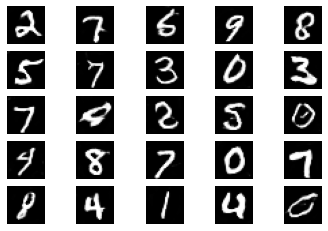

In [4]:
global sess
global graph
with graph.as_default():
    set_session(sess)    
    sgan = SGAN()
    sgan.train(epochs=20000, batch_size=32, sample_interval=50)

In [9]:
#Save!
def save(model, model_name):
    model_path = r"C:\Users\KIIT\AppData\Local\Programs\Python\Python36\Scripts\Untitled Folder 2\SGAN Images\%s.json" % model_name
    weights_path = r"C:\Users\KIIT\AppData\Local\Programs\Python\Python36\Scripts\Untitled Folder 2\SGAN Images\%s_weights.hdf5" % model_name
    options = {"file_arch": model_path,
           "file_weight": weights_path}
    json_string = model.to_json()
    open(options['file_arch'], 'w').write(json_string)
    model.save_weights(options['file_weight'])

save(sgan.generator, "mnist_sgan_generator")
save(sgan.discriminator, "mnist_sgan_discriminator")
save(sgan.combined, "mnist_sgan_adversarial")
print("Model should be saved.")

Model should be saved.


In [1]:
# load json and create model
json_file = open(r'C:\Users\KIIT\AppData\Local\Programs\Python\Python36\Scripts\Untitled Folder 2\SGAN Images\mnist_sgan_adversarial.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
print("JSON loaded!")

 

JSON loaded!


In [8]:
from keras.models import model_from_json
loaded_model = model_from_json(loaded_model_json)


from keras import models

def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = False

        if isinstance(layer, models.Model):
            freeze(layer)



# load weights into new model
loaded_model.load_weights(r"C:\Users\KIIT\AppData\Local\Programs\Python\Python36\Scripts\Untitled Folder 2\SGAN Images\mnist_sgan_adversarial_weights.hdf5")
freeze(loaded_model)
print("Loaded model from disk")

ValueError: axes don't match array

In [5]:
def generate_images(cnt):
    c=1
    while(c <= cnt):
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = sgan.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :,:,0], cmap='gray')
        plt.axis('off')
        plt.savefig(r"C:\Users\rishi\Documents\SGAN Images\generated_sgan\sgan_{}.jpg".format(c+4866), bbox_inches='tight', pad_inches=-0.0005)
        print("Image {} saved.".format(c))
        c+=1
        plt.close()
generate_images(5134)

Image 1 saved.
Image 2 saved.
Image 3 saved.
Image 4 saved.
Image 5 saved.
Image 6 saved.
Image 7 saved.
Image 8 saved.
Image 9 saved.
Image 10 saved.
Image 11 saved.
Image 12 saved.
Image 13 saved.
Image 14 saved.
Image 15 saved.
Image 16 saved.
Image 17 saved.
Image 18 saved.
Image 19 saved.
Image 20 saved.
Image 21 saved.
Image 22 saved.
Image 23 saved.
Image 24 saved.
Image 25 saved.
Image 26 saved.
Image 27 saved.
Image 28 saved.
Image 29 saved.
Image 30 saved.
Image 31 saved.
Image 32 saved.
Image 33 saved.
Image 34 saved.
Image 35 saved.
Image 36 saved.
Image 37 saved.
Image 38 saved.
Image 39 saved.
Image 40 saved.
Image 41 saved.
Image 42 saved.
Image 43 saved.
Image 44 saved.
Image 45 saved.
Image 46 saved.
Image 47 saved.
Image 48 saved.
Image 49 saved.
Image 50 saved.
Image 51 saved.
Image 52 saved.
Image 53 saved.
Image 54 saved.
Image 55 saved.
Image 56 saved.
Image 57 saved.
Image 58 saved.
Image 59 saved.
Image 60 saved.
Image 61 saved.
Image 62 saved.
Image 63 saved.
I

Image 493 saved.
Image 494 saved.
Image 495 saved.
Image 496 saved.
Image 497 saved.
Image 498 saved.
Image 499 saved.
Image 500 saved.
Image 501 saved.
Image 502 saved.
Image 503 saved.
Image 504 saved.
Image 505 saved.
Image 506 saved.
Image 507 saved.
Image 508 saved.
Image 509 saved.
Image 510 saved.
Image 511 saved.
Image 512 saved.
Image 513 saved.
Image 514 saved.
Image 515 saved.
Image 516 saved.
Image 517 saved.
Image 518 saved.
Image 519 saved.
Image 520 saved.
Image 521 saved.
Image 522 saved.
Image 523 saved.
Image 524 saved.
Image 525 saved.
Image 526 saved.
Image 527 saved.
Image 528 saved.
Image 529 saved.
Image 530 saved.
Image 531 saved.
Image 532 saved.
Image 533 saved.
Image 534 saved.
Image 535 saved.
Image 536 saved.
Image 537 saved.
Image 538 saved.
Image 539 saved.
Image 540 saved.
Image 541 saved.
Image 542 saved.
Image 543 saved.
Image 544 saved.
Image 545 saved.
Image 546 saved.
Image 547 saved.
Image 548 saved.
Image 549 saved.
Image 550 saved.
Image 551 save

Image 980 saved.
Image 981 saved.
Image 982 saved.
Image 983 saved.
Image 984 saved.
Image 985 saved.
Image 986 saved.
Image 987 saved.
Image 988 saved.
Image 989 saved.
Image 990 saved.
Image 991 saved.
Image 992 saved.
Image 993 saved.
Image 994 saved.
Image 995 saved.
Image 996 saved.
Image 997 saved.
Image 998 saved.
Image 999 saved.
Image 1000 saved.
Image 1001 saved.
Image 1002 saved.
Image 1003 saved.
Image 1004 saved.
Image 1005 saved.
Image 1006 saved.
Image 1007 saved.
Image 1008 saved.
Image 1009 saved.
Image 1010 saved.
Image 1011 saved.
Image 1012 saved.
Image 1013 saved.
Image 1014 saved.
Image 1015 saved.
Image 1016 saved.
Image 1017 saved.
Image 1018 saved.
Image 1019 saved.
Image 1020 saved.
Image 1021 saved.
Image 1022 saved.
Image 1023 saved.
Image 1024 saved.
Image 1025 saved.
Image 1026 saved.
Image 1027 saved.
Image 1028 saved.
Image 1029 saved.
Image 1030 saved.
Image 1031 saved.
Image 1032 saved.
Image 1033 saved.
Image 1034 saved.
Image 1035 saved.
Image 1036 s

Image 1437 saved.
Image 1438 saved.
Image 1439 saved.
Image 1440 saved.
Image 1441 saved.
Image 1442 saved.
Image 1443 saved.
Image 1444 saved.
Image 1445 saved.
Image 1446 saved.
Image 1447 saved.
Image 1448 saved.
Image 1449 saved.
Image 1450 saved.
Image 1451 saved.
Image 1452 saved.
Image 1453 saved.
Image 1454 saved.
Image 1455 saved.
Image 1456 saved.
Image 1457 saved.
Image 1458 saved.
Image 1459 saved.
Image 1460 saved.
Image 1461 saved.
Image 1462 saved.
Image 1463 saved.
Image 1464 saved.
Image 1465 saved.
Image 1466 saved.
Image 1467 saved.
Image 1468 saved.
Image 1469 saved.
Image 1470 saved.
Image 1471 saved.
Image 1472 saved.
Image 1473 saved.
Image 1474 saved.
Image 1475 saved.
Image 1476 saved.
Image 1477 saved.
Image 1478 saved.
Image 1479 saved.
Image 1480 saved.
Image 1481 saved.
Image 1482 saved.
Image 1483 saved.
Image 1484 saved.
Image 1485 saved.
Image 1486 saved.
Image 1487 saved.
Image 1488 saved.
Image 1489 saved.
Image 1490 saved.
Image 1491 saved.
Image 1492

Image 1893 saved.
Image 1894 saved.
Image 1895 saved.
Image 1896 saved.
Image 1897 saved.
Image 1898 saved.
Image 1899 saved.
Image 1900 saved.
Image 1901 saved.
Image 1902 saved.
Image 1903 saved.
Image 1904 saved.
Image 1905 saved.
Image 1906 saved.
Image 1907 saved.
Image 1908 saved.
Image 1909 saved.
Image 1910 saved.
Image 1911 saved.
Image 1912 saved.
Image 1913 saved.
Image 1914 saved.
Image 1915 saved.
Image 1916 saved.
Image 1917 saved.
Image 1918 saved.
Image 1919 saved.
Image 1920 saved.
Image 1921 saved.
Image 1922 saved.
Image 1923 saved.
Image 1924 saved.
Image 1925 saved.
Image 1926 saved.
Image 1927 saved.
Image 1928 saved.
Image 1929 saved.
Image 1930 saved.
Image 1931 saved.
Image 1932 saved.
Image 1933 saved.
Image 1934 saved.
Image 1935 saved.
Image 1936 saved.
Image 1937 saved.
Image 1938 saved.
Image 1939 saved.
Image 1940 saved.
Image 1941 saved.
Image 1942 saved.
Image 1943 saved.
Image 1944 saved.
Image 1945 saved.
Image 1946 saved.
Image 1947 saved.
Image 1948

Image 2351 saved.
Image 2352 saved.
Image 2353 saved.
Image 2354 saved.
Image 2355 saved.
Image 2356 saved.
Image 2357 saved.
Image 2358 saved.
Image 2359 saved.
Image 2360 saved.
Image 2361 saved.
Image 2362 saved.
Image 2363 saved.
Image 2364 saved.
Image 2365 saved.
Image 2366 saved.
Image 2367 saved.
Image 2368 saved.
Image 2369 saved.
Image 2370 saved.
Image 2371 saved.
Image 2372 saved.
Image 2373 saved.
Image 2374 saved.
Image 2375 saved.
Image 2376 saved.
Image 2377 saved.
Image 2378 saved.
Image 2379 saved.
Image 2380 saved.
Image 2381 saved.
Image 2382 saved.
Image 2383 saved.
Image 2384 saved.
Image 2385 saved.
Image 2386 saved.
Image 2387 saved.
Image 2388 saved.
Image 2389 saved.
Image 2390 saved.
Image 2391 saved.
Image 2392 saved.
Image 2393 saved.
Image 2394 saved.
Image 2395 saved.
Image 2396 saved.
Image 2397 saved.
Image 2398 saved.
Image 2399 saved.
Image 2400 saved.
Image 2401 saved.
Image 2402 saved.
Image 2403 saved.
Image 2404 saved.
Image 2405 saved.
Image 2406

Image 2810 saved.
Image 2811 saved.
Image 2812 saved.
Image 2813 saved.
Image 2814 saved.
Image 2815 saved.
Image 2816 saved.
Image 2817 saved.
Image 2818 saved.
Image 2819 saved.
Image 2820 saved.
Image 2821 saved.
Image 2822 saved.
Image 2823 saved.
Image 2824 saved.
Image 2825 saved.
Image 2826 saved.
Image 2827 saved.
Image 2828 saved.
Image 2829 saved.
Image 2830 saved.
Image 2831 saved.
Image 2832 saved.
Image 2833 saved.
Image 2834 saved.
Image 2835 saved.
Image 2836 saved.
Image 2837 saved.
Image 2838 saved.
Image 2839 saved.
Image 2840 saved.
Image 2841 saved.
Image 2842 saved.
Image 2843 saved.
Image 2844 saved.
Image 2845 saved.
Image 2846 saved.
Image 2847 saved.
Image 2848 saved.
Image 2849 saved.
Image 2850 saved.
Image 2851 saved.
Image 2852 saved.
Image 2853 saved.
Image 2854 saved.
Image 2855 saved.
Image 2856 saved.
Image 2857 saved.
Image 2858 saved.
Image 2859 saved.
Image 2860 saved.
Image 2861 saved.
Image 2862 saved.
Image 2863 saved.
Image 2864 saved.
Image 2865

Image 3271 saved.
Image 3272 saved.
Image 3273 saved.
Image 3274 saved.
Image 3275 saved.
Image 3276 saved.
Image 3277 saved.
Image 3278 saved.
Image 3279 saved.
Image 3280 saved.
Image 3281 saved.
Image 3282 saved.
Image 3283 saved.
Image 3284 saved.
Image 3285 saved.
Image 3286 saved.
Image 3287 saved.
Image 3288 saved.
Image 3289 saved.
Image 3290 saved.
Image 3291 saved.
Image 3292 saved.
Image 3293 saved.
Image 3294 saved.
Image 3295 saved.
Image 3296 saved.
Image 3297 saved.
Image 3298 saved.
Image 3299 saved.
Image 3300 saved.
Image 3301 saved.
Image 3302 saved.
Image 3303 saved.
Image 3304 saved.
Image 3305 saved.
Image 3306 saved.
Image 3307 saved.
Image 3308 saved.
Image 3309 saved.
Image 3310 saved.
Image 3311 saved.
Image 3312 saved.
Image 3313 saved.
Image 3314 saved.
Image 3315 saved.
Image 3316 saved.
Image 3317 saved.
Image 3318 saved.
Image 3319 saved.
Image 3320 saved.
Image 3321 saved.
Image 3322 saved.
Image 3323 saved.
Image 3324 saved.
Image 3325 saved.
Image 3326

Image 3730 saved.
Image 3731 saved.
Image 3732 saved.
Image 3733 saved.
Image 3734 saved.
Image 3735 saved.
Image 3736 saved.
Image 3737 saved.
Image 3738 saved.
Image 3739 saved.
Image 3740 saved.
Image 3741 saved.
Image 3742 saved.
Image 3743 saved.
Image 3744 saved.
Image 3745 saved.
Image 3746 saved.
Image 3747 saved.
Image 3748 saved.
Image 3749 saved.
Image 3750 saved.
Image 3751 saved.
Image 3752 saved.
Image 3753 saved.
Image 3754 saved.
Image 3755 saved.
Image 3756 saved.
Image 3757 saved.
Image 3758 saved.
Image 3759 saved.
Image 3760 saved.
Image 3761 saved.
Image 3762 saved.
Image 3763 saved.
Image 3764 saved.
Image 3765 saved.
Image 3766 saved.
Image 3767 saved.
Image 3768 saved.
Image 3769 saved.
Image 3770 saved.
Image 3771 saved.
Image 3772 saved.
Image 3773 saved.
Image 3774 saved.
Image 3775 saved.
Image 3776 saved.
Image 3777 saved.
Image 3778 saved.
Image 3779 saved.
Image 3780 saved.
Image 3781 saved.
Image 3782 saved.
Image 3783 saved.
Image 3784 saved.
Image 3785

Image 4187 saved.
Image 4188 saved.
Image 4189 saved.
Image 4190 saved.
Image 4191 saved.
Image 4192 saved.
Image 4193 saved.
Image 4194 saved.
Image 4195 saved.
Image 4196 saved.
Image 4197 saved.
Image 4198 saved.
Image 4199 saved.
Image 4200 saved.
Image 4201 saved.
Image 4202 saved.
Image 4203 saved.
Image 4204 saved.
Image 4205 saved.
Image 4206 saved.
Image 4207 saved.
Image 4208 saved.
Image 4209 saved.
Image 4210 saved.
Image 4211 saved.
Image 4212 saved.
Image 4213 saved.
Image 4214 saved.
Image 4215 saved.
Image 4216 saved.
Image 4217 saved.
Image 4218 saved.
Image 4219 saved.
Image 4220 saved.
Image 4221 saved.
Image 4222 saved.
Image 4223 saved.
Image 4224 saved.
Image 4225 saved.
Image 4226 saved.
Image 4227 saved.
Image 4228 saved.
Image 4229 saved.
Image 4230 saved.
Image 4231 saved.
Image 4232 saved.
Image 4233 saved.
Image 4234 saved.
Image 4235 saved.
Image 4236 saved.
Image 4237 saved.
Image 4238 saved.
Image 4239 saved.
Image 4240 saved.
Image 4241 saved.
Image 4242

Image 4643 saved.
Image 4644 saved.
Image 4645 saved.
Image 4646 saved.
Image 4647 saved.
Image 4648 saved.
Image 4649 saved.
Image 4650 saved.
Image 4651 saved.
Image 4652 saved.
Image 4653 saved.
Image 4654 saved.
Image 4655 saved.
Image 4656 saved.
Image 4657 saved.
Image 4658 saved.
Image 4659 saved.
Image 4660 saved.
Image 4661 saved.
Image 4662 saved.
Image 4663 saved.
Image 4664 saved.
Image 4665 saved.
Image 4666 saved.
Image 4667 saved.
Image 4668 saved.
Image 4669 saved.
Image 4670 saved.
Image 4671 saved.
Image 4672 saved.
Image 4673 saved.
Image 4674 saved.
Image 4675 saved.
Image 4676 saved.
Image 4677 saved.
Image 4678 saved.
Image 4679 saved.
Image 4680 saved.
Image 4681 saved.
Image 4682 saved.
Image 4683 saved.
Image 4684 saved.
Image 4685 saved.
Image 4686 saved.
Image 4687 saved.
Image 4688 saved.
Image 4689 saved.
Image 4690 saved.
Image 4691 saved.
Image 4692 saved.
Image 4693 saved.
Image 4694 saved.
Image 4695 saved.
Image 4696 saved.
Image 4697 saved.
Image 4698

Image 5102 saved.
Image 5103 saved.
Image 5104 saved.
Image 5105 saved.
Image 5106 saved.
Image 5107 saved.
Image 5108 saved.
Image 5109 saved.
Image 5110 saved.
Image 5111 saved.
Image 5112 saved.
Image 5113 saved.
Image 5114 saved.
Image 5115 saved.
Image 5116 saved.
Image 5117 saved.
Image 5118 saved.
Image 5119 saved.
Image 5120 saved.
Image 5121 saved.
Image 5122 saved.
Image 5123 saved.
Image 5124 saved.
Image 5125 saved.
Image 5126 saved.
Image 5127 saved.
Image 5128 saved.
Image 5129 saved.
Image 5130 saved.
Image 5131 saved.
Image 5132 saved.
Image 5133 saved.
Image 5134 saved.
